<a href="https://colab.research.google.com/github/AndreiAf02/Inflation-Study-Updated/blob/main/Project_Code_Updated_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Bayesian Analysis of Macroeconomic Influences on Inflation and Gold Price



## Andrei Afilipoaei, Binbing Wu, Ziqiu Wan

In this project, we wish to analyze the nature and significance of the relationship between inflation in the United States (measured by CPI-U) and a variety of important macroeconomic and market factors, including prime interest rate, GDP growth, West Texas Intermediate (WTI) Oil price, S&P 500 stock index, and monetary base (money supply). For this purpose, we elected to use the monthly data collected from January 1960 to June 2023.

The CPI-U (Consumer Price Index for all Urban Consumers) was adapted from the data given by the Bureau of Labor Statistics ([CPI](https://beta.bls.gov/dataViewer/view/timeseries/CUSR0000SA0)), using annual compounding of the monthly change by the equation $((1+\Delta CPI/100)^{12} -1)*100$.

Meanwhile, the Monetary Base, Bank Prime Loan Rate, GDP, and Oil Price were obtained from *Federal Reserve Economic Data* ([monetary base](https://fred.stlouisfed.org/series/BOGMBASE), [prime rate](https://fred.stlouisfed.org/series/DPRIME), [GDP](https://fred.stlouisfed.org/series/GDP), and [WTI Oil](https://fred.stlouisfed.org/series/WTISPLC)). Data for the S&P 500 stock index was obtained from *Official Data* ([S&P500](https://www.officialdata.org/us/stocks/s-p-500/1900)).

Note that the GDP data was recorded only quarterly, so we interpolated the GDP monthly percentage change using the equation $((GDP(Q_{n+1})/GDP(Q_n))^{1/3}-1)*100 $.

The data for gold is obtained from January 1971 to June 2023 from [Auronum](https://auronum.co.uk/gold-price-news/historic-gold-price-data/). The gold data is recorded as the monthly percentage change in the gold price. Prior to 1971, the US dollar was fixed to a gold standard ([Zoeller and Bandelj, 2019](https://doi.org/10.1177/2378023119841812)), making any data prior to that year effectively meaningless; hence, we only recorded gold prices for 1971 on.  

Several datapoints showed extraordinary (outlier) behavior, notably for the months of October, November, and December 2008, January 2009, and March, April and May 2020; since these arose from extraordinary circumstances (the 2008 Great Recession and the 2020 COVID lockdowns), we dropped these datapoints from our dataset.  




In [ ]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import pymc as pm
import seaborn as sns
import arviz as az ## This is new, but it is installed along with PyMC3



import warnings # the warning spam is pointless and annoying
warnings.simplefilter(action="ignore", category=FutureWarning)

def credible_interval_from_samples(samples, prob):
    """`samples` can be an nd array. Assume that all of the dimensions
    except for the last index parameters while the last (rightmost)
    dimension indexes the samples."""
    samples_sorted = sort(samples, axis=-1)
    N_samples = samples.shape[-1]
    index = int(N_samples*(1 - prob)/2)
    lower = samples_sorted[..., index]
    upper = samples_sorted[..., -index]
    ## quantile(x, [(1 - prob)/2, (1 + prob)/2], axis=-1)
    return lower, upper

Populating the interactive namespace from numpy and matplotlib


In [ ]:
path_to_data = 'https://raw.githubusercontent.com/AndreiAf02/Inflation-Study-Updated/main/'
data_all = pd.read_csv(path_to_data + "New_Gold_Inflation.csv", sep=",", header=0)
data_all = data_all[data_all['Date'].notnull()]
data_all = data_all.loc[:, ~data_all.columns.str.contains('^Unnamed')]
# data_all.drop(columns=-1)
data_all


Date  BOGMBASE  Money Base Change  DPRIME       GDP  SPIndex  \
0    1960-01-01     50700           1.807229    5.00  0.878128  -0.0361   
1    1960-02-01     49600          -2.169625    5.00 -0.096411  -0.0108   
2    1960-03-01     49500          -0.201613    5.00 -0.096411   0.0158   
3    1960-04-01     49700           0.404040    5.00 -0.096411  -0.0062   
4    1960-05-01     49700           0.000000    5.00  0.277929   0.0399   
..          ...       ...                ...     ...       ...      ...   
750  2023-02-01   5321600          -0.138863    7.50  0.309099  -0.0259   
751  2023-03-01   5571500           4.695956    7.75  0.309099   0.0400   
752  2023-04-01   5593100           0.387687    8.00  0.309099   0.0060   
753  2023-05-01   5569600          -0.420161    8.00  0.685690   0.0480   
754  2023-06-01   5608500           0.698434    8.25  0.685690   0.0254   

          Oil     CPI.U  GoldChange  
0    0.000000 -1.193422         NaN  
1    0.000000  1.206622         NaN  
2    0.000000  0.000000         NaN  
3    0.000000  4.907021         NaN  
4    0.000000  1.206622         NaN  
..        ...       ...         ...  
750 -1.651306  4.907021    6.949104  
751 -4.620591  1.206622   -5.825150  
752  8.419760  4.907021    8.019392  
753 -9.905601  1.206622   -0.103845  
754 -1.858061  2.426577   -0.210399  

[755 rows x 9 columns]

In [ ]:
# ## Old Data


# path_to_data = 'https://raw.githubusercontent.com/AndreiAf02/Inflation-Study-Updated/main/'
# data_all = pd.read_csv(path_to_data + "inflation.csv", sep=",", header=0)
# data_all = data_all[data_all['Date'].notnull()]
# data_all = data_all.loc[:, ~data_all.columns.str.contains('^Unnamed')]
# # data_all.drop(columns=-1)
# data_all

In [ ]:
data_all['CPI.U'].mean()

3.90375221533245

## Previous work:

In the previous analysis of this dataset, Andrei performed a frequentist analysis of the multiple linear regression model using R. Ziqiu Wan further developed this analysis by introducing data separation into training and testing sets (which Andrei did not do previously) and observing the correlation matrix and model parameter estimates.



In [ ]:
cleaned_data = data_all.drop(columns=['GoldChange'])
cleaned_data

Date  BOGMBASE  Money Base Change  DPRIME       GDP  SPIndex  \
0    1960-01-01     50700           1.807229    5.00  0.878128  -0.0361   
1    1960-02-01     49600          -2.169625    5.00 -0.096411  -0.0108   
2    1960-03-01     49500          -0.201613    5.00 -0.096411   0.0158   
3    1960-04-01     49700           0.404040    5.00 -0.096411  -0.0062   
4    1960-05-01     49700           0.000000    5.00  0.277929   0.0399   
..          ...       ...                ...     ...       ...      ...   
750  2023-02-01   5321600          -0.138863    7.50  0.309099  -0.0259   
751  2023-03-01   5571500           4.695956    7.75  0.309099   0.0400   
752  2023-04-01   5593100           0.387687    8.00  0.309099   0.0060   
753  2023-05-01   5569600          -0.420161    8.00  0.685690   0.0480   
754  2023-06-01   5608500           0.698434    8.25  0.685690   0.0254   

          Oil     CPI.U  
0    0.000000 -1.193422  
1    0.000000  1.206622  
2    0.000000  0.000000  
3    0.000000  4.907021  
4    0.000000  1.206622  
..        ...       ...  
750 -1.651306  4.907021  
751 -4.620591  1.206622  
752  8.419760  4.907021  
753 -9.905601  1.206622  
754 -1.858061  2.426577  

[755 rows x 8 columns]

In [ ]:
correlation_matrix = cleaned_data.drop(columns=['BOGMBASE', 'Date']).corr()
# print(correlation_matrix[['CPI.U']])
print(correlation_matrix)

                   Money Base Change    DPRIME       GDP   SPIndex       Oil  \
Money Base Change           1.000000 -0.012077 -0.016971  0.050880  0.063058   
DPRIME                     -0.012077  1.000000  0.142556  0.010509  0.021733   
GDP                        -0.016971  0.142556  1.000000  0.179267  0.058932   
SPIndex                     0.050880  0.010509  0.179267  1.000000 -0.011931   
Oil                         0.063058  0.021733  0.058932 -0.011931  1.000000   
CPI.U                      -0.030389  0.445513  0.271077 -0.117700  0.289595   

                      CPI.U  
Money Base Change -0.030389  
DPRIME             0.445513  
GDP                0.271077  
SPIndex           -0.117700  
Oil                0.289595  
CPI.U              1.000000  


In [ ]:
correlation_matrix.style.background_gradient(cmap='coolwarm')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [ ]:
X = cleaned_data.drop(columns=['BOGMBASE', 'Date', 'CPI.U'])
y = cleaned_data['CPI.U']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, RMSE: {rmse}, R^2: {r2}")

coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

MSE: 8.246673139284495, RMSE: 2.8717021327575907, R^2: 0.3029736902844762
                   Coefficient
Money Base Change    -0.085413
DPRIME                0.486460
GDP                   2.388169
SPIndex             -18.791519
Oil                   0.108090


# Part 1:
**Analyzing the important factors of Inflation:**

The expected processes of the Directed Acyclic Graph above can be summarized as follows:
* The Money Supply (MS) directly influences the interest rate (Rate) and economic growth (GDP)
* The Rate, in turn, influences the GDP growth.
* Oil price also influences economic well-being, and hence affects GDP growth.
* The GDP growth then influences investor optimism/pessimism and hence influences the stock market (including the S&P 500 stock index).
* GDP growth also provokes price growth in consumer items, leading to CPI growth (inflation).
* Oil price increases further cause the producer cost of consumer items to rise, thereby bringing CPI growth.
* Since stock market does not directly affect inflation, we conclude that any correlation between S&P 500 stock index and CPI inflation is spurious.


## Inflation & WTI Oil price growth:

Firstly, we analyze the significance of the relationship between oil price growth and inflation. Examining the DAG, we observe that we can close secondary paths from Oil price to CPI inflation by conditioning on GDP growth.

Furthermore, we also observe that the mean of CPI inflation is approximately 3.90%, so we take the intercept $\alpha$ to have a mean of 4 and standard deviation of 2. Furthermore, we take a slightly wider distribution of $\sigma$. Because we do not know the nature of the relationship between inflation and oil price, we take a prior of the $\beta$ estimates to be centered at 0, with standard deviation at 1.


As such, we take the following prior:

\begin{align*}
    CPI_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{W}(W_{i}-\bar{W}) \\
    \alpha &\sim \text{Normal}(4, 2) \\
    \beta_{W} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $W_i$ denotes the West Texas Intermediate oil price growth rate.

In [ ]:
with pm.Model() as model_oil1:
    sigma = pm.Exponential('sigma', 0.5)
    beta_W = pm.Normal('beta_W', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=4, sigma=2)
    _mu = alpha + beta_W*(data_all['Oil']-data_all['Oil'].mean())
    mu = pm.Deterministic('mu', _mu)
    CPI = pm.Normal('CPI', mu=mu, sigma=sigma, observed=data_all['CPI.U'])
    _model_oil1_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_oil1_mcmc_samples = _model_oil1_mcmc_samples.posterior.to_dataframe()
model_oil1_mcmc_samples

alpha    beta_W        mu     sigma
chain draw mu_dim_0                                        
0     0    0         3.603414  0.124678  3.508749  3.694574
           1         3.603414  0.124678  3.508749  3.694574
           2         3.603414  0.124678  3.508749  3.694574
           3         3.603414  0.124678  3.508749  3.694574
           4         3.603414  0.124678  3.508749  3.694574
...                       ...       ...       ...       ...
3     999  750       3.995901  0.111416  3.727323  3.719428
           751       3.995901  0.111416  3.396496  3.719428
           752       3.995901  0.111416  4.849404  3.719428
           753       3.995901  0.111416  2.807660  3.719428
           754       3.995901  0.111416  3.704287  3.719428

[3020000 rows x 4 columns]

<Axes: >

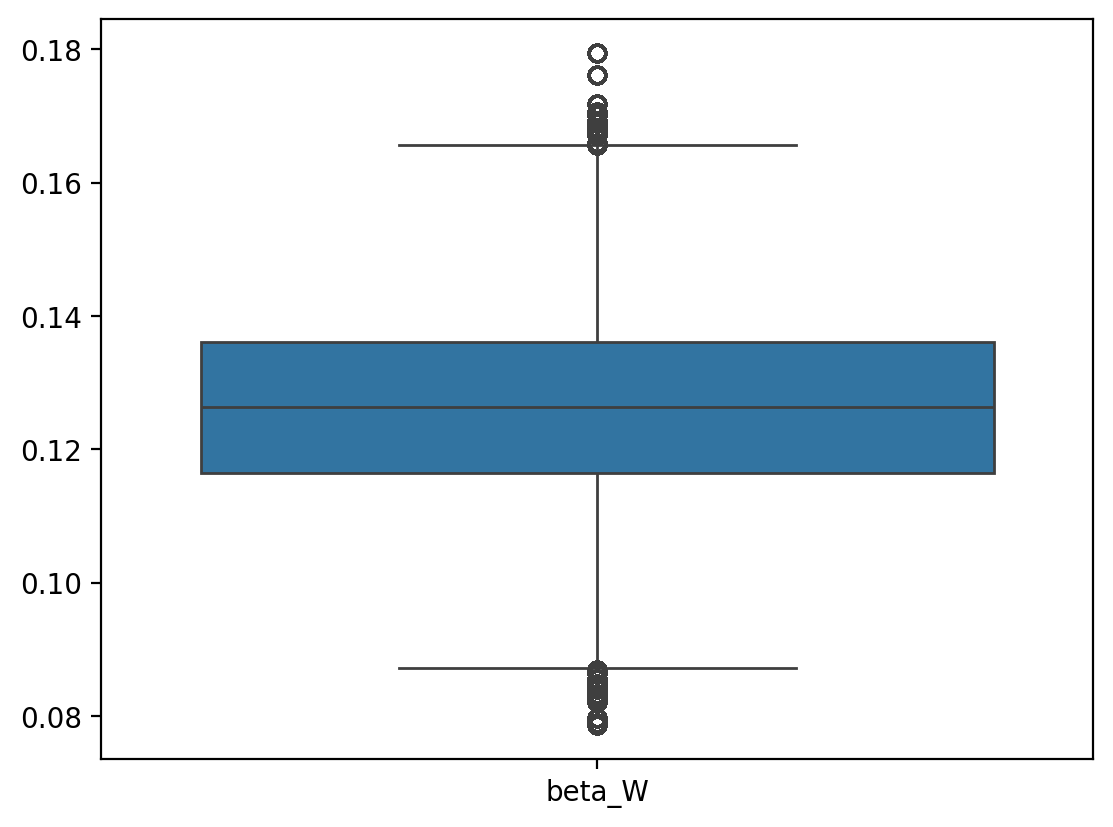

In [ ]:
sns.boxplot(data=model_oil1_mcmc_samples[['beta_W']])

As can be seen, the MCMC estimate of $\beta_W$ is significantly above 0. This indicates that there is actually a strong positive relationship between oil price changes and inflation.

In [ ]:
def plot_prediction_intervals_corrected(x, xmean, alpha_samples, beta_samples, sigma_samples, data_x, data_y, title_text, xlabel_text):
    N_weight = len(x)

    # Compute mean values
    mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)
    mu_samples = alpha_samples[:, None] + beta_samples[:, None]*(x - xmean)

    N_posterior_samples = alpha_samples.size
    prob = 0.95

    #### the mean posterior average height
    mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

    #### collect samples of the average height
    mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
    ## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
    mu_samples_sorted = sort(mu_samples, axis=1)
    index = int(N_posterior_samples*(1 - prob)/2)
    mu_lower = mu_samples_sorted[:, index]
    mu_upper = mu_samples_sorted[:, -index]

    #### Sample the posterior prediction height
    h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
    ## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
    h_samples_sorted = sort(h_samples, axis=1)
    index = int(N_posterior_samples*(1 - prob)/2)
    h_lower = h_samples_sorted[:, index]
    h_upper = h_samples_sorted[:, -index]
    plt.fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
    plt.fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
    plt.plot(data_x, data_y, 'o', mfc='none')
    plt.plot(x, mu_avg, 'k')
    plt.title(title_text)
    plt.xlabel(xlabel_text, fontsize=12)
    plt.ylabel('Inflation', fontsize=12)


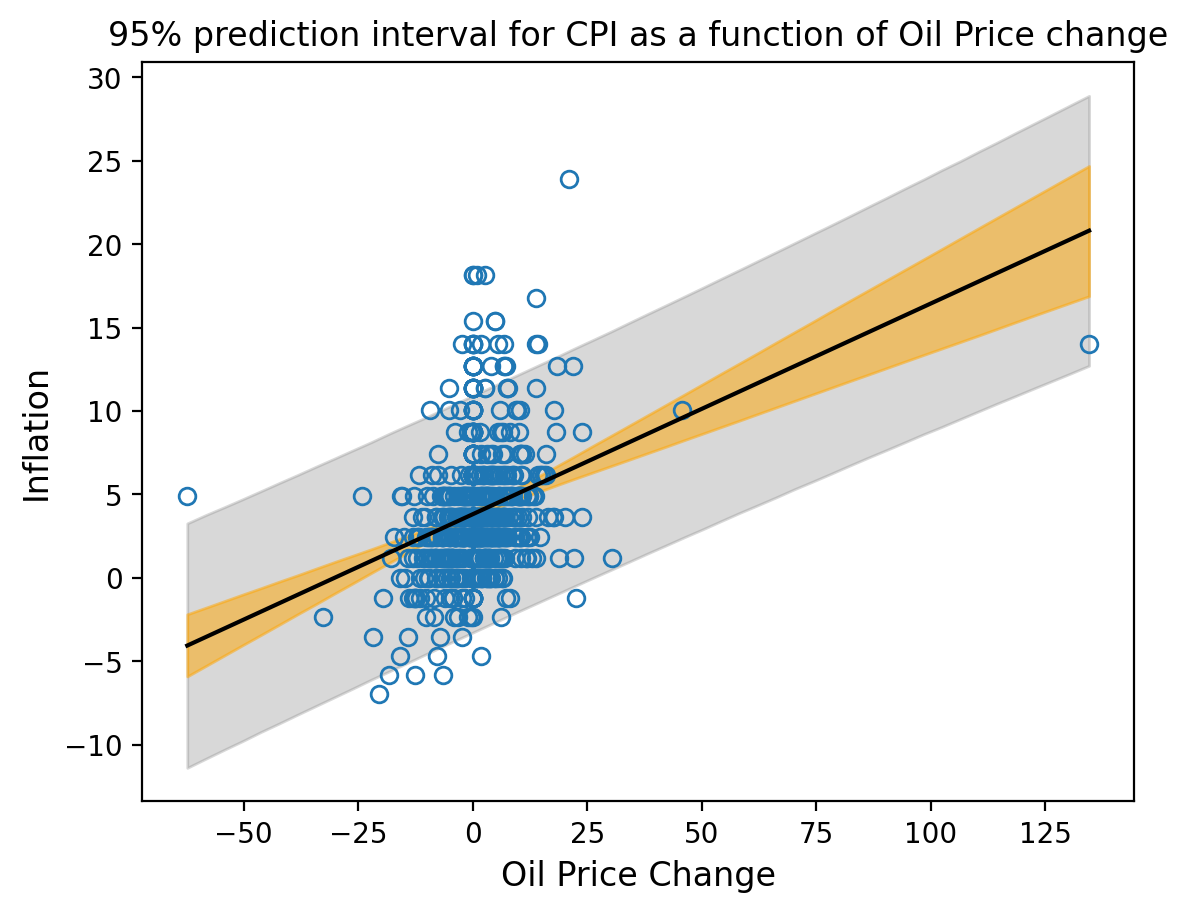

In [ ]:
# Plot for Oil
xmin, xmax, xmean = data_all['Oil'].min(), data_all['Oil'].max(), data_all['Oil'].mean()
x = linspace(xmin, xmax, 50)
plot_prediction_intervals_corrected(x, xmean, array(model_oil1_mcmc_samples['alpha']),
        array(model_oil1_mcmc_samples['beta_W']), array(model_oil1_mcmc_samples['sigma']),
        data_all['Oil'], data_all['CPI.U'], '95% prediction interval for CPI as a function of Oil Price change', 'Oil Price Change')
plt.show()

## Checking Linearity Assumption:

**Oil price analysis without influential datapoints**:

Returning to our MCMC analysis of CPI versus oil price, we can clearly see that the credibility interval plot for CPI versus Oil price change is heavily skewed by several extreme datapoints; these points correspond to extraordinary economic shocks that brought extreme overnight fluctuations in the price of oil. As such, we investigate how our MCMC model behaves if we drop these extreme influential data points, to verify whether our linearity assumption is acceptable.  

In [ ]:
oil_threshold = data_all['Oil'].quantile([0.01, 0.99]).values
oil_low_threshold, oil_high_threshold = oil_threshold
data_new = data_all[(data_all['Oil'] > oil_low_threshold) & (data_all['Oil'] < oil_high_threshold)]
data_new

Date  BOGMBASE  Money Base Change  DPRIME       GDP  SPIndex  \
0    1960-01-01     50700           1.807229    5.00  0.878128  -0.0361   
1    1960-02-01     49600          -2.169625    5.00 -0.096411  -0.0108   
2    1960-03-01     49500          -0.201613    5.00 -0.096411   0.0158   
3    1960-04-01     49700           0.404040    5.00 -0.096411  -0.0062   
4    1960-05-01     49700           0.000000    5.00  0.277929   0.0399   
..          ...       ...                ...     ...       ...      ...   
750  2023-02-01   5321600          -0.138863    7.50  0.309099  -0.0259   
751  2023-03-01   5571500           4.695956    7.75  0.309099   0.0400   
752  2023-04-01   5593100           0.387687    8.00  0.309099   0.0060   
753  2023-05-01   5569600          -0.420161    8.00  0.685690   0.0480   
754  2023-06-01   5608500           0.698434    8.25  0.685690   0.0254   

          Oil     CPI.U  GoldChange  
0    0.000000 -1.193422         NaN  
1    0.000000  1.206622         NaN  
2    0.000000  0.000000         NaN  
3    0.000000  4.907021         NaN  
4    0.000000  1.206622         NaN  
..        ...       ...         ...  
750 -1.651306  4.907021    6.949104  
751 -4.620591  1.206622   -5.825150  
752  8.419760  4.907021    8.019392  
753 -9.905601  1.206622   -0.103845  
754 -1.858061  2.426577   -0.210399  

[739 rows x 9 columns]

Our prior still takes the form:
\begin{align*}
    CPI_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{W}(W_{i}-\bar{W}) \\
    \alpha &\sim \text{Normal}(4, 2) \\
    \beta_{R} &\sim \text{Normal}(0, 1) \\
    \beta_{W} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}

In [ ]:
with pm.Model() as model_oil2:
    sigma = pm.Exponential('sigma', 0.5)
    beta_W = pm.Normal('beta_W', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=4, sigma=2)
    _mu = alpha + beta_W*(data_new['Oil']-data_new['Oil'].mean())
    mu = pm.Deterministic('mu', _mu)
    CPI = pm.Normal('CPI', mu=mu, sigma=sigma, observed=data_new['CPI.U'])
    _model_oil2_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_oil2_mcmc_samples = _model_oil2_mcmc_samples.posterior.to_dataframe()
model_oil2_mcmc_samples

alpha    beta_W        mu     sigma
chain draw mu_dim_0                                        
0     0    0         3.943382  0.152239  3.847559  3.483382
           1         3.943382  0.152239  3.847559  3.483382
           2         3.943382  0.152239  3.847559  3.483382
           3         3.943382  0.152239  3.847559  3.483382
           4         3.943382  0.152239  3.847559  3.483382
...                       ...       ...       ...       ...
3     999  734       3.851258  0.179292  3.442341  3.450354
           735       3.851258  0.179292  2.909973  3.450354
           736       3.851258  0.179292  5.248000  3.450354
           737       3.851258  0.179292  1.962414  3.450354
           738       3.851258  0.179292  3.405272  3.450354

[2956000 rows x 4 columns]

<Axes: >

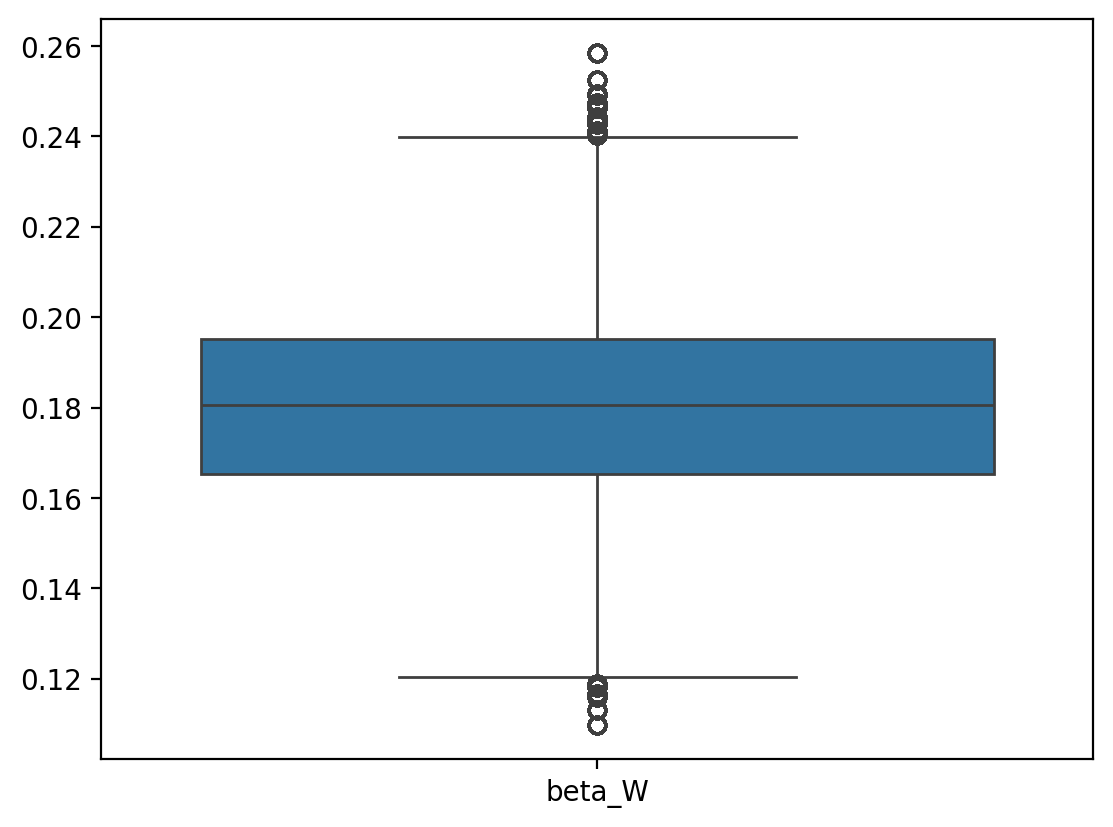

In [ ]:
sns.boxplot(data=model_oil2_mcmc_samples[['beta_W']])

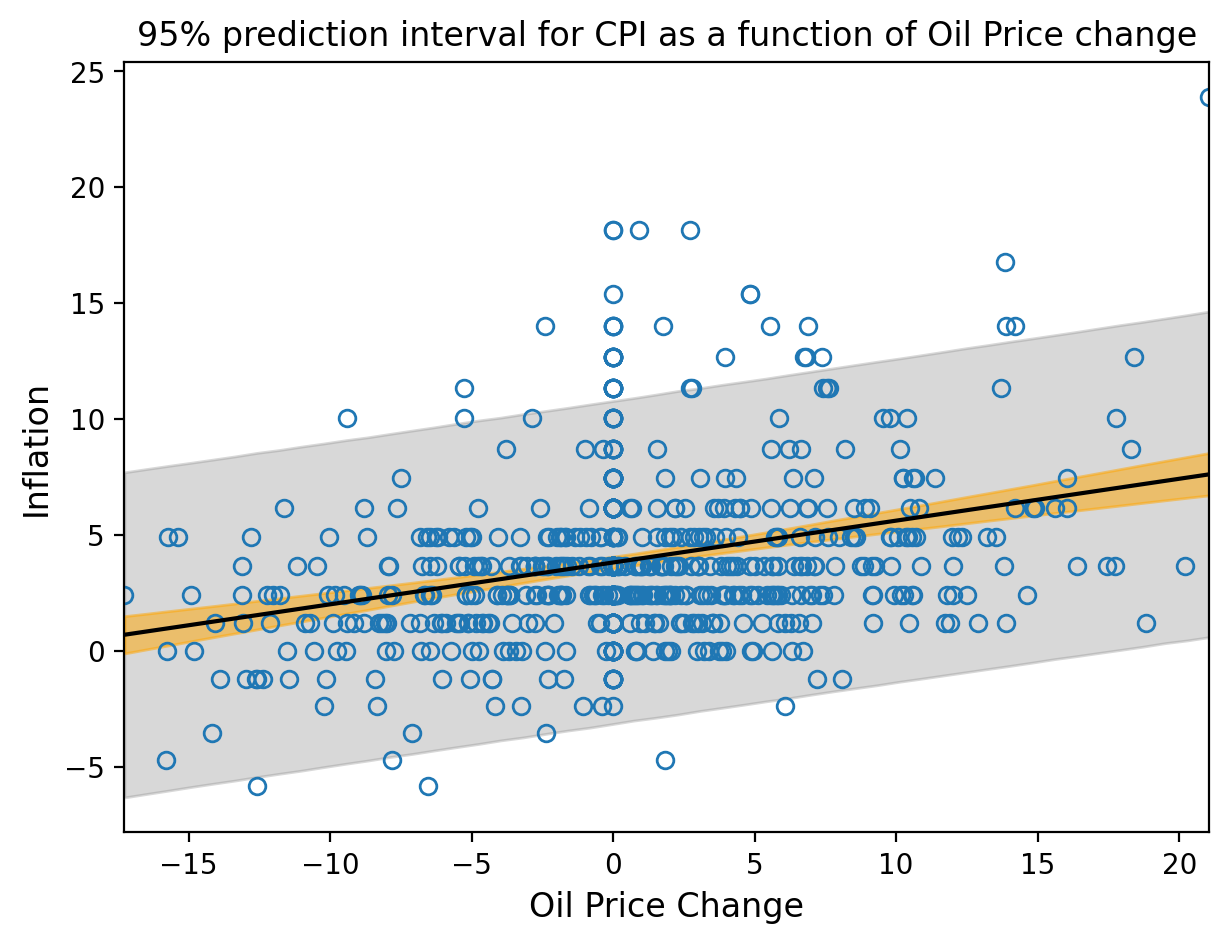

In [ ]:
## Prediction plot for CPI from Oil MCMC:

prob = 0.95 ## for credible intervals

xmin = data_new['Oil'].min()
xmax = data_new['Oil'].max()
xmean = data_new['Oil'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_oil2_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_oil2_mcmc_samples['beta_W'])[None, :]
sigma_samples = array(model_oil2_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_new['Oil'], data_new['CPI.U'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for CPI as a function of Oil Price change')
xlabel('Oil Price Change', fontsize=12)
ylabel('Inflation', fontsize=12);

As can be seen, once those extreme datapoints have been dropped, the regression fit between Inflation and Oil Price change is much better, and follows a linear trend acceptably well. As such, we conclude that our linearity assumption on the relationship between inflation and oil price is reasonable.

## Inflation, Interest Rate & GDP Growth:

Now, we analyze interest rate and GDP growth, in order to check whether the conditional independence expected from the DAG is present.

For this, we observe that the mean of CPI inflation is approximately 3.90%, so we take the intercept $\alpha$ to have a mean of 4 and standard deviation of 2. Furthermore, we take a slightly wider distribution of $\sigma$. Because we do not know the nature of the relationship between inflation and interest rate and oil price, we take a prior of the $\beta$ estimates to be centered at 0, with standard deviation at 1.

This takes the form:

\begin{align*}
    CPI_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{R}(R_{i}-\bar{R}) + \beta_{G}(G_{i}-\bar{G}) \\
    \alpha &\sim \text{Normal}(4, 2) \\
    \beta_{R} &\sim \text{Normal}(0, 1) \\
    \beta_{G} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $G_i$ denotes the GDP growth rate.


In [ ]:
with pm.Model() as model_project1:
    sigma = pm.Exponential('sigma', 0.5)
    beta_R = pm.Normal('beta_R', mu=0, sigma=1)
    beta_G = pm.Normal('beta_G', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=4, sigma=2)
    _mu = alpha + beta_R*(data_all['DPRIME']-data_all['DPRIME'].mean()) + beta_G*(data_all['GDP']-data_all['GDP'].mean())
    mu = pm.Deterministic('mu', _mu)
    CPI = pm.Normal('CPI', mu=mu, sigma=sigma, observed=data_all['CPI.U'])
    _model_project1_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_project1_mcmc_samples = _model_project1_mcmc_samples.posterior.to_dataframe()
model_project1_mcmc_samples

alpha    beta_G    beta_R        mu     sigma
chain draw mu_dim_0                                                  
0     0    0         3.976403  1.643764  0.463236  3.613996  3.356903
           1         3.976403  1.643764  0.463236  2.012083  3.356903
           2         3.976403  1.643764  0.463236  2.012083  3.356903
           3         3.976403  1.643764  0.463236  2.012083  3.356903
           4         3.976403  1.643764  0.463236  2.627409  3.356903
...                       ...       ...       ...       ...       ...
3     999  750       4.098882  2.272029  0.442678  3.812558  3.171539
           751       4.098882  2.272029  0.442678  3.923228  3.171539
           752       4.098882  2.272029  0.442678  4.033897  3.171539
           753       4.098882  2.272029  0.442678  4.889523  3.171539
           754       4.098882  2.272029  0.442678  5.000192  3.171539

[3020000 rows x 5 columns]

<Axes: >

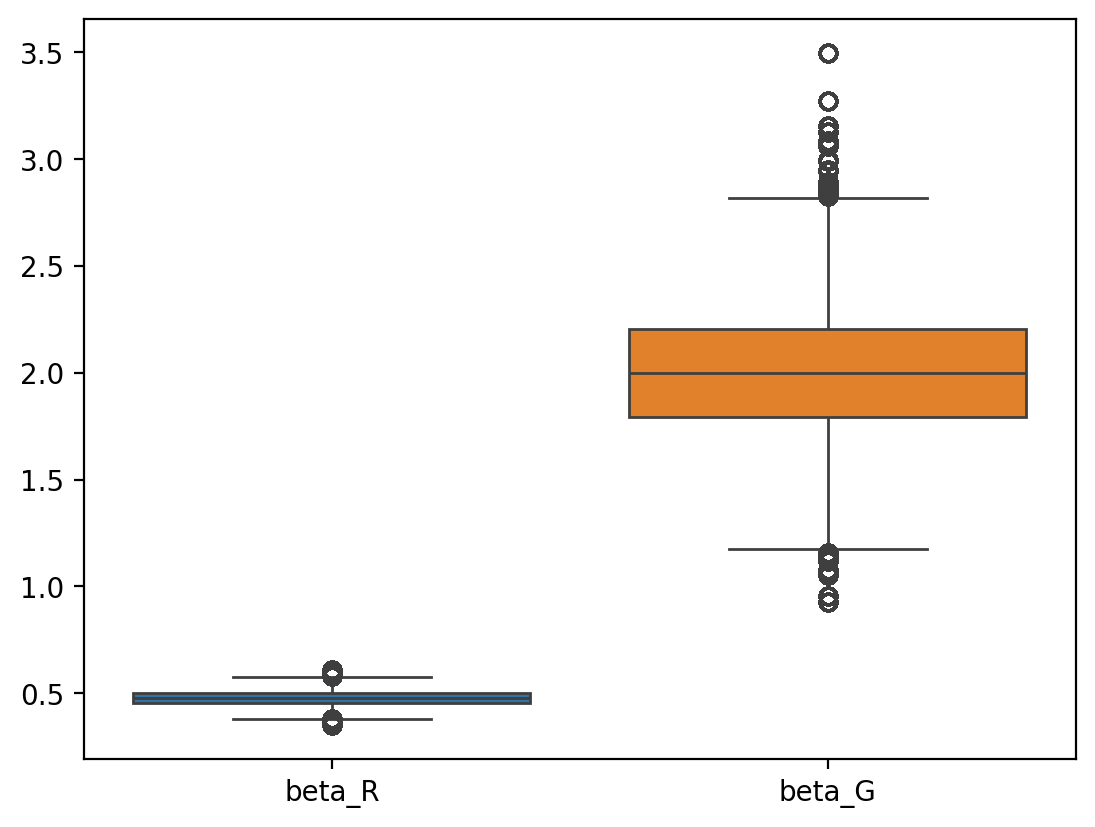

In [ ]:
sns.boxplot(data=model_project1_mcmc_samples[['beta_R', 'beta_G']])

<Axes: >

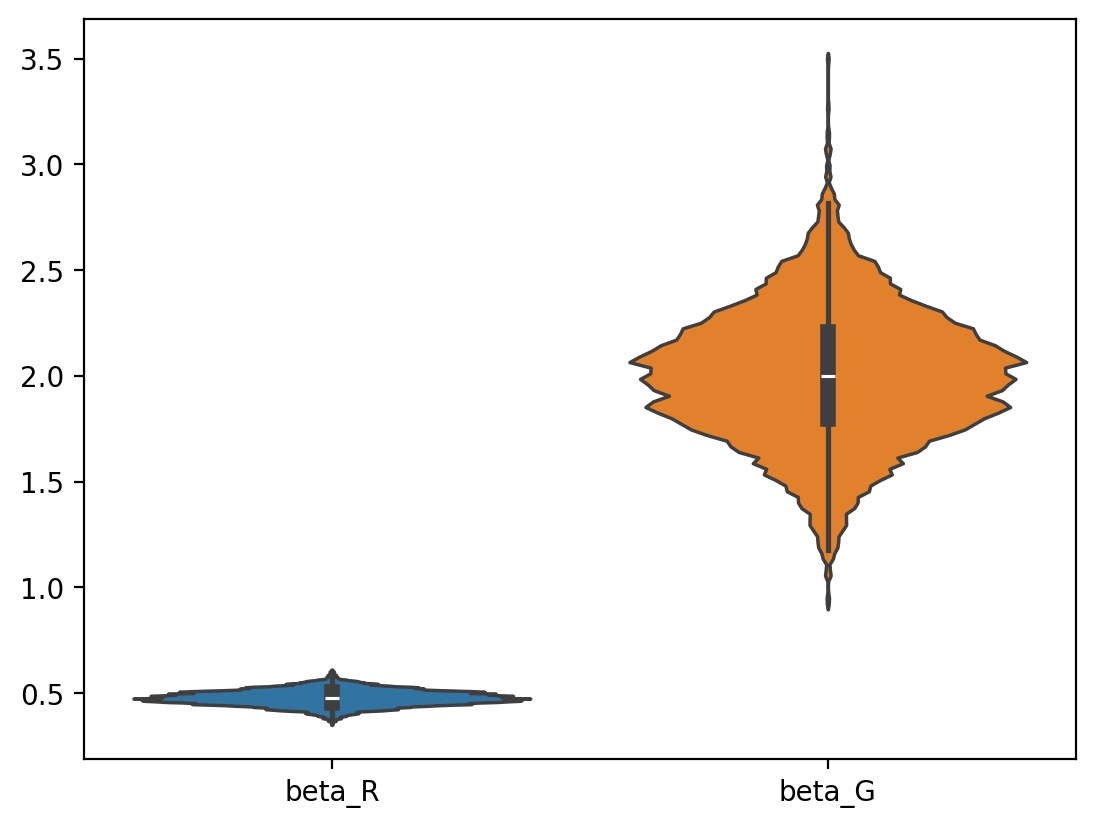

In [ ]:
sns.violinplot(data=model_project1_mcmc_samples[['beta_R', 'beta_G']])

As can be seen, the boxplots for both $\beta_R$ and $\beta_G$ are significantly above 0. Nevertheless, the median value for $\beta_G$ is considerably larger than for $\beta_R$. There is no significant evidence of conditional independence of CPI inflation with regard to the interest rate.

An important reason for the nonzero slope of $\beta_R$ is the cyclical relationship it has with CPI inflation; namely, while low interest rates (indirectly) bring about higher inflation, the increase in inflation induces the government to raise interest rates (as has happened in recent time). As such, we now try to change our MCMC model in order to eliminate this cyclicality behavior.

## Adding Time component

In order to avoid cyclicality and the counfounding error that arises from it, we strive to include another component to the model: that of time. For this purpose, we choose to take the CPI inflation values after several months' delay and compare them to the interest rate, in order to observe how past inflation trends influence current interest rates selected by the Federal Reserve. In this way, analyzing interest rates as the response variable versus past inflation rates should eliminate cyclicality and help establish not only the relationship between inflation and interest rates, but also the time delay contained within it.

For this purpose, we first create a new column in our dataframe, whose values are simply the CPI inflation values from *n* months previously (taking a variety of values of *n*). This column will be termed `Inf_Prev`.



In order to determine what the most appropriate time delay should be, we compare the correlation between the prime interest rate `DPRIME` and the past inflation rate `Inf_Prev` for different values of *n*, and take the *n*-value that corresponds to the highest such correlation.

In [ ]:
data_time = pd.DataFrame()

data_time['DPRIME']=data_all['DPRIME']


for n in range(1,21):
  data_time['Inf_Prev'+str(n)]=zeros(755)
  for i in range(n,756):
    data_time['Inf_Prev'+str(n)][i]=data_all['CPI.U'][i-n]
  print('n=', n, 'corr=', data_time[['Inf_Prev'+str(n), 'DPRIME']].corr())
  print('----------------')


n= 1 corr=            Inf_Prev1    DPRIME
Inf_Prev1   1.000000  0.463681
DPRIME      0.463681  1.000000
----------------
n= 2 corr=            Inf_Prev2    DPRIME
Inf_Prev2   1.000000  0.478138
DPRIME      0.478138  1.000000
----------------
n= 3 corr=            Inf_Prev3    DPRIME
Inf_Prev3   1.000000  0.478025
DPRIME      0.478025  1.000000
----------------
n= 4 corr=            Inf_Prev4    DPRIME
Inf_Prev4   1.000000  0.480192
DPRIME      0.480192  1.000000
----------------
n= 5 corr=            Inf_Prev5    DPRIME
Inf_Prev5   1.000000  0.476455
DPRIME      0.476455  1.000000
----------------
n= 6 corr=            Inf_Prev6   DPRIME
Inf_Prev6    1.00000  0.48132
DPRIME       0.48132  1.00000
----------------
n= 7 corr=            Inf_Prev7  DPRIME
Inf_Prev7     1.0000  0.4926
DPRIME        0.4926  1.0000
----------------
n= 8 corr=            Inf_Prev8    DPRIME
Inf_Prev8   1.000000  0.504722
DPRIME      0.504722  1.000000
----------------
n= 9 corr=            Inf_Prev9    DPRIME

As can be seen, the largest correlation is observed for $n=12$. This indicates that the interest rate has the best fit against the inflation rate with a 12-month (i.e. 1-year) delay.

To verify that this is indeed the case, we plot the interest rate versus the inflation rate with 12-month delay, which takes the form given below.

Text(0, 0.5, 'Inflation and Interest Rate')

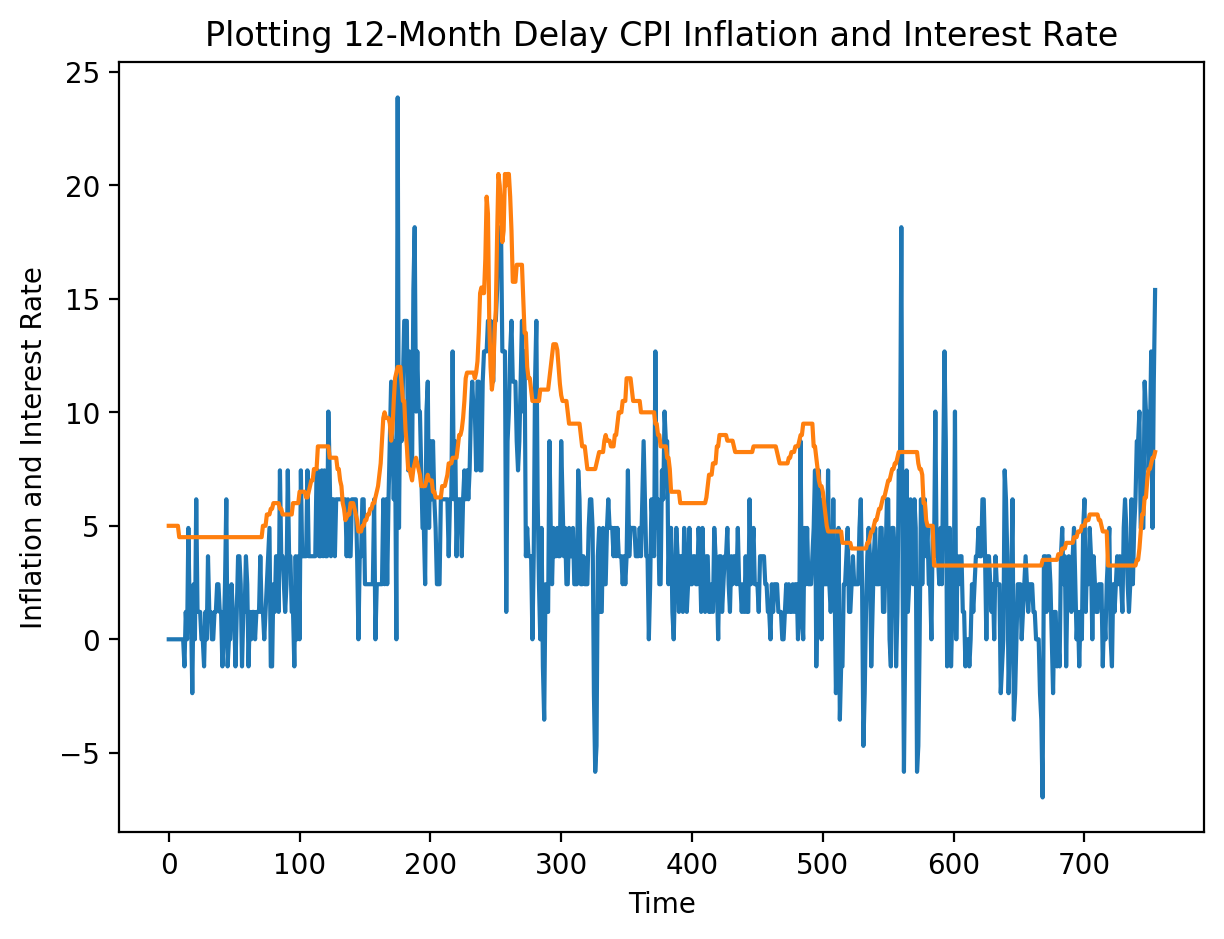

In [ ]:
figure(1, [7, 5])
plt.plot(data_time['Inf_Prev12'])
plt.plot(data_time['DPRIME'])
title('Plotting 12-Month Delay CPI Inflation and Interest Rate')
xlabel('Time')
ylabel('Inflation and Interest Rate')


This plot shows that the changes in interest rate (orange plot) match the 12-month-previous inflation data very well, indicating that there is an almost perfectly consistent 12-month delay from the onset of inflation to the beginning of interest rate changes. This is very interesting and (perhaps) unexpected, as we would expect government reaction times to differ considerably more than we observe here.

In [ ]:
data_all['Inf_Prev']=data_time['Inf_Prev12']
data_all

Date  BOGMBASE  Money Base Change  DPRIME       GDP  SPIndex  \
0    1960-01-01     50700           1.807229    5.00  0.878128  -0.0361   
1    1960-02-01     49600          -2.169625    5.00 -0.096411  -0.0108   
2    1960-03-01     49500          -0.201613    5.00 -0.096411   0.0158   
3    1960-04-01     49700           0.404040    5.00 -0.096411  -0.0062   
4    1960-05-01     49700           0.000000    5.00  0.277929   0.0399   
..          ...       ...                ...     ...       ...      ...   
750  2023-02-01   5321600          -0.138863    7.50  0.309099  -0.0259   
751  2023-03-01   5571500           4.695956    7.75  0.309099   0.0400   
752  2023-04-01   5593100           0.387687    8.00  0.309099   0.0060   
753  2023-05-01   5569600          -0.420161    8.00  0.685690   0.0480   
754  2023-06-01   5608500           0.698434    8.25  0.685690   0.0254   

          Oil     CPI.U  GoldChange   Inf_Prev  
0    0.000000 -1.193422         NaN   0.000000  
1    0.000000  1.206622         NaN   0.000000  
2    0.000000  0.000000         NaN   0.000000  
3    0.000000  4.907021         NaN   0.000000  
4    0.000000  1.206622         NaN   0.000000  
..        ...       ...         ...        ...  
750 -1.651306  4.907021    6.949104   8.731066  
751 -4.620591  1.206622   -5.825150  12.682503  
752  8.419760  4.907021    8.019392   4.907021  
753 -9.905601  1.206622   -0.103845  11.350967  
754 -1.858061  2.426577   -0.210399  15.389462  

[755 rows x 10 columns]

In this case, we proceed to test the interest rate as the response variable, and take the money supply change and time-delayed interest rate as predictor variables. As such, our new Directed Acyclic Graph takes the form:

In particular, this DAG indicates that the time-delayed inflation `Inf_Prev` has a direct influence on the prime interest rate, as central banks (including the Federal Reserve) respond to inflation by adjusting the prime interest rate. Furthermore, we also know that the money supply affects interest rate, as a tighter money market (Quantitative Tightening) brings about higher interest rates, while a looser money market (Quantitative Easing) brings about lower interest rates. However, we do not expect that the time-delayed inflation actually influences the money supply change.

In [ ]:
data_all['DPRIME'].mean()

7.0279867549668875

Examining the DAG above, we observe that an analysis of the interest rate as response variable would include both the time-delayed inflation `Inf_Prev` and the Money Supply change as influential variables.

In this case, we conduct MLR MCMC analysis of the prime interest rate `DPRIME` as response variable and time-delayed inflation `Inf_Prev` and Money Supply change as predictor variables.

For this, we observe that the mean of the prime interest rate is approximately 7.0, so we take the intercept $\alpha$ to have a mean of 7 and standard deviation of 2. Furthermore, we take a slightly wider distribution of $\sigma$. Because we do not know the nature of the relationship between inflation and interest rate and oil price, we take a prior of the $\beta$ estimates to be centered at 0, with standard deviation at 1.


Our Prior takes the form:

\begin{align*}
    DPRIME_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{I}(I_{i}-\bar{I}) + \beta_{M}(M_{i}-\bar{M})\\
    \alpha &\sim \text{Normal}(7, 2) \\
    \beta_{I} &\sim \text{Normal}(0, 1) \\
    \beta_{M} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $I_i$ denotes the time-delayed inflation rate, and $M_i$ is the money supply change.

In [ ]:
with pm.Model() as model_project_time1:
    sigma = pm.Exponential('sigma', 0.5)
    beta_M = pm.Normal('beta_M', mu=0, sigma=1)
    beta_I = pm.Normal('beta_I', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=7, sigma=2)
    _mu = (alpha + beta_M*(data_all['Money Base Change']-data_all['Money Base Change'].mean())
        + beta_I*(data_all['Inf_Prev']-data_all['Inf_Prev'].mean()))
    mu = pm.Deterministic('mu', _mu)
    DPRIME = pm.Normal('DPRIME', mu=mu, sigma=sigma, observed=data_all['DPRIME'])
    _model_project_time1_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_project_time1_mcmc_samples = _model_project_time1_mcmc_samples.posterior.to_dataframe()
model_project_time1_mcmc_samples

alpha    beta_I    beta_M         mu     sigma
chain draw mu_dim_0                                                   
0     0    0         7.067656  0.486583  0.004089   5.197958  2.741105
           1         7.067656  0.486583  0.004089   5.181697  2.741105
           2         7.067656  0.486583  0.004089   5.189744  2.741105
           3         7.067656  0.486583  0.004089   5.192220  2.741105
           4         7.067656  0.486583  0.004089   5.190568  2.741105
...                       ...       ...       ...        ...       ...
3     999  750       7.170799  0.461392  0.009612   9.415124  2.803925
           751       7.170799  0.461392  0.009612  11.284760  2.803925
           752       7.170799  0.461392  0.009612   7.655801  2.803925
           753       7.170799  0.461392  0.009612  10.621222  2.803925
           754       7.170799  0.461392  0.009612  12.495305  2.803925

[3020000 rows x 5 columns]

<Axes: >

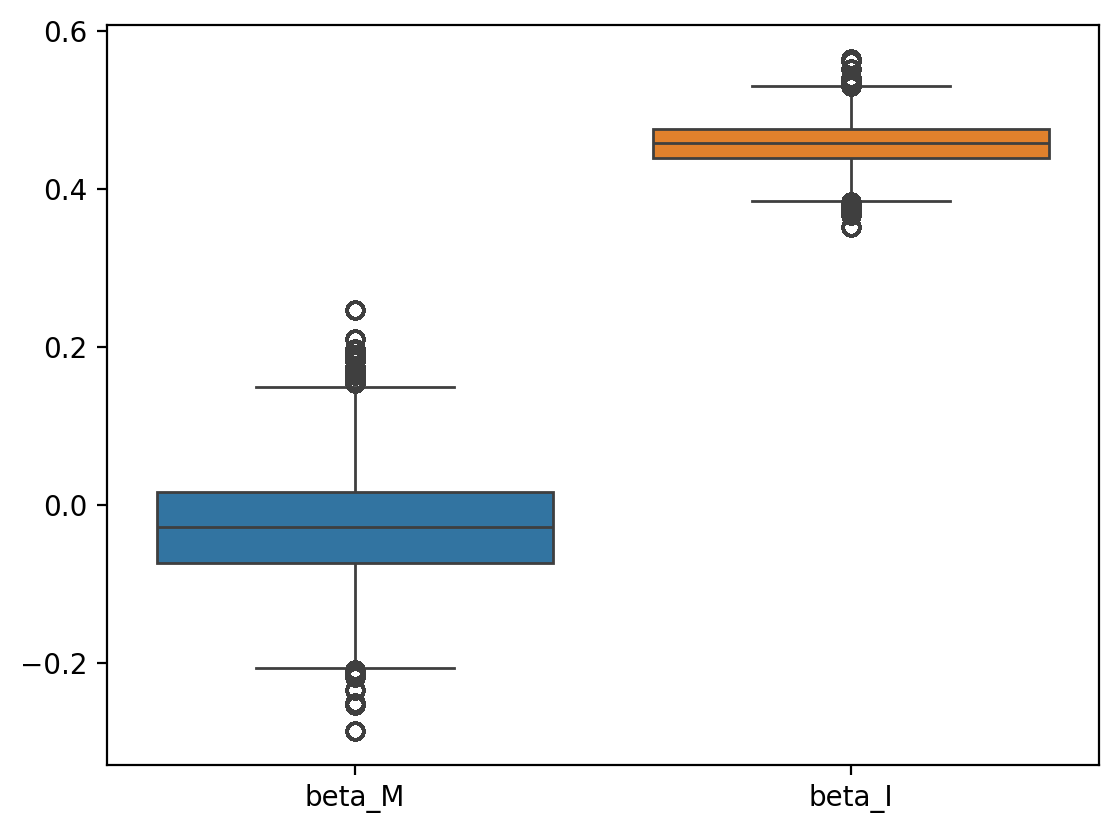

In [ ]:
sns.boxplot(data=model_project_time1_mcmc_samples[['beta_M', 'beta_I']])

As can be seen, there is a *strongly* significant correlation between time-delayed inflation and the prime interest rate, but there is no significant (linear) correlation between prime interest rate and the money supply change.  

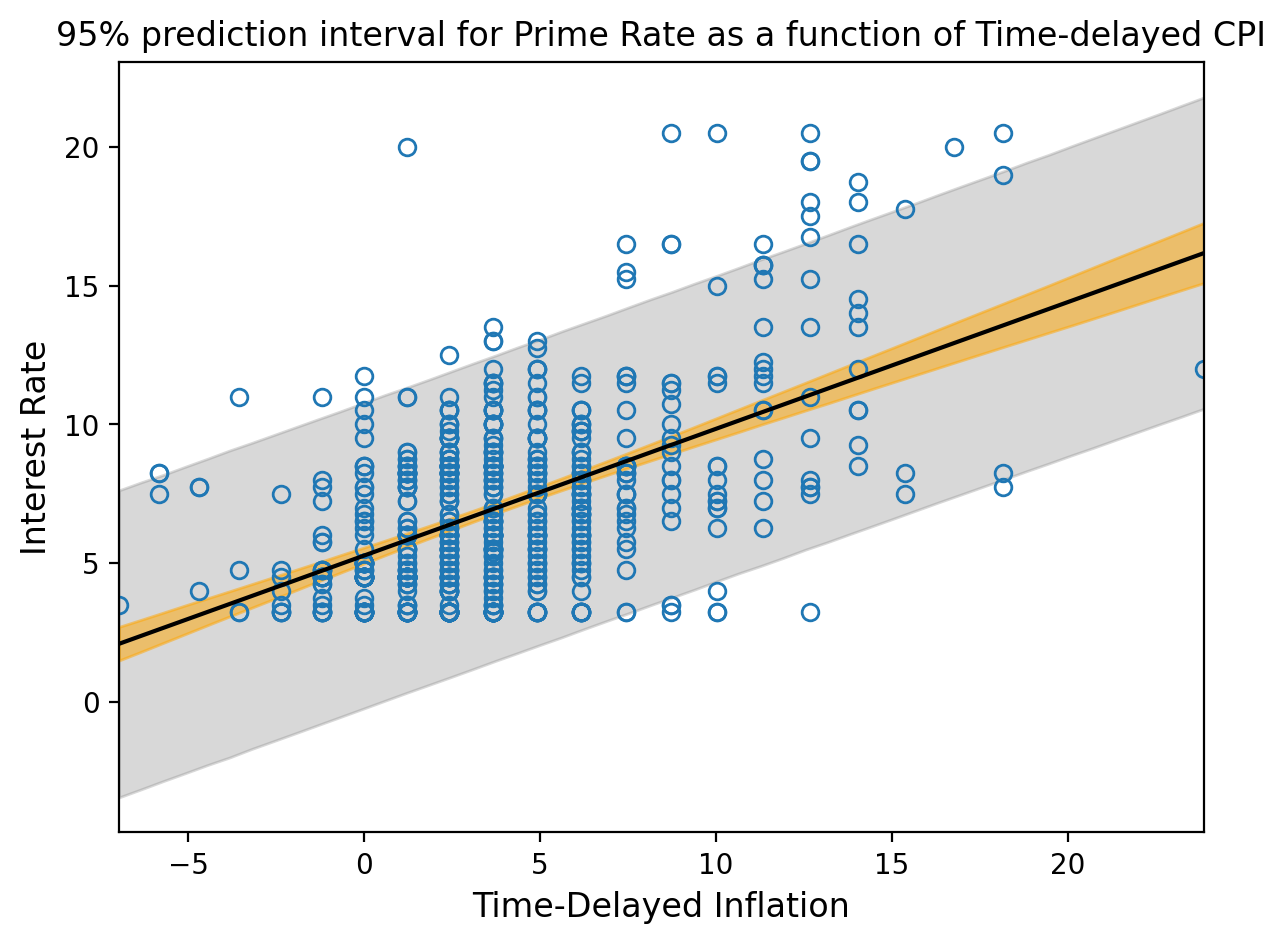

In [ ]:
## Prediction plot for DPRIME vs CPI, holding MS at mean:

prob = 0.95 ## for credible intervals

xmin = data_all['Inf_Prev'].min()
xmax = data_all['Inf_Prev'].max()
xmean = data_all['Inf_Prev'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_project_time1_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_project_time1_mcmc_samples['beta_I'])[None, :]
sigma_samples = array(model_project_time1_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_all['Inf_Prev'], data_all['DPRIME'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Prime Rate as a function of Time-delayed CPI')
xlabel('Time-Delayed Inflation', fontsize=12)
ylabel('Interest Rate', fontsize=12);

As can be seen, the regression fit between DPRIME and time-delayed Inflation shows no visible nonlinear trends. As such, we conclude that our linearity assumption on the relationship between time-delayed inflation and interest rate is reasonable.

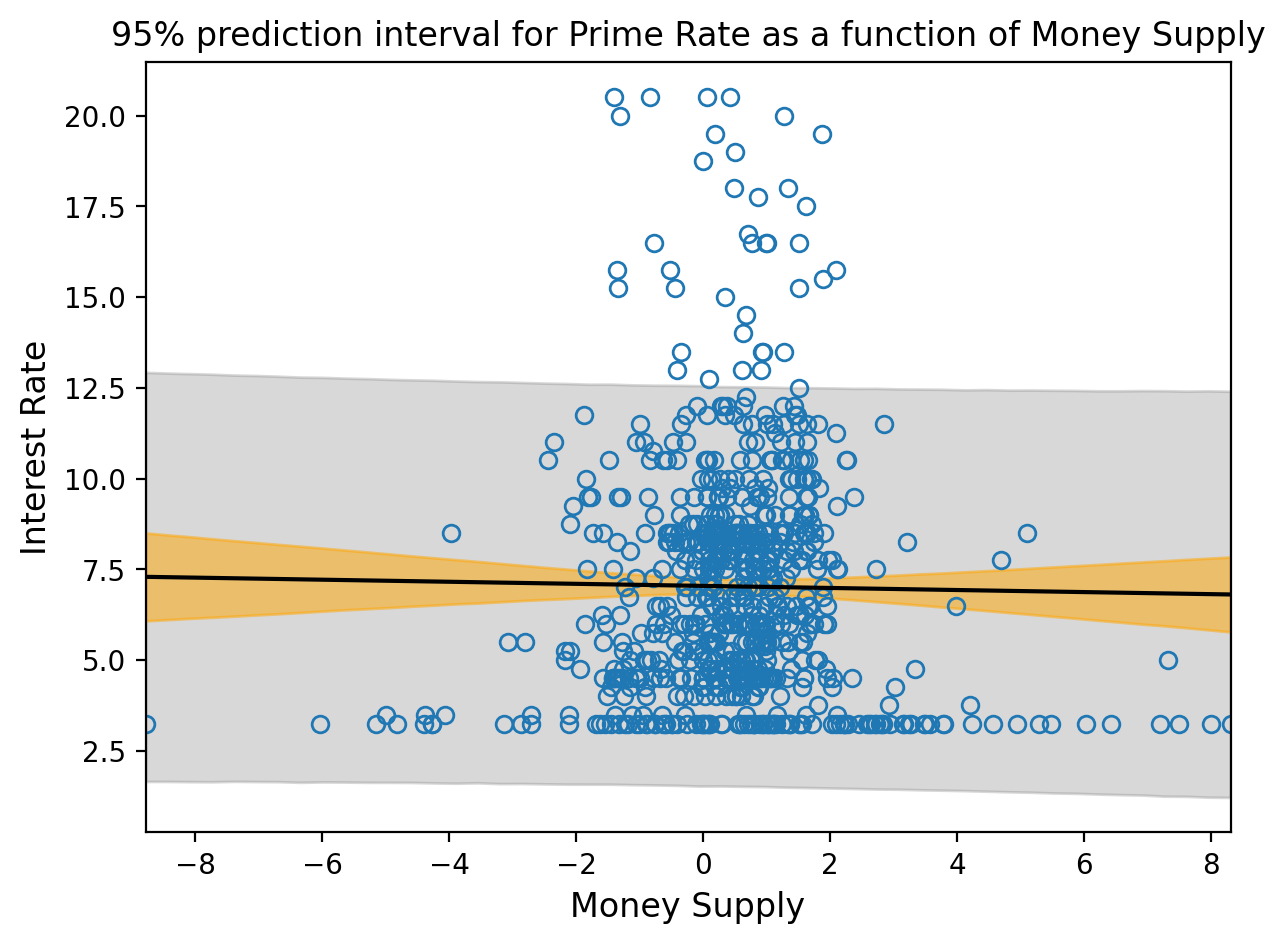

In [ ]:
## Prediction plot for DPRIME vs CPI, holding MS at mean:

prob = 0.95 ## for credible intervals

xmin = data_all['Money Base Change'].min()
xmax = data_all['Money Base Change'].max()
xmean = data_all['Money Base Change'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_project_time1_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_project_time1_mcmc_samples['beta_M'])[None, :]
sigma_samples = array(model_project_time1_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_all['Money Base Change'], data_all['DPRIME'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Prime Rate as a function of Money Supply')
xlabel('Money Supply', fontsize=12)
ylabel('Interest Rate', fontsize=12);

In [ ]:
mean_I, mean_M = model_project_time1_mcmc_samples[['beta_I', 'beta_M']].mean()

print('mean_I (Overall)=', mean_I)
print('----------')
print('mean_M (Overall)=', mean_M)

mean_I (Overall)= 0.4567431569159073
----------
mean_M (Overall)= -0.02844836385425011


From the Credibility Interval plot for Interest Rate vs Money Supply above, we observe a clear nonlinear (in fact, possibly parabolic) trend to the data. As such, we proceed to conduct a nonlinear MCMC analysis of the interest rate data versus time-delayed inflation and money supply. For this, our prior now takes the form:
\begin{align*}
    DPRIME_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{I}(I_{i}-\bar{I}) + \beta_{M}(M_{i}-\bar{M})+ \beta_{M2}(M_{i}-\bar{M})^2\\
    \alpha &\sim \text{Normal}(7, 2) \\
    \beta_{I} &\sim \text{Normal}(0, 1) \\
    \beta_{M} &\sim \text{Normal}(0, 1) \\
    \beta_{M2} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $I_i$ denotes the time-delayed inflation rate, and $M_i$ is the money supply change.

In [ ]:
with pm.Model() as model_project_time2:
    sigma = pm.Exponential('sigma', 0.5)
    beta_M = pm.Normal('beta_M', mu=0, sigma=1)
    beta_M2 = pm.Normal('beta_M2', mu=0, sigma=1)
    beta_I = pm.Normal('beta_I', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=7, sigma=2)
    _mu = (alpha + beta_M*(data_all['Money Base Change']-data_all['Money Base Change'].mean())
        + beta_M2*(data_all['Money Base Change']-data_all['Money Base Change'].mean())**2
        + beta_I*(data_all['Inf_Prev']-data_all['Inf_Prev'].mean()))
    mu = pm.Deterministic('mu', _mu)
    DPRIME = pm.Normal('DPRIME', mu=mu, sigma=sigma, observed=data_all['DPRIME'])
    _model_project_time2_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_project_time2_mcmc_samples = _model_project_time2_mcmc_samples.posterior.to_dataframe()
model_project_time2_mcmc_samples

alpha    beta_I    beta_M   beta_M2         mu  \
chain draw mu_dim_0                                                      
0     0    0         7.402706  0.412363  0.015940 -0.106161   5.653476   
           1         7.402706  0.412363  0.015940 -0.106161   5.013678   
           2         7.402706  0.412363  0.015940 -0.106161   5.749993   
           3         7.402706  0.412363  0.015940 -0.106161   5.811114   
           4         7.402706  0.412363  0.015940 -0.106161   5.778987   
...                       ...       ...       ...       ...        ...   
3     999  750       7.145424  0.432231 -0.030503 -0.093067   9.235041   
           751       7.145424  0.432231 -0.030503 -0.093067   9.196234   
           752       7.145424  0.432231 -0.030503 -0.093067   7.603063   
           753       7.145424  0.432231 -0.030503 -0.093067  10.335133   
           754       7.145424  0.432231 -0.030503 -0.093067  12.122010   

                        sigma  
chain draw mu_dim_0            
0     0    0         2.744536  
           1         2.744536  
           2         2.744536  
           3         2.744536  
           4         2.744536  
...                       ...  
3     999  750       2.696372  
           751       2.696372  
           752       2.696372  
           753       2.696372  
           754       2.696372  

[3020000 rows x 6 columns]

<Axes: >

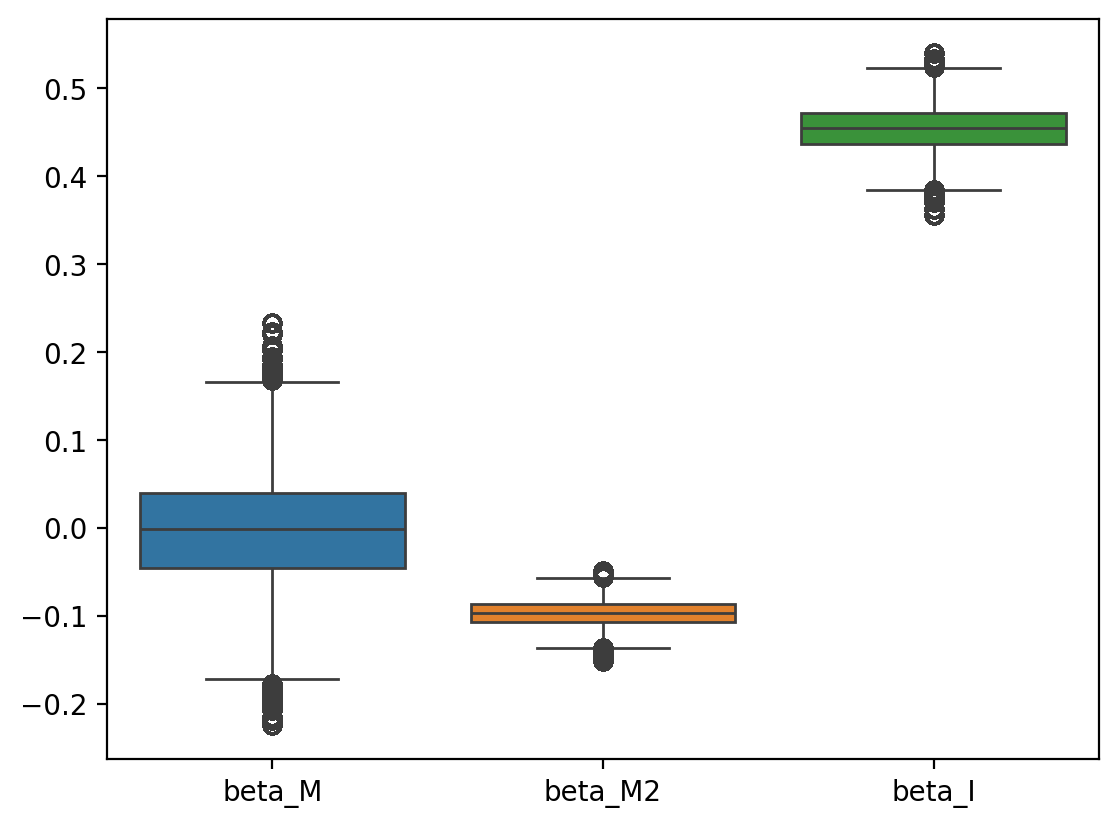

In [ ]:
sns.boxplot(data=model_project_time2_mcmc_samples[['beta_M', 'beta_M2', 'beta_I']])

Interestingly, as can be seen, the $\beta_M$ parameter is extremely well-centered on 0, but the $\beta_{M2}$ parameter (for the quadratic component) is significantly negative, as we anticipated. This indicates that the relationship between money supply and interest rate is quadratic in nature. There was very little observable change in the $\beta_I$ (inflation) parameter estimate, which remained significant.
This reinforces the indication that inflation operates relatively independently of the money supply change month-on-month.

<Axes: >

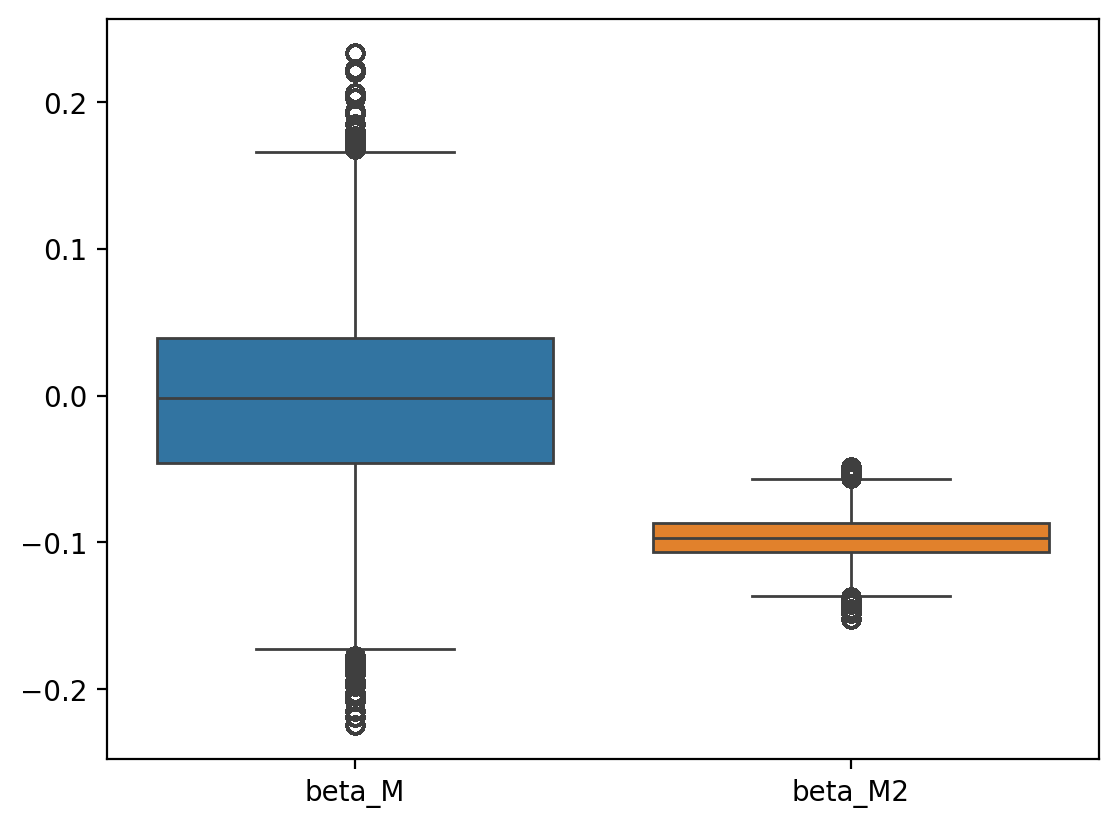

In [ ]:
sns.boxplot(data=model_project_time2_mcmc_samples[['beta_M', 'beta_M2']])
# sns.boxplot(data=model_project_time2_mcmc_samples[['beta_M2']])

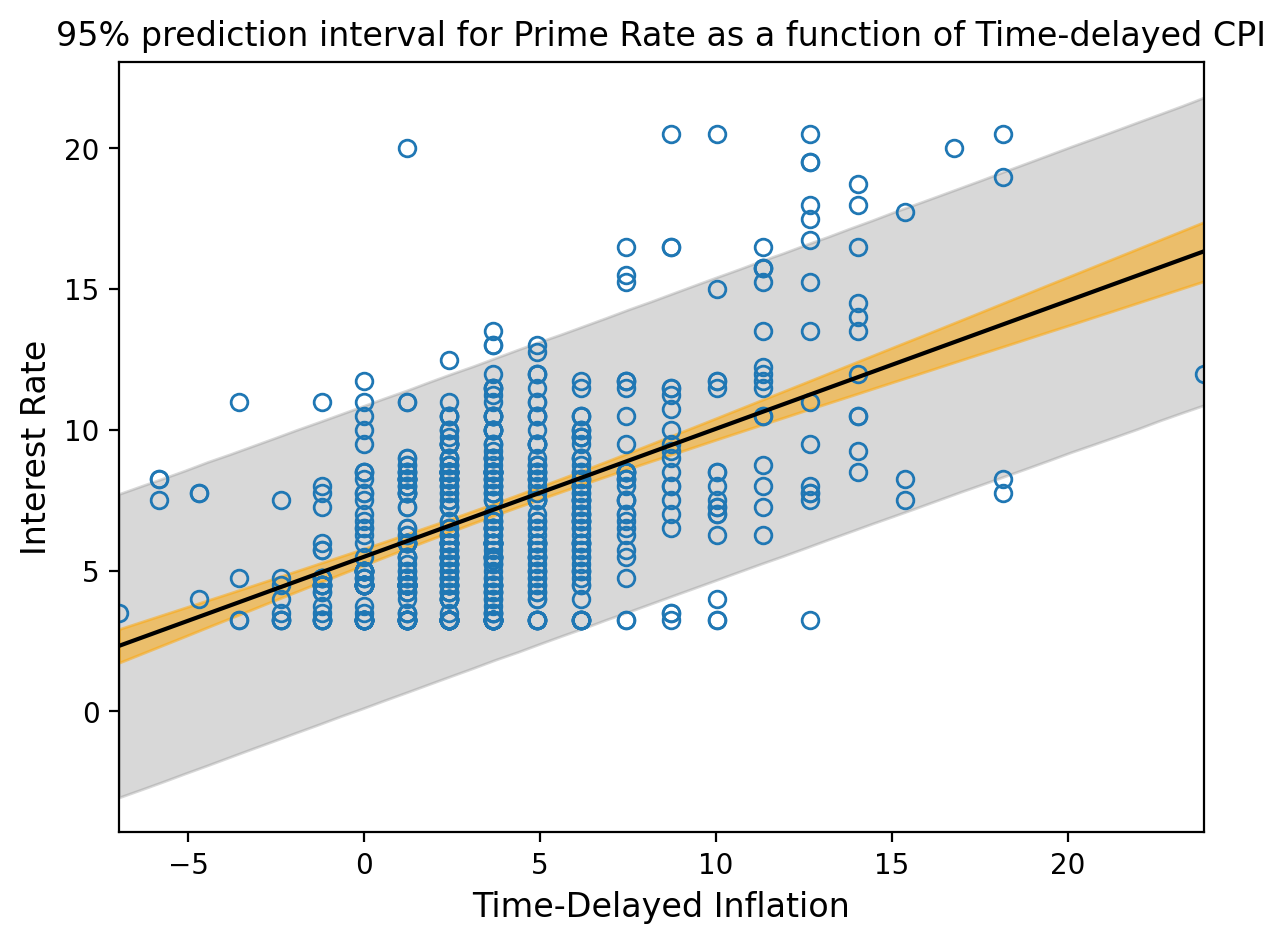

In [ ]:
## Prediction plot for DPRIME vs time-delayed CPI, holding MS at mean:

prob = 0.95 ## for credible intervals

xmin = data_all['Inf_Prev'].min()
xmax = data_all['Inf_Prev'].max()
xmean = data_all['Inf_Prev'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_project_time2_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_project_time2_mcmc_samples['beta_I'])[None, :]
sigma_samples = array(model_project_time2_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_all['Inf_Prev'], data_all['DPRIME'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Prime Rate as a function of Time-delayed CPI')
xlabel('Time-Delayed Inflation', fontsize=12)
ylabel('Interest Rate', fontsize=12);

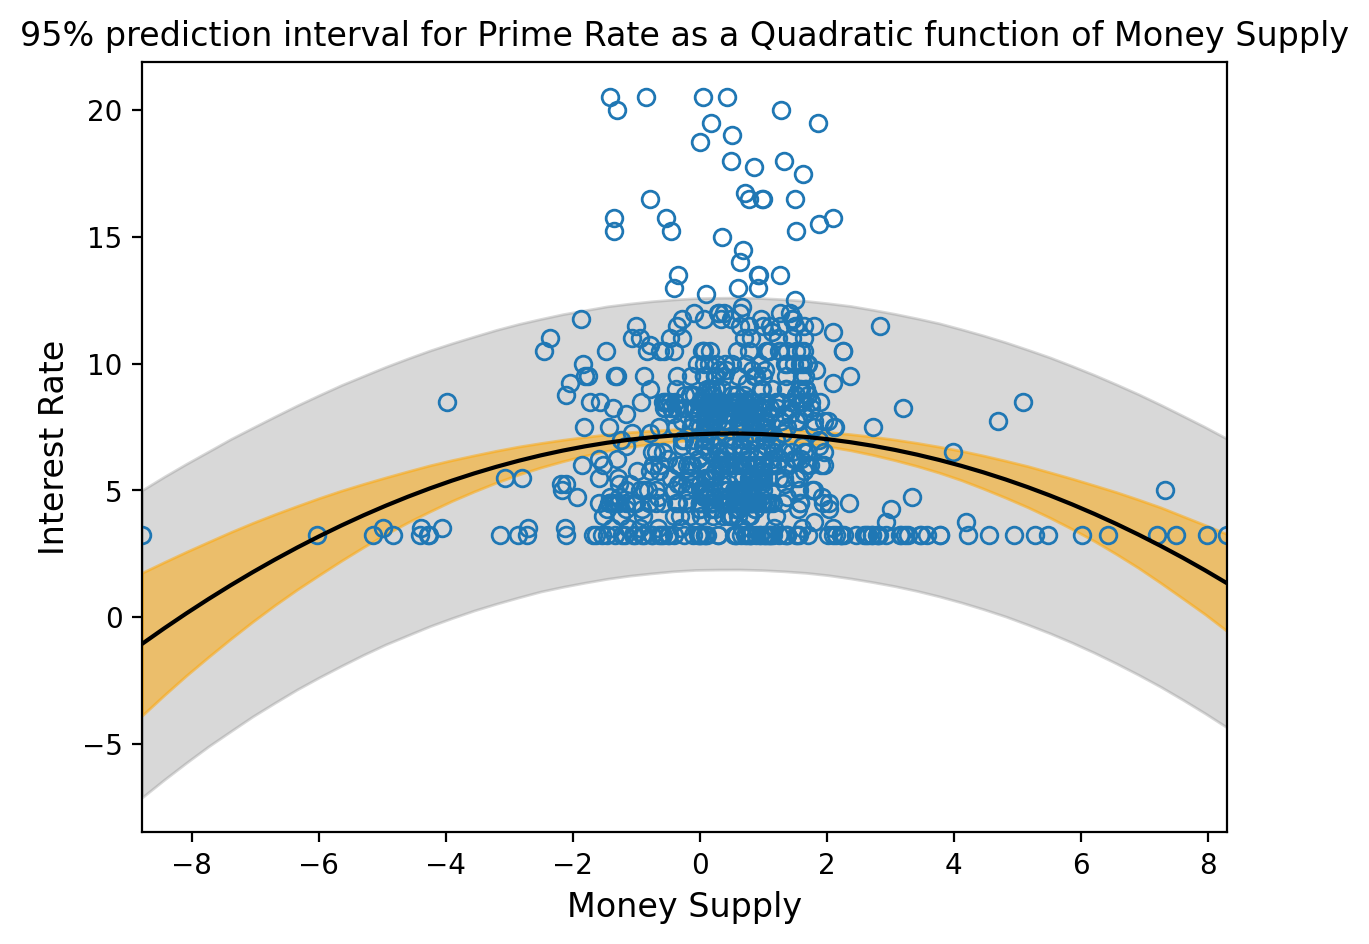

In [ ]:
## Prediction plot for DPRIME vs quadratic MS, time-delayed CPI at mean:

prob = 0.95 ## for credible intervals

xmin = data_all['Money Base Change'].min()
xmax = data_all['Money Base Change'].max()
xmean = data_all['Money Base Change'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_project_time2_mcmc_samples['alpha'])[None, :]
beta1_samples = array(model_project_time2_mcmc_samples['beta_M'])[None, :]
beta2_samples = array(model_project_time2_mcmc_samples['beta_M2'])[None, :]
sigma_samples = array(model_project_time2_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta1_samples.mean()*(x - xmean) + beta2_samples.mean()*(x - xmean)**2

#### collect samples of the average height
mu_samples = alpha_samples + beta1_samples*(x[:, None] - xmean)+beta2_samples*(x[:, None] - xmean)**2
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_all['Money Base Change'], data_all['DPRIME'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Prime Rate as a Quadratic function of Money Supply')
xlabel('Money Supply', fontsize=12)
ylabel('Interest Rate', fontsize=12);

## Exponential Regression:

Although the quadratic regression fit of money supply to interest rate had an acceptable fit, the endpoints did not perform very well because the interest rate is always kept positive. As such, we now wish to investigate another possible nonlinear fit of money supply to interest rate, which should approximate a bell curve with a better fit to the data. For this purpose, we take the following prior:

 \begin{align*}
    DPRIME_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{I}(I_{i}-\bar{I}) + \beta_{M}e^{-S|M_{i}-\bar{M}|}\\
    \alpha &\sim \text{Normal}(7, 2) \\
    \beta_{I} &\sim \text{Normal}(0, 1) \\
    \beta_{M} &\sim \text{Normal}(0, 1) \\
    S &\sim \text{Exponential}(1.0) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $I_i$ denotes the time-delayed inflation rate, and $M_i$ is the money supply change.

  Note that, in this case, when the money supply change is at the mean ($M_{i}=\bar{M}$), the intercept of DPRIME mean versus time-delayed inflation is actually $\alpha+\beta_{M}$.

In [ ]:
with pm.Model() as model_project_time3:
    sigma = pm.Exponential('sigma', 0.5)
    beta_M = pm.Normal('beta_M', mu=0, sigma=1)
    beta_I = pm.Normal('beta_I', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=7, sigma=2)
    S = pm.Exponential('S', 1.0)
    _mu = (alpha + beta_M * np.exp(-S * np.abs(data_all['Money Base Change']-data_all['Money Base Change'].mean())) + beta_I*(data_all['Inf_Prev']-data_all['Inf_Prev'].mean()))
    mu = pm.Deterministic('mu', _mu)
    DPRIME = pm.Normal('DPRIME', mu=mu, sigma=sigma, observed=data_all['DPRIME'])
    _model_project_time3_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_project_time3_mcmc_samples = _model_project_time3_mcmc_samples.posterior.to_dataframe()
model_project_time3_mcmc_samples

S     alpha    beta_I    beta_M         mu  \
chain draw mu_dim_0                                                      
0     0    0         0.223108  5.242189  0.469475  2.314794   5.162848   
           1         0.223108  5.242189  0.469475  2.314794   4.708634   
           2         0.223108  5.242189  0.469475  2.314794   5.411821   
           3         0.223108  5.242189  0.469475  2.314794   5.698107   
           4         0.223108  5.242189  0.469475  2.314794   5.502860   
...                       ...       ...       ...       ...        ...   
3     999  750       0.331065  5.665293  0.509275  2.002569   9.769362   
           751       0.331065  5.665293  0.509275  2.002569  10.661157   
           752       0.331065  5.665293  0.509275  2.002569   8.130388   
           753       0.331065  5.665293  0.509275  2.002569  10.959554   
           754       0.331065  5.665293  0.509275  2.002569  13.416420   

                        sigma  
chain draw mu_dim_0            
0     0    0         2.817836  
           1         2.817836  
           2         2.817836  
           3         2.817836  
           4         2.817836  
...                       ...  
3     999  750       2.782571  
           751       2.782571  
           752       2.782571  
           753       2.782571  
           754       2.782571  

[3020000 rows x 6 columns]

<Axes: >

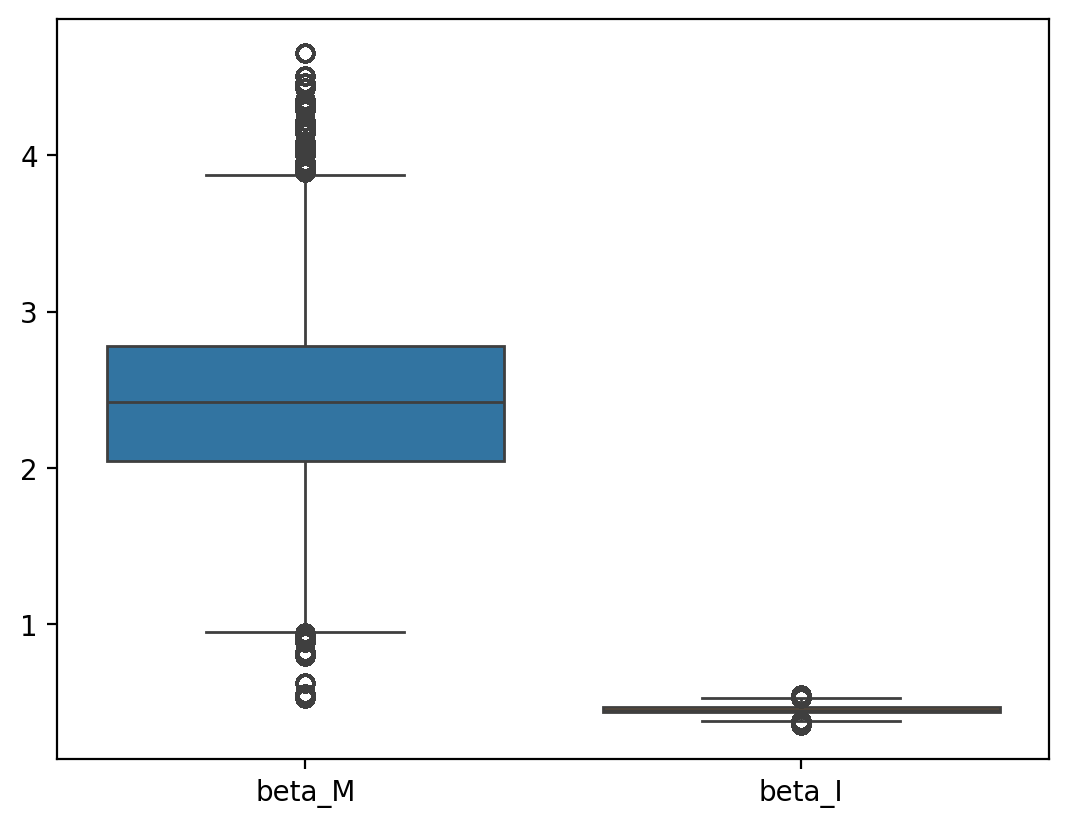

In [ ]:
sns.boxplot(data=model_project_time3_mcmc_samples[['beta_M', 'beta_I']])

<Axes: >

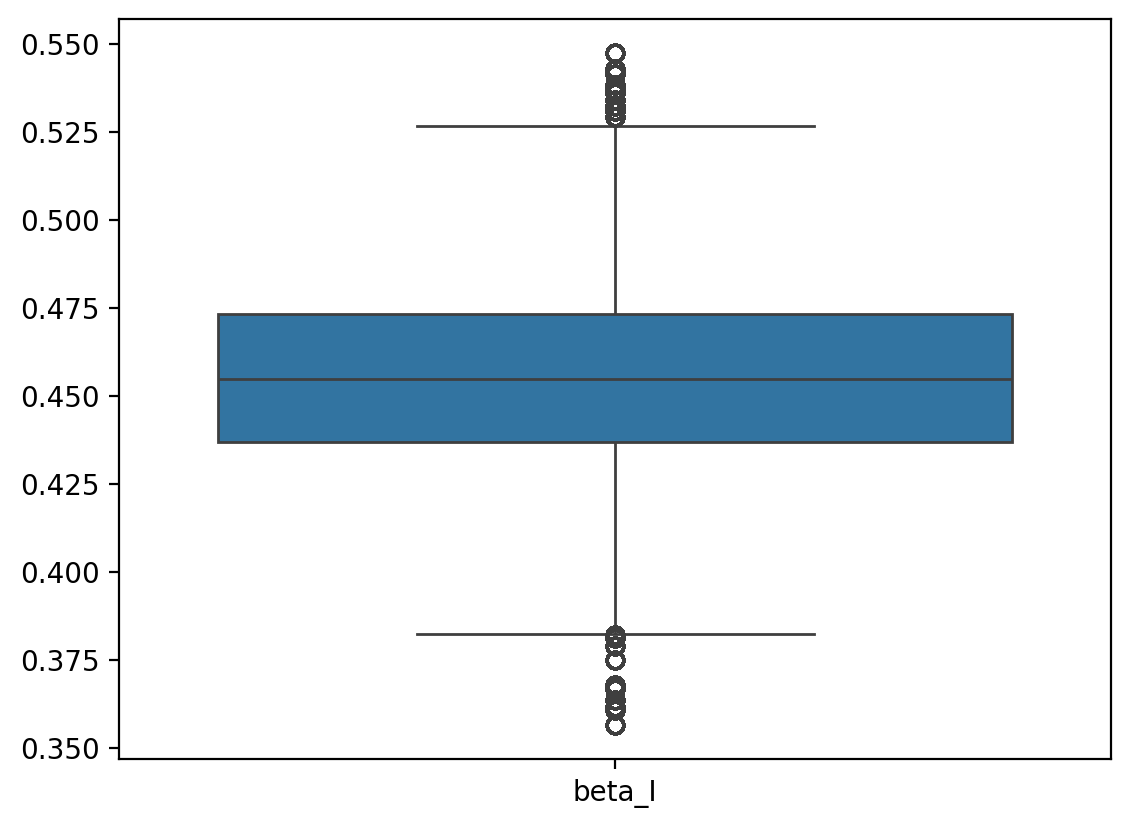

In [ ]:
sns.boxplot(data=model_project_time3_mcmc_samples[['beta_I']])

Note that, in this case, when the money supply change is at the mean ($M_{i}=\bar{M}$), the intercept of DPRIME mean versus time-delayed inflation is actually $\alpha+\beta_{M}$.

As such, in order to check this prediction, we also construct the boxplot for $\alpha$, which should be lower than what we expected originally. This is indeed the case.

<Axes: >

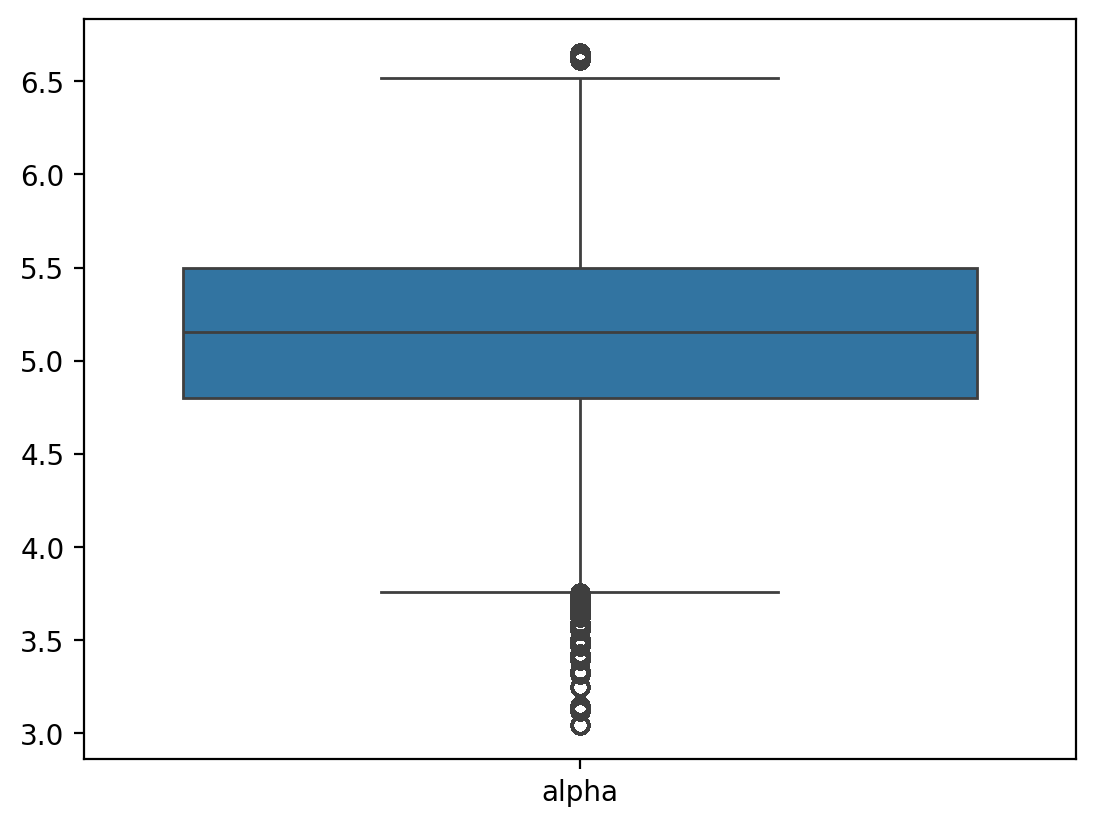

In [ ]:
sns.boxplot(data=model_project_time3_mcmc_samples[['alpha']])

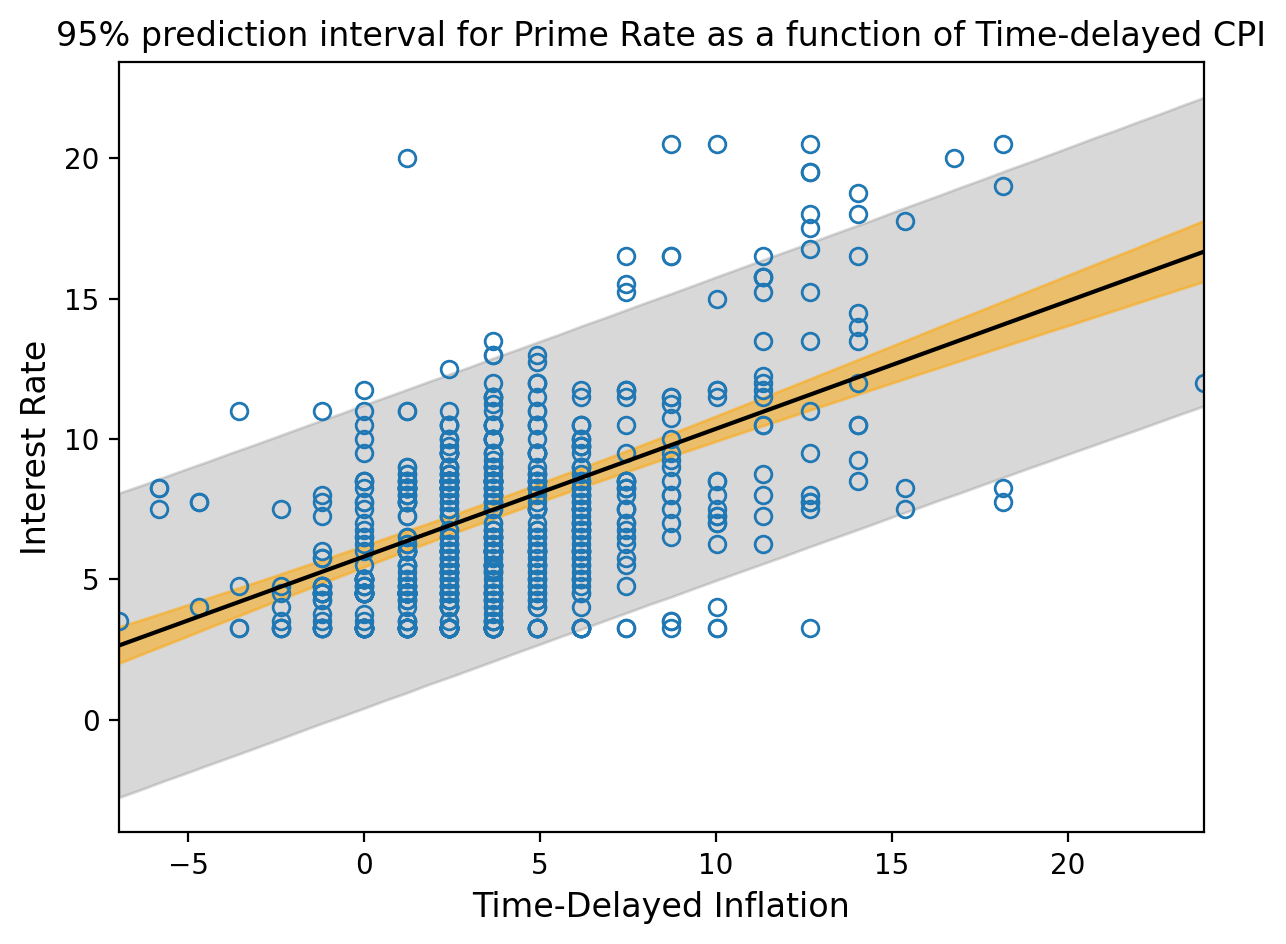

In [ ]:
prob = 0.95 ## for credible intervals

xmin = data_all['Inf_Prev'].min()
xmax = data_all['Inf_Prev'].max()
xmean = data_all['Inf_Prev'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_project_time3_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_project_time3_mcmc_samples['beta_I'])[None, :]
betaM_samples = array(model_project_time3_mcmc_samples['beta_M'])[None, :]
sigma_samples = array(model_project_time3_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + betaM_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + betaM_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_all['Inf_Prev'], data_all['DPRIME'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Prime Rate as a function of Time-delayed CPI')
xlabel('Time-Delayed Inflation', fontsize=12)
ylabel('Interest Rate', fontsize=12);

As can be seen, the regression fit between DPRIME and time-delayed Inflation is relatively unchanged from previous analyses, and shows no visible nonlinear trends. As such, we conclude that our linearity assumption on the relationship between time-delayed inflation and interest rate is (still) reasonable.



Plotting the 95% credibility interval plot for the interest rate versus the exponential regression money supply, we obtain the following plot:  

In [ ]:
def plot_prediction_intervals_corrected(x, xmean, alpha_samples, beta_samples, S_samples, sigma_samples, data_x, data_y, title_text, xlabel_text):
    N_weight = len(x)

    # Compute mean values
    # mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)
    # mu_samples = alpha_samples[:, None] + beta_samples[:, None]*(x - xmean)

    N_posterior_samples = alpha_samples.size
    prob = 0.95

    #### the mean posterior average height
    mu_avg = alpha_samples.mean() + beta_samples.mean()*exp(-S_samples.mean()*abs(x - xmean))

    #### collect samples of the average height
    mu_samples = alpha_samples + beta_samples*exp(-S_samples*abs(x[:, None] - xmean))
    ## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
    mu_samples_sorted = sort(mu_samples, axis=1)
    index = int(N_posterior_samples*(1 - prob)/2)
    mu_lower = mu_samples_sorted[:, index]
    mu_upper = mu_samples_sorted[:, -index]

    #### Sample the posterior prediction height
    h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
    ## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
    h_samples_sorted = sort(h_samples, axis=1)
    index = int(N_posterior_samples*(1 - prob)/2)
    h_lower = h_samples_sorted[:, index]
    h_upper = h_samples_sorted[:, -index]
    plt.fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
    plt.fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
    plt.plot(data_x, data_y, 'o', mfc='none')
    plt.plot(x, mu_avg, 'k')
    plt.title(title_text)
    plt.xlabel(xlabel_text, fontsize=12)
    plt.ylabel('Inflation', fontsize=12)

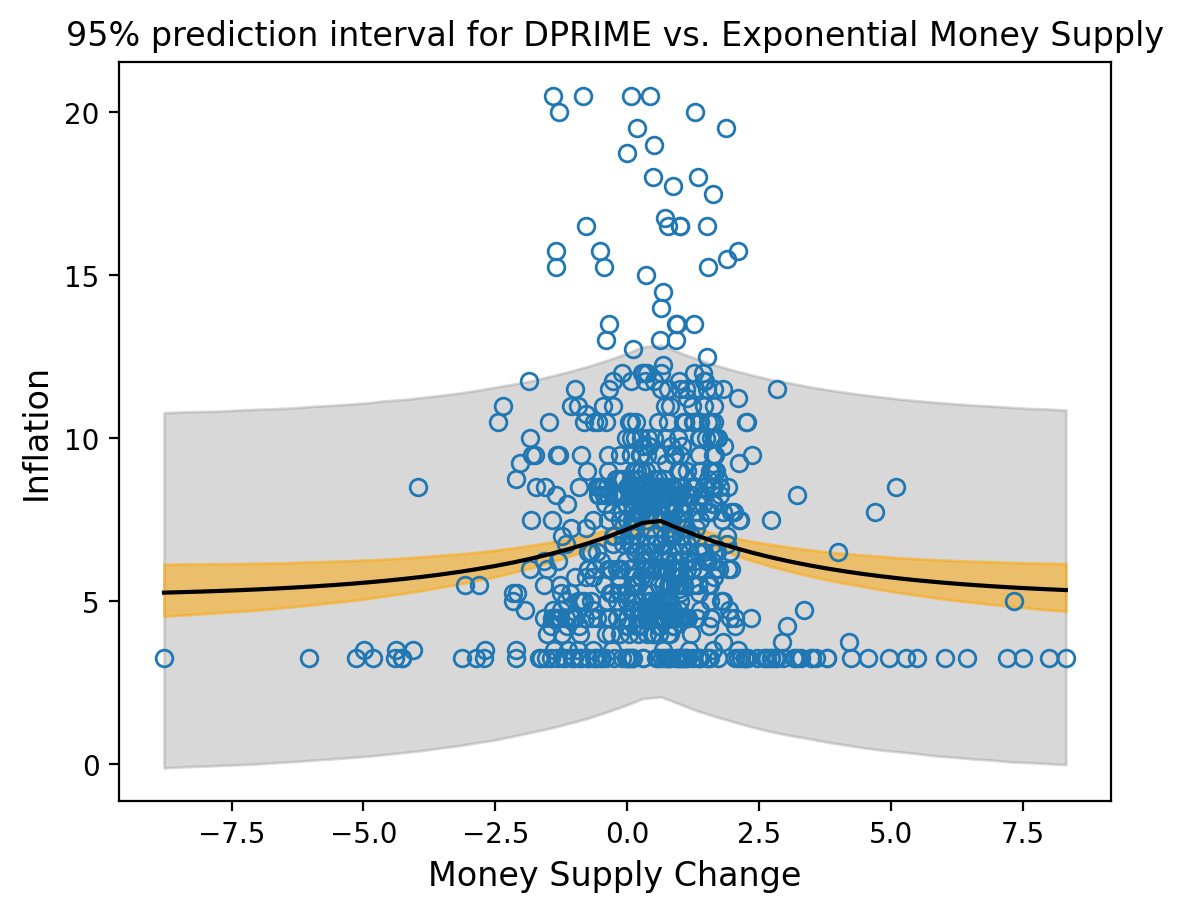

In [ ]:
xmin, xmax, xmean = data_all['Money Base Change'].min(), data_all['Money Base Change'].max(), data_all['Money Base Change'].mean()
x = linspace(xmin, xmax, 50)
plot_prediction_intervals_corrected(x, xmean, array(model_project_time3_mcmc_samples['alpha'])[None, :],
        array(model_project_time3_mcmc_samples['beta_M'])[None, :], array(model_project_time3_mcmc_samples['S'])[None, :],
        array(model_project_time3_mcmc_samples['sigma'])[None, :],
        data_all['Money Base Change'], data_all['DPRIME'], '95% prediction interval for DPRIME vs. Exponential Money Supply', 'Money Supply Change')
plt.show()

# Studying different Inflation regimes:

In [ ]:
data_all

Date  BOGMBASE  Money Base Change  DPRIME       GDP  SPIndex  \
0    1960-01-01     50700           1.807229    5.00  0.878128  -0.0361   
1    1960-02-01     49600          -2.169625    5.00 -0.096411  -0.0108   
2    1960-03-01     49500          -0.201613    5.00 -0.096411   0.0158   
3    1960-04-01     49700           0.404040    5.00 -0.096411  -0.0062   
4    1960-05-01     49700           0.000000    5.00  0.277929   0.0399   
..          ...       ...                ...     ...       ...      ...   
750  2023-02-01   5321600          -0.138863    7.50  0.309099  -0.0259   
751  2023-03-01   5571500           4.695956    7.75  0.309099   0.0400   
752  2023-04-01   5593100           0.387687    8.00  0.309099   0.0060   
753  2023-05-01   5569600          -0.420161    8.00  0.685690   0.0480   
754  2023-06-01   5608500           0.698434    8.25  0.685690   0.0254   

          Oil     CPI.U  GoldChange   Inf_Prev  
0    0.000000 -1.193422         NaN   0.000000  
1    0.000000  1.206622         NaN   0.000000  
2    0.000000  0.000000         NaN   0.000000  
3    0.000000  4.907021         NaN   0.000000  
4    0.000000  1.206622         NaN   0.000000  
..        ...       ...         ...        ...  
750 -1.651306  4.907021    6.949104   8.731066  
751 -4.620591  1.206622   -5.825150  12.682503  
752  8.419760  4.907021    8.019392   4.907021  
753 -9.905601  1.206622   -0.103845  11.350967  
754 -1.858061  2.426577   -0.210399  15.389462  

[755 rows x 10 columns]

In [ ]:
data_low = data_all[data_all['CPI.U']<=5]
data_low

Date  BOGMBASE  Money Base Change  DPRIME       GDP  SPIndex  \
0    1960-01-01     50700           1.807229    5.00  0.878128  -0.0361   
1    1960-02-01     49600          -2.169625    5.00 -0.096411  -0.0108   
2    1960-03-01     49500          -0.201613    5.00 -0.096411   0.0158   
3    1960-04-01     49700           0.404040    5.00 -0.096411  -0.0062   
4    1960-05-01     49700           0.000000    5.00  0.277929   0.0399   
..          ...       ...                ...     ...       ...      ...   
750  2023-02-01   5321600          -0.138863    7.50  0.309099  -0.0259   
751  2023-03-01   5571500           4.695956    7.75  0.309099   0.0400   
752  2023-04-01   5593100           0.387687    8.00  0.309099   0.0060   
753  2023-05-01   5569600          -0.420161    8.00  0.685690   0.0480   
754  2023-06-01   5608500           0.698434    8.25  0.685690   0.0254   

          Oil     CPI.U  GoldChange   Inf_Prev  
0    0.000000 -1.193422         NaN   0.000000  
1    0.000000  1.206622         NaN   0.000000  
2    0.000000  0.000000         NaN   0.000000  
3    0.000000  4.907021         NaN   0.000000  
4    0.000000  1.206622         NaN   0.000000  
..        ...       ...         ...        ...  
750 -1.651306  4.907021    6.949104   8.731066  
751 -4.620591  1.206622   -5.825150  12.682503  
752  8.419760  4.907021    8.019392   4.907021  
753 -9.905601  1.206622   -0.103845  11.350967  
754 -1.858061  2.426577   -0.210399  15.389462  

[564 rows x 10 columns]

In [ ]:
data_high = data_all[data_all['CPI.U']>5]
data_high

Date  BOGMBASE  Money Base Change  DPRIME       GDP  SPIndex  \
9    1960-10-01     50100           0.400802    4.50 -0.331435   0.0354   
32   1962-09-01     51300           0.195312    4.50  0.177727  -0.0286   
73   1966-02-01     59800          -1.157025    5.00  0.385866  -0.0386   
79   1966-08-01     61700          -0.644122    5.75  0.552633  -0.0322   
89   1967-06-01     64000           0.946372    5.50  0.633990   0.0199   
..          ...       ...                ...     ...       ...      ...   
739  2022-03-01   6134400           1.564595    3.25  0.681423   0.0012   
741  2022-05-01   5591500          -4.988870    3.50  0.584273  -0.0337   
742  2022-06-01   5506500          -1.520165    4.00  0.584273   0.0046   
746  2022-10-01   5340200          -1.306622    6.25  0.527788   0.0529   
749  2023-01-01   5329000          -1.424343    7.50  0.508855   0.0315   

           Oil      CPI.U  GoldChange   Inf_Prev  
9     0.000000   6.167781         NaN   0.000000  
32    0.000000   6.167781         NaN   1.206622  
73    0.000000   7.442417         NaN   0.000000  
79    0.000000   7.442417         NaN  -1.193422  
89    0.000000   7.442417         NaN   1.206622  
..         ...        ...         ...        ...  
739  18.398079  12.682503    7.917527   6.167781  
741   7.634113  11.350967   -3.197651   8.731066  
742   4.828845  15.389462   -0.924302  10.033869  
746   3.904581   6.167781    0.184689  11.350967  
749   2.197802   6.167781    1.153698   7.442417  

[191 rows x 10 columns]

In [ ]:
print('Low(mean)=', data_low['CPI.U'].mean())
print('High(mean)=', data_high['CPI.U'].mean())

print('Prime Low(mean)=', data_low['DPRIME'].mean())
print('Prime High(mean)=', data_high['DPRIME'].mean())

Low(mean)= 2.201672948957447
High(mean)= 8.929787326513088
Prime Low(mean)= 6.390514184397163
Prime High(mean)= 8.910366492146597


## Low Inflation:

We again conduct MLR MCMC analysis of the prime interest rate `DPRIME` as response variable and time-delayed inflation `Inf_Prev` and Money Supply change as predictor variables, but this time for only low-inflation data ($\leq 5\%$), to see whether the relationship differs between high- and low-inflation regimes.

For this, we observe that the mean of the prime interest rate is approximately 6.4, so we take the intercept $\alpha$ to have a mean of 6.4 and standard deviation of 2. Furthermore, we take a slightly wider distribution of $\sigma$. Because we do not know the nature of the relationship between inflation and interest rate and oil price, we take a prior of the $\beta$ estimates to be centered at 0, with standard deviation at 1.


Our Prior takes the form:

\begin{align*}
    DPRIME_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{I}(I_{i}-\bar{I}) + \beta_{M}(M_{i}-\bar{M})\\
    \alpha &\sim \text{Normal}(6.4, 2) \\
    \beta_{I} &\sim \text{Normal}(0, 1) \\
    \beta_{M} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $I_i$ denotes the time-delayed inflation rate, and $M_i$ is the money supply change.

In [ ]:
with pm.Model() as model_project_low1:
    sigma = pm.Exponential('sigma', 0.5)
    beta_M = pm.Normal('beta_M', mu=0, sigma=1)
    beta_I = pm.Normal('beta_I', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=6.4, sigma=2)
    _mu = (alpha + beta_M*(data_low['Money Base Change']-data_low['Money Base Change'].mean())
        + beta_I*(data_low['Inf_Prev']-data_low['Inf_Prev'].mean()))
    mu = pm.Deterministic('mu', _mu)
    DPRIME = pm.Normal('DPRIME', mu=mu, sigma=sigma, observed=data_low['DPRIME'])
    _model_project_low1_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_project_low1_mcmc_samples = _model_project_low1_mcmc_samples.posterior.to_dataframe()
model_project_low1_mcmc_samples

alpha    beta_I    beta_M         mu     sigma
chain draw mu_dim_0                                                   
0     0    0         6.407205  0.381567 -0.199242   4.969002  2.654771
           1         6.407205  0.381567 -0.199242   5.761359  2.654771
           2         6.407205  0.381567 -0.199242   5.369248  2.654771
           3         6.407205  0.381567 -0.199242   5.248576  2.654771
           4         6.407205  0.381567 -0.199242   5.329078  2.654771
...                       ...       ...       ...        ...       ...
3     999  559       6.287632  0.331997 -0.016539   8.170154  2.501785
           560       6.287632  0.331997 -0.016539   9.402059  2.501785
           561       6.287632  0.331997 -0.016539   6.891873  2.501785
           562       6.287632  0.331997 -0.016539   9.044607  2.501785
           563       6.287632  0.331997 -0.016539  10.366876  2.501785

[2256000 rows x 5 columns]

<Axes: >

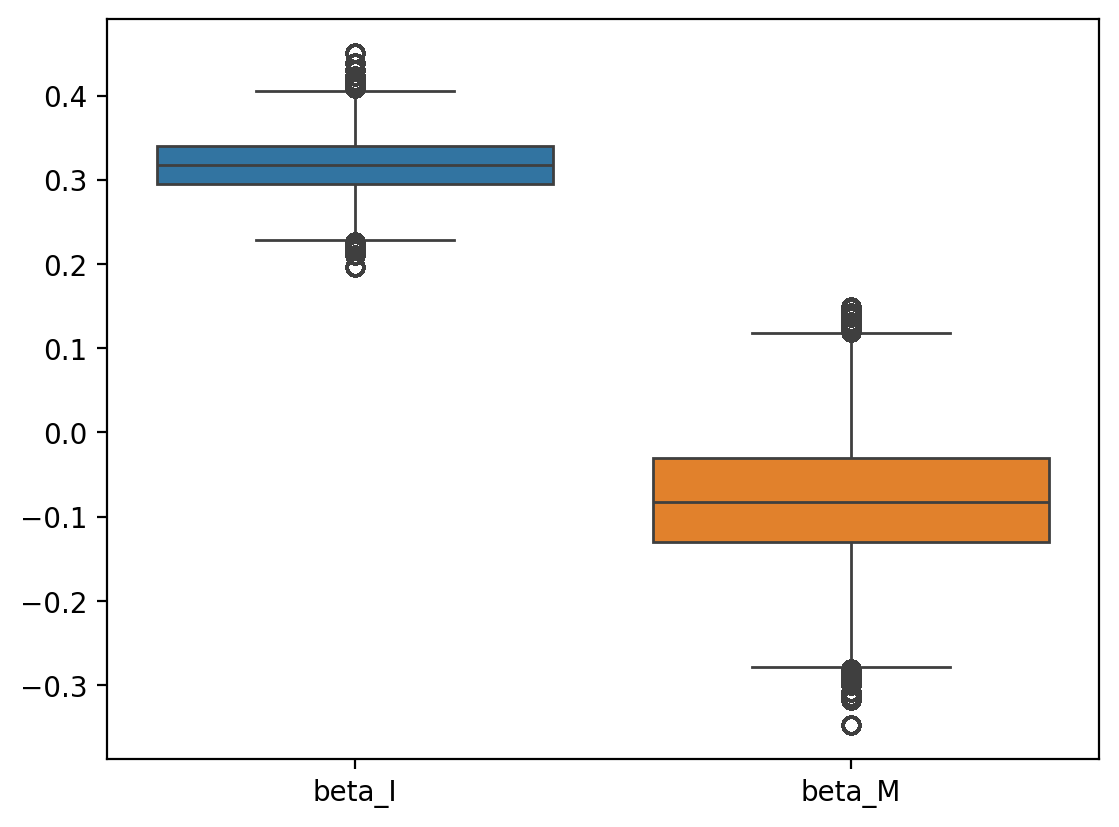

In [ ]:
sns.boxplot(data=model_project_low1_mcmc_samples[['beta_I', 'beta_M']])

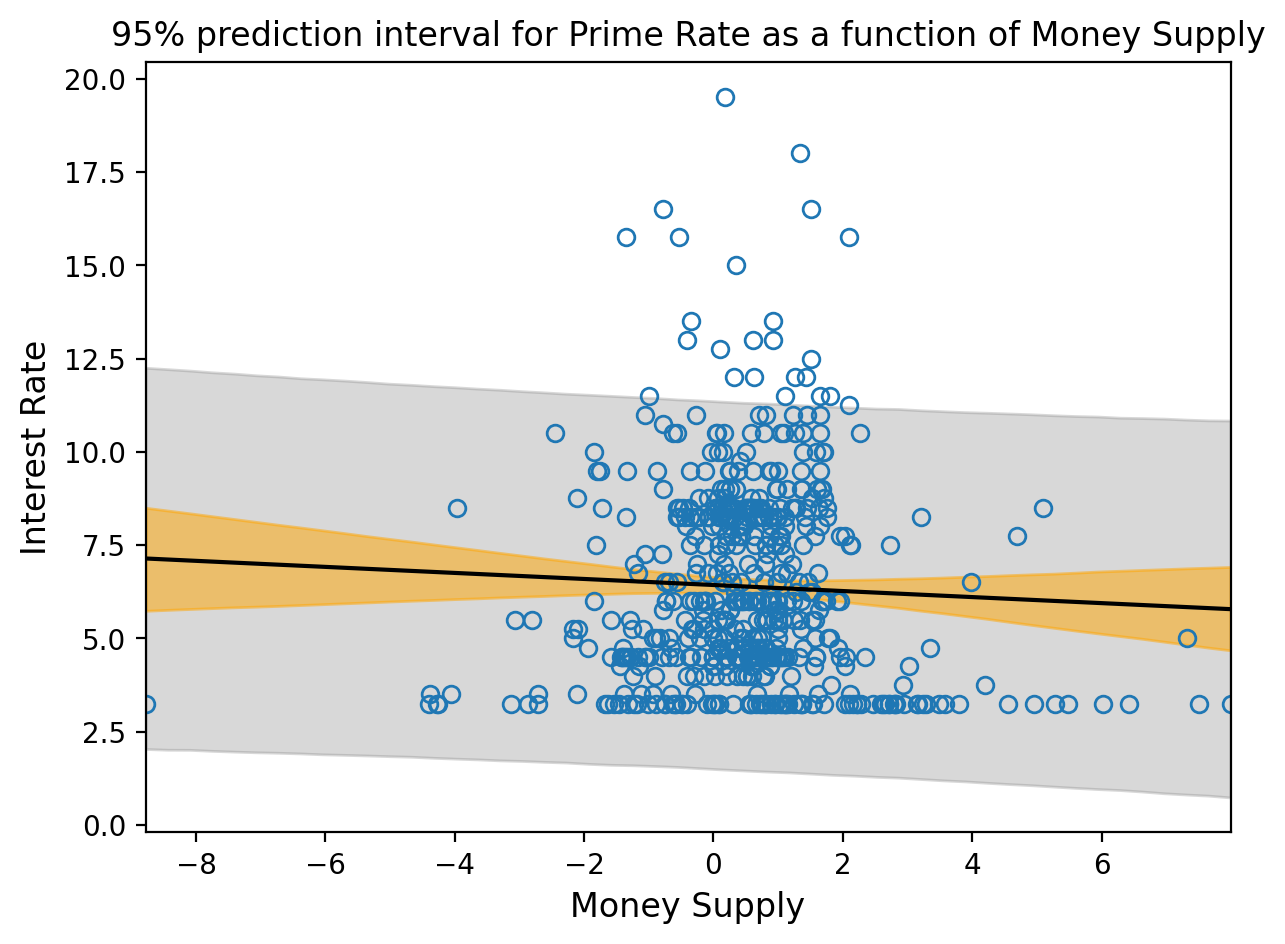

In [ ]:
## Prediction plot for DPRIME vs CPI, holding MS at mean:

prob = 0.95 ## for credible intervals

xmin = data_low['Money Base Change'].min()
xmax = data_low['Money Base Change'].max()
xmean = data_low['Money Base Change'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_project_low1_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_project_low1_mcmc_samples['beta_M'])[None, :]
sigma_samples = array(model_project_low1_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_low['Money Base Change'], data_low['DPRIME'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Prime Rate as a function of Money Supply')
xlabel('Money Supply', fontsize=12)
ylabel('Interest Rate', fontsize=12);

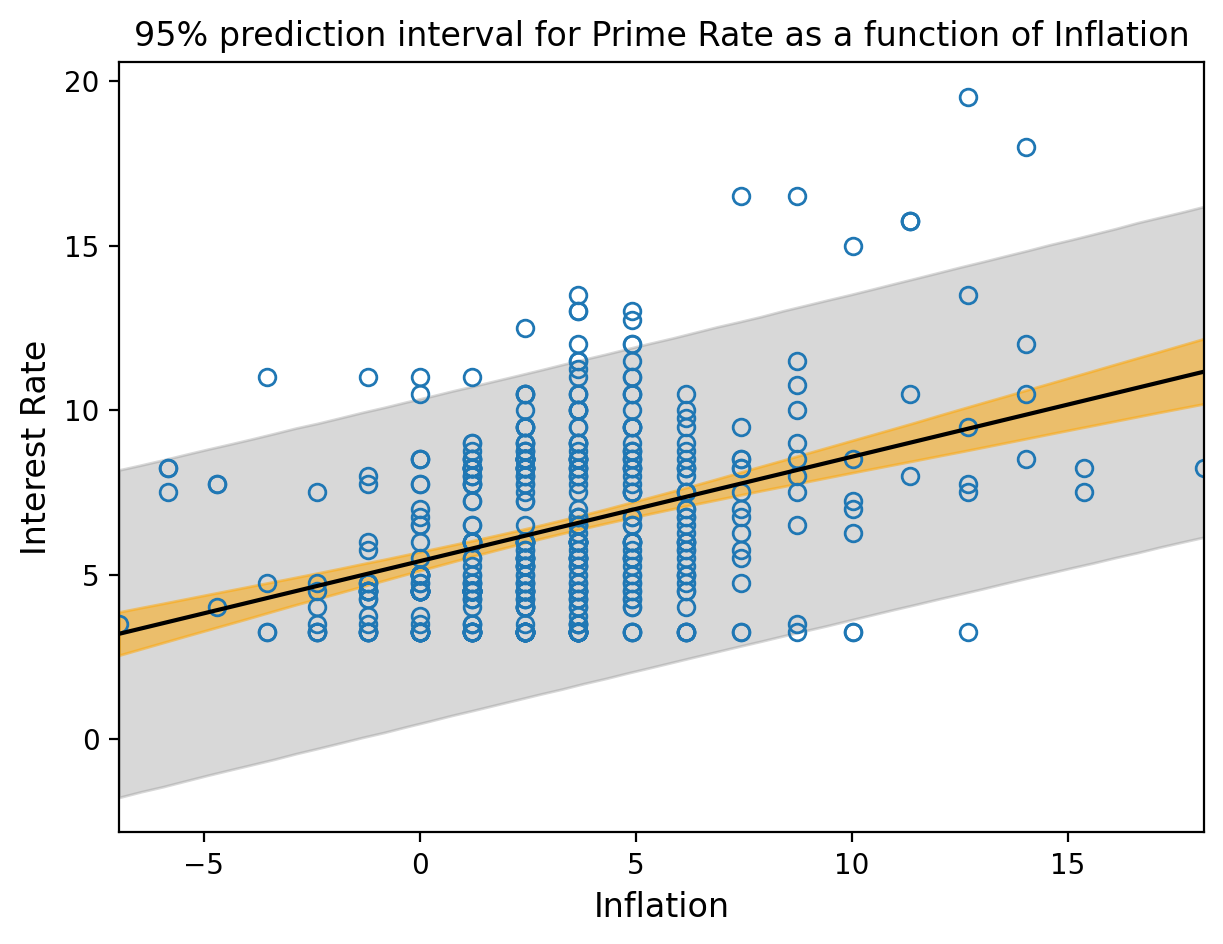

In [ ]:
## Prediction plot for DPRIME vs CPI, holding MS at mean:

prob = 0.95 ## for credible intervals

xmin = data_low['Inf_Prev'].min()
xmax = data_low['Inf_Prev'].max()
xmean = data_low['Inf_Prev'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_project_low1_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_project_low1_mcmc_samples['beta_I'])[None, :]
sigma_samples = array(model_project_low1_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_low['Inf_Prev'], data_low['DPRIME'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Prime Rate as a function of Inflation')
xlabel('Inflation', fontsize=12)
ylabel('Interest Rate', fontsize=12);

In [ ]:
mean_I, mean_M = model_project_low1_mcmc_samples[['beta_I', 'beta_M']].mean()

print('mean_I (Low)=', mean_I)
print('----------')
print('mean_M (Low)=', mean_M)

mean_I (Low)= 0.3171080083330997
----------
mean_M (Low)= -0.08096271118461999


In [ ]:
mean_I_total, mean_M_total = model_project_time1_mcmc_samples[['beta_I', 'beta_M']].mean()

print('mean_I (Total)=', mean_I_total)
print('----------')
print('mean_M (Total)=', mean_M_total)

print('=====================================')


mean_I_low, mean_M_low = model_project_low1_mcmc_samples[['beta_I', 'beta_M']].mean()

print('mean_I (Low)=', mean_I_low)
print('----------')
print('mean_M (Low)=', mean_M_low)

print('=====================================')


mean_I (Total)= 0.4567431569159073
----------
mean_M (Total)= -0.02844836385425011
mean_I (Low)= 0.3171080083330997
----------
mean_M (Low)= -0.08096271118461999


## High Inflation:

We again conduct MLR MCMC analysis of the prime interest rate `DPRIME` as response variable and time-delayed inflation `Inf_Prev` and Money Supply change as predictor variables, but this time for only High-inflation data ($\geq 5\%$), to see whether the relationship differs between high- and low-inflation regimes.

For this, we observe that the mean of the prime interest rate is approximately 8.9, so we take the intercept $\alpha$ to have a mean of 9 and standard deviation of 2. Furthermore, we take a slightly wider distribution of $\sigma$. Because we do not know the nature of the relationship between inflation and interest rate and oil price, we take a prior of the $\beta$ estimates to be centered at 0, with standard deviation at 1.


Our Prior takes the form:

\begin{align*}
    DPRIME_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{I}(I_{i}-\bar{I}) + \beta_{M}(M_{i}-\bar{M})\\
    \alpha &\sim \text{Normal}(9, 2) \\
    \beta_{I} &\sim \text{Normal}(0, 1) \\
    \beta_{M} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $I_i$ denotes the time-delayed inflation rate, and $M_i$ is the money supply change.

In [ ]:
with pm.Model() as model_project_high1:
    sigma = pm.Exponential('sigma', 0.5)
    beta_M = pm.Normal('beta_M', mu=0, sigma=1)
    beta_I = pm.Normal('beta_I', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=9, sigma=2)
    _mu = (alpha + beta_M*(data_high['Money Base Change']-data_high['Money Base Change'].mean())
        + beta_I*(data_high['Inf_Prev']-data_high['Inf_Prev'].mean()))
    mu = pm.Deterministic('mu', _mu)
    DPRIME = pm.Normal('DPRIME', mu=mu, sigma=sigma, observed=data_high['DPRIME'])
    _model_project_high1_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_project_high1_mcmc_samples = _model_project_high1_mcmc_samples.posterior.to_dataframe()
model_project_high1_mcmc_samples

alpha    beta_I    beta_M         mu     sigma
chain draw mu_dim_0                                                   
0     0    0         9.067298  0.563014  0.382562   5.607989  3.181757
           1         9.067298  0.563014  0.382562   6.208722  3.181757
           2         9.067298  0.563014  0.382562   5.012024  3.181757
           3         9.067298  0.563014  0.382562   4.536327  3.181757
           4         9.067298  0.563014  0.382562   6.496049  3.181757
...                       ...       ...       ...        ...       ...
3     999  186       8.920967  0.550214  0.174462   9.150401  3.279916
           187       8.920967  0.550214  0.174462   9.417426  3.279916
           188       8.920967  0.550214  0.174462  10.739403  3.279916
           189       8.920967  0.550214  0.174462  11.501343  3.279916
           190       8.920967  0.550214  0.174462   9.330267  3.279916

[764000 rows x 5 columns]

<Axes: >

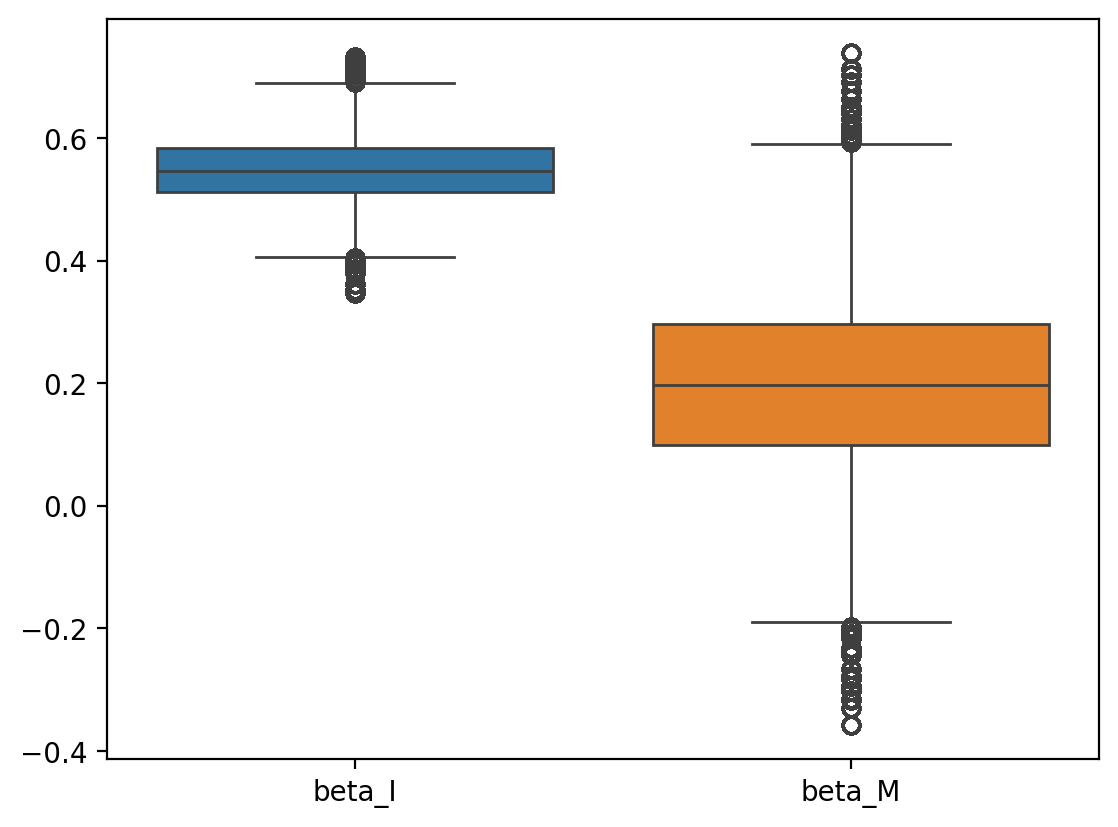

In [ ]:
sns.boxplot(data=model_project_high1_mcmc_samples[['beta_I', 'beta_M']])

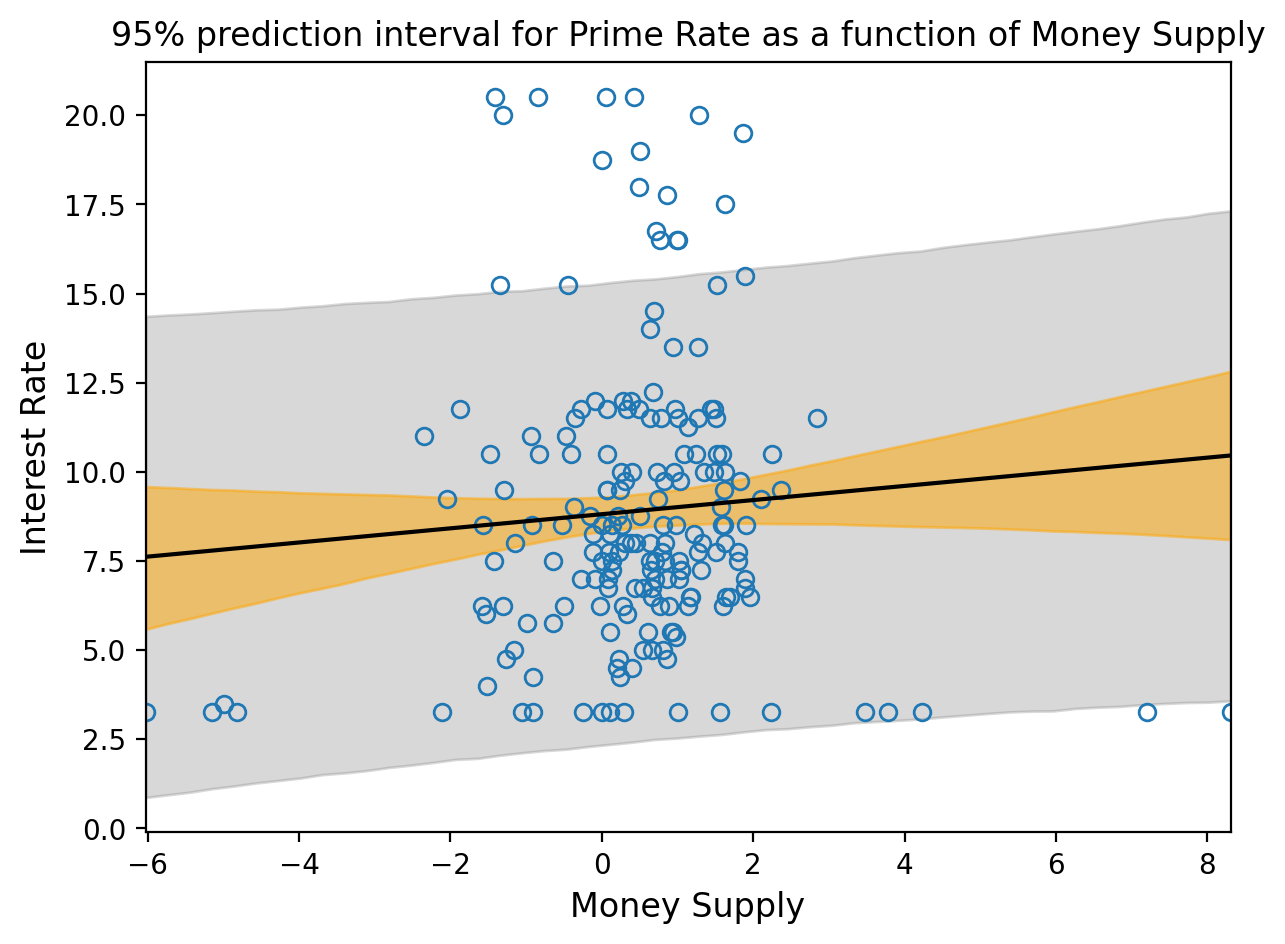

In [ ]:
## Prediction plot for DPRIME vs CPI, holding MS at mean:

prob = 0.95 ## for credible intervals

xmin = data_high['Money Base Change'].min()
xmax = data_high['Money Base Change'].max()
xmean = data_high['Money Base Change'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_project_high1_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_project_high1_mcmc_samples['beta_M'])[None, :]
sigma_samples = array(model_project_high1_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_high['Money Base Change'], data_high['DPRIME'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Prime Rate as a function of Money Supply')
xlabel('Money Supply', fontsize=12)
ylabel('Interest Rate', fontsize=12);

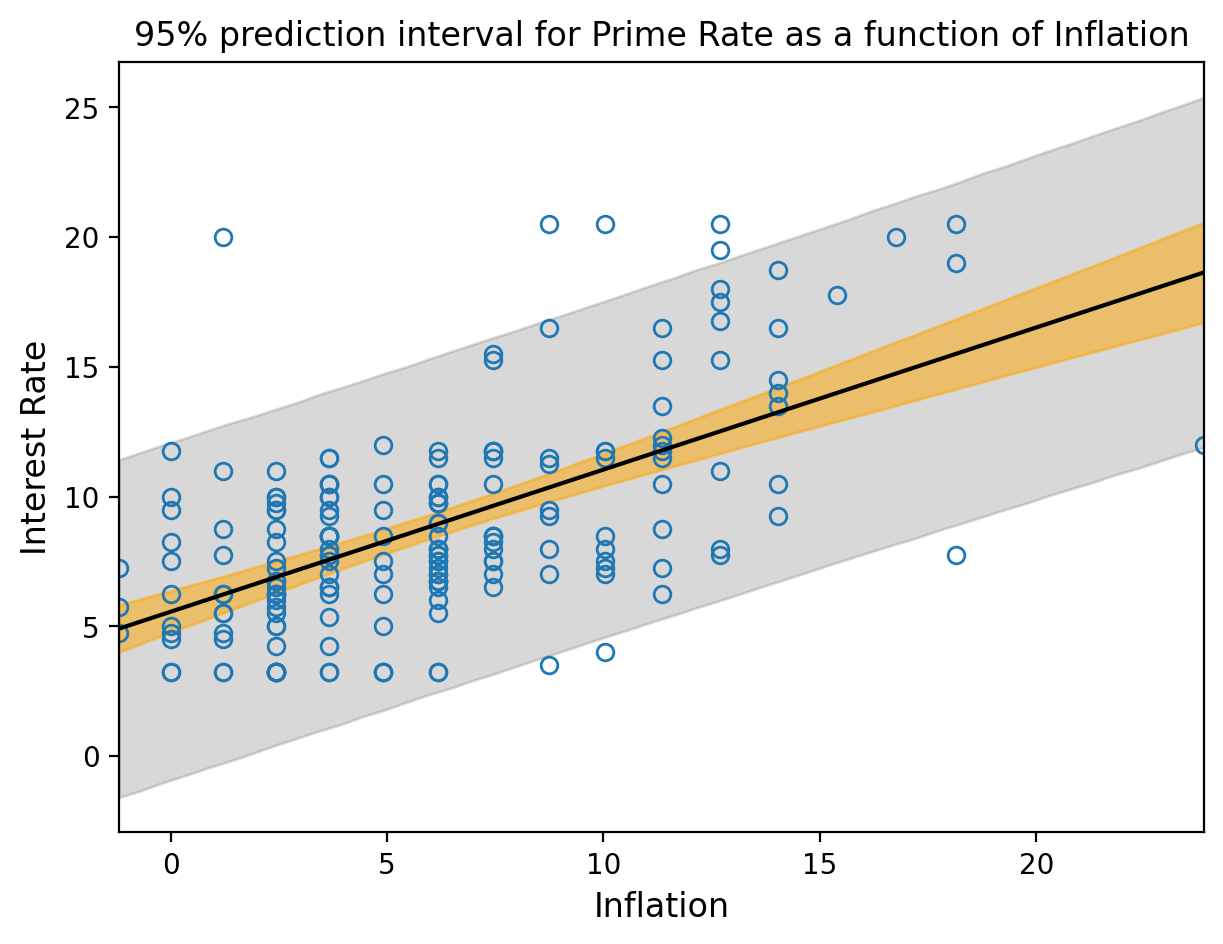

In [ ]:
## Prediction plot for DPRIME vs CPI, holding MS at mean:

prob = 0.95 ## for credible intervals

xmin = data_high['Inf_Prev'].min()
xmax = data_high['Inf_Prev'].max()
xmean = data_high['Inf_Prev'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_project_high1_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_project_high1_mcmc_samples['beta_I'])[None, :]
sigma_samples = array(model_project_high1_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_high['Inf_Prev'], data_high['DPRIME'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Prime Rate as a function of Inflation')
xlabel('Inflation', fontsize=12)
ylabel('Interest Rate', fontsize=12);

In [ ]:
mean_I, mean_M = model_project_high1_mcmc_samples[['beta_I', 'beta_M']].mean()

print('mean_I (High)=', mean_I)
print('----------')
print('mean_M (High)=', mean_M)

mean_I (High)= 0.5477137572794273
----------
mean_M (High)= 0.19827981598901087


In [ ]:
MS_threshold = data_high['Money Base Change'].quantile([0.02, 0.98]).values
MS_low_threshold, MS_high_threshold = MS_threshold
data_high2 = data_high[(data_high['Money Base Change'] > MS_low_threshold) & (data_high['Money Base Change'] < MS_high_threshold)]
data_high2

Date  BOGMBASE  Money Base Change  DPRIME       GDP  SPIndex  \
9    1960-10-01     50100           0.400802    4.50 -0.331435   0.0354   
32   1962-09-01     51300           0.195312    4.50  0.177727  -0.0286   
73   1966-02-01     59800          -1.157025    5.00  0.385866  -0.0386   
79   1966-08-01     61700          -0.644122    5.75  0.552633  -0.0322   
89   1967-06-01     64000           0.946372    5.50  0.633990   0.0199   
..          ...       ...                ...     ...       ...      ...   
738  2022-02-01   6039900          -1.048510    3.25  0.681423  -0.0089   
739  2022-03-01   6134400           1.564595    3.25  0.681423   0.0012   
742  2022-06-01   5506500          -1.520165    4.00  0.584273   0.0046   
746  2022-10-01   5340200          -1.306622    6.25  0.527788   0.0529   
749  2023-01-01   5329000          -1.424343    7.50  0.508855   0.0315   

           Oil      CPI.U  GoldChange   Inf_Prev  
9     0.000000   6.167781         NaN   0.000000  
32    0.000000   6.167781         NaN   1.206622  
73    0.000000   7.442417         NaN   0.000000  
79    0.000000   7.442417         NaN  -1.193422  
89    0.000000   7.442417         NaN   1.206622  
..         ...        ...         ...        ...  
738  10.117760   8.731066   -0.010934   4.907021  
739  18.398079  12.682503    7.917527   6.167781  
742   4.828845  15.389462   -0.924302  10.033869  
746   3.904581   6.167781    0.184689  11.350967  
749   2.197802   6.167781    1.153698   7.442417  

[183 rows x 10 columns]

In [ ]:
with pm.Model() as model_project_high2:
    sigma = pm.Exponential('sigma', 0.5)
    beta_M = pm.Normal('beta_M', mu=0, sigma=1)
    beta_I = pm.Normal('beta_I', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=9, sigma=2)
    _mu = (alpha + beta_M*(data_high2['Money Base Change']-data_high2['Money Base Change'].mean())
        + beta_I*(data_high2['Inf_Prev']-data_high2['Inf_Prev'].mean()))
    mu = pm.Deterministic('mu', _mu)
    DPRIME = pm.Normal('DPRIME', mu=mu, sigma=sigma, observed=data_high2['DPRIME'])
    _model_project_high2_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_project_high2_mcmc_samples = _model_project_high2_mcmc_samples.posterior.to_dataframe()
model_project_high2_mcmc_samples

alpha    beta_I    beta_M         mu     sigma
chain draw mu_dim_0                                                   
0     0    0         8.834932  0.563416  0.556058   5.283224  3.292412
           1         8.834932  0.563416  0.556058   5.848791  3.292412
           2         8.834932  0.563416  0.556058   4.416983  3.292412
           3         8.834932  0.563416  0.556058   4.029794  3.292412
           4         8.834932  0.563416  0.556058   6.266423  3.292412
...                       ...       ...       ...        ...       ...
3     999  178       9.198041  0.600343  0.526760   7.600880  2.917560
           179       9.198041  0.600343  0.526760   9.734248  2.917560
           180       9.198041  0.600343  0.526760  10.430301  2.917560
           181       9.198041  0.600343  0.526760  11.333498  2.917560
           182       9.198041  0.600343  0.526760   8.925014  2.917560

[732000 rows x 5 columns]

<Axes: >

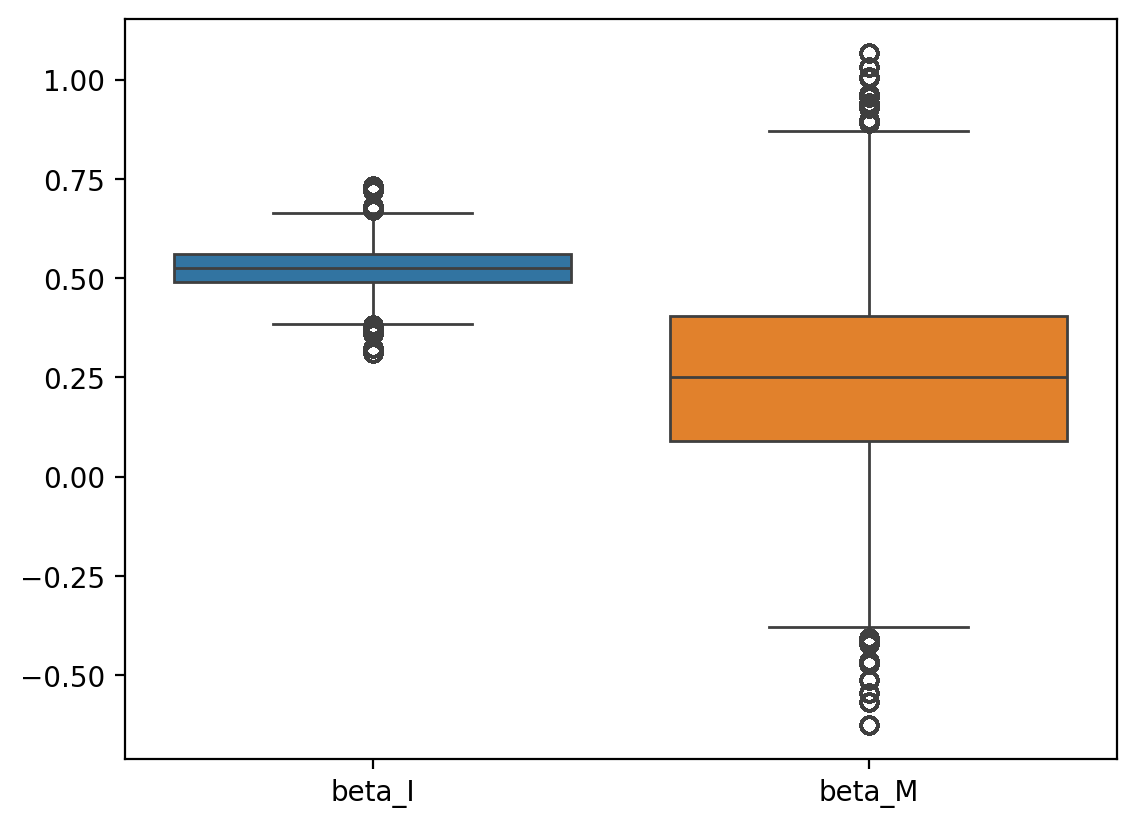

In [ ]:
sns.boxplot(data=model_project_high2_mcmc_samples[['beta_I', 'beta_M']])

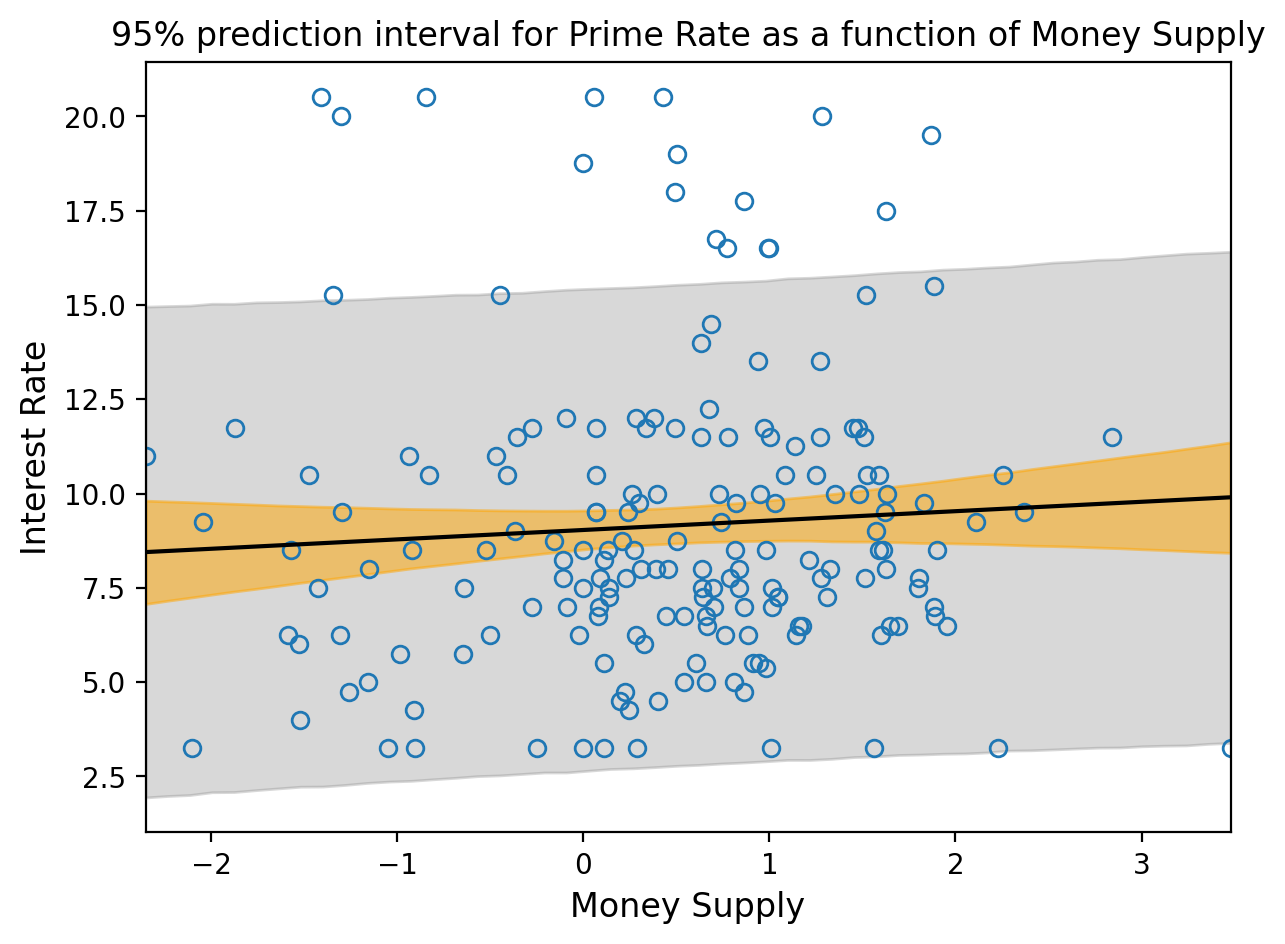

In [ ]:
## Prediction plot for DPRIME vs CPI, holding MS at mean:

prob = 0.95 ## for credible intervals

xmin = data_high2['Money Base Change'].min()
xmax = data_high2['Money Base Change'].max()
xmean = data_high2['Money Base Change'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_project_high2_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_project_high2_mcmc_samples['beta_M'])[None, :]
sigma_samples = array(model_project_high2_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_high2['Money Base Change'], data_high2['DPRIME'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Prime Rate as a function of Money Supply')
xlabel('Money Supply', fontsize=12)
ylabel('Interest Rate', fontsize=12);

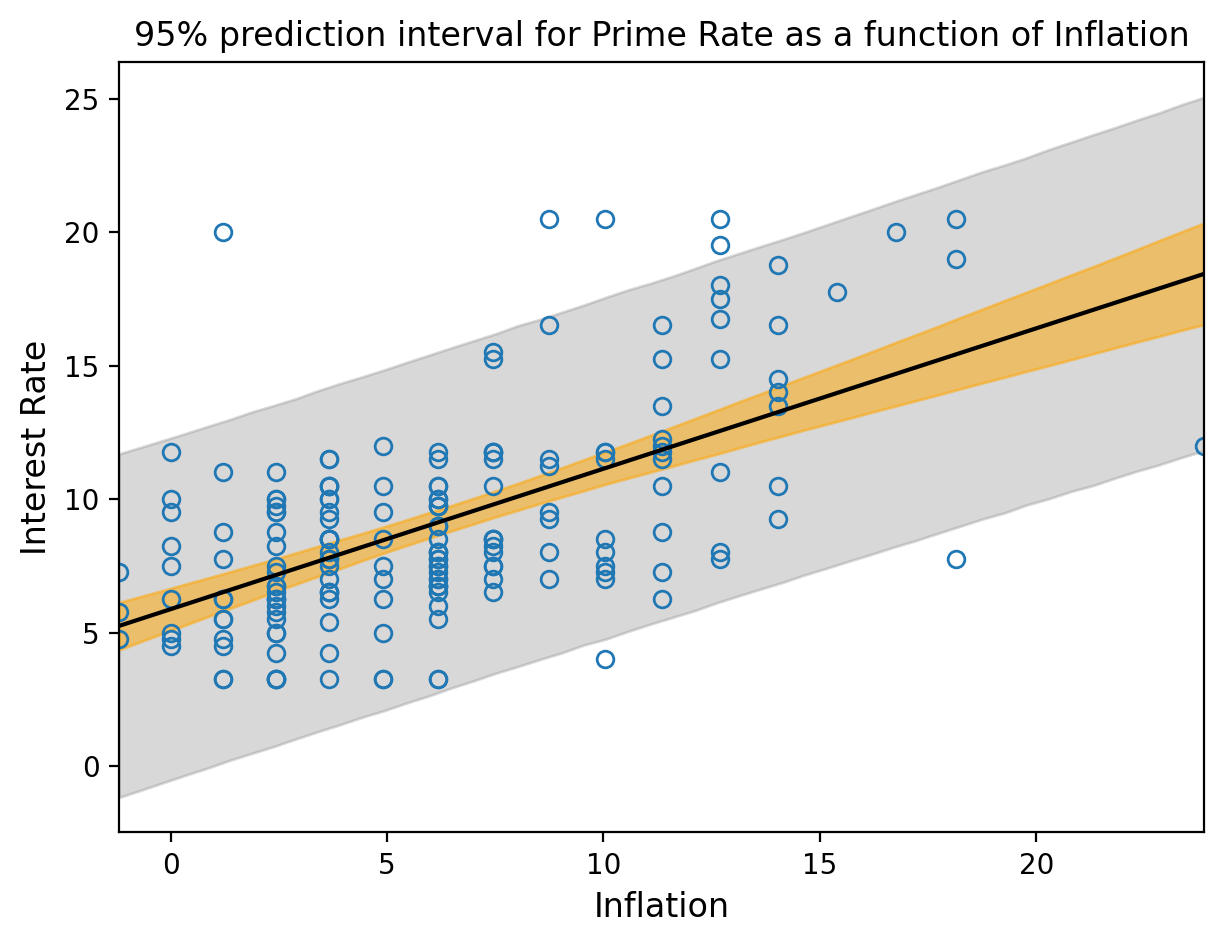

In [ ]:
## Prediction plot for DPRIME vs CPI, holding MS at mean:

prob = 0.95 ## for credible intervals

xmin = data_high2['Inf_Prev'].min()
xmax = data_high2['Inf_Prev'].max()
xmean = data_high2['Inf_Prev'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_project_high2_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_project_high2_mcmc_samples['beta_I'])[None, :]
sigma_samples = array(model_project_high2_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_high2['Inf_Prev'], data_high2['DPRIME'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Prime Rate as a function of Inflation')
xlabel('Inflation', fontsize=12)
ylabel('Interest Rate', fontsize=12);

In [ ]:
mean_I, mean_M = model_project_high2_mcmc_samples[['beta_I', 'beta_M']].mean()

print('mean_I (High2)=', mean_I)
print('----------')
print('mean_M (High2)=', mean_M)

mean_I (High2)= 0.526041658131467
----------
mean_M (High2)= 0.2491267779731392


**Overall:**

In [ ]:
mean_I_total, mean_M_total = model_project_time1_mcmc_samples[['beta_I', 'beta_M']].mean()

print('TOTAL:')
print('mean_I=', mean_I_total)
print('----------')
print('mean_M=', mean_M_total)

print('=====================================')


mean_I_low, mean_M_low = model_project_low1_mcmc_samples[['beta_I', 'beta_M']].mean()

print('LOW:')
print('mean_I=', mean_I_low)
print('----------')
print('mean_M=', mean_M_low)

print('=====================================')

mean_I_high, mean_M_high = model_project_high1_mcmc_samples[['beta_I', 'beta_M']].mean()

print('HIGH:')
print('mean_I=', mean_I_high)
print('----------')
print('mean_M=', mean_M_high)

TOTAL:
mean_I= 0.4567431569159073
----------
mean_M= -0.02844836385425011
LOW:
mean_I= 0.3171080083330997
----------
mean_M= -0.08096271118461999
HIGH:
mean_I= 0.5477137572794273
----------
mean_M= 0.19827981598901087


We now conduct two-sample t-test for the Low- and High posterior distributions for $\beta_I$, to see whether the difference in slope between the Low and High inflation levels is statistically significant.

In [ ]:
DF_inf_lo_hi = pd.DataFrame()
DF_inf_lo_hi['Low'] = model_project_low1_mcmc_samples[['beta_I']]
DF_inf_lo_hi['High'] = model_project_high1_mcmc_samples[['beta_I']]

print(DF_inf_lo_hi)

                          Low      High
chain draw mu_dim_0                    
0     0    0         0.381567  0.563014
           1         0.381567  0.563014
           2         0.381567  0.563014
           3         0.381567  0.563014
           4         0.381567  0.563014
...                       ...       ...
3     999  559       0.331997       NaN
           560       0.331997       NaN
           561       0.331997       NaN
           562       0.331997       NaN
           563       0.331997       NaN

[2256000 rows x 2 columns]


In [ ]:
## Downloading posterior beta_I distribution CSV:

# from google.colab import files
# DF_inf_lo_hi.to_csv('DF_inf_lo_hi.csv')
# files.download('DF_inf_lo_hi.csv')


## R Code for two-sample t-test of these data:

# data <- read.csv(file.choose(), header=TRUE)
# attach(data)
# names(data)
# data_low <- data$Low
# data_high <- data$High
# t.test(data_low, data_high, alternative = "two.sided", mu = 0, paired = FALSE, var.equal = TRUE, conf.level = 0.95)

## Statistical Results:

#         Two Sample t-test

# data:  data_low and data_high
# t = -4440.1, df = 3019998, p-value < 2.2e-16
# alternative hypothesis: true difference in means is not equal to 0
# 95 percent confidence interval:
#  -0.2321920 -0.2319871
# sample estimates:
# mean of x mean of y
# 0.3170059 0.5490955



In [ ]:
import scipy.stats as stats

print(np.var(model_project_low1_mcmc_samples[['beta_I']]), np.var(model_project_high1_mcmc_samples[['beta_I']])),

print('Ratio=', np.var(model_project_high1_mcmc_samples[['beta_I']])/np.var(model_project_low1_mcmc_samples[['beta_I']]))

print("--------------------------------")

stats.ttest_ind(a=model_project_low1_mcmc_samples[['beta_I']], b=model_project_high1_mcmc_samples[['beta_I']], equal_var=True)

beta_I    0.001084
dtype: float64 beta_I    0.002849
dtype: float64
Ratio= beta_I    2.627875
dtype: float64
--------------------------------


TtestResult(statistic=array([-4453.28540008]), pvalue=array([0.]), df=array([3019998.]))

In [ ]:
print(np.var(model_project_low1_mcmc_samples[['beta_M']]), np.var(model_project_high1_mcmc_samples[['beta_M']])),

print('Ratio=', np.var(model_project_high1_mcmc_samples[['beta_M']])/np.var(model_project_low1_mcmc_samples[['beta_M']]))

print("--------------------------------")

print("Eq. Var:")
stats.ttest_ind(a=model_project_low1_mcmc_samples[['beta_M']], b=model_project_high1_mcmc_samples[['beta_M']], equal_var=True)

print("--------------------------------")

print("Noneq. Var:")

stats.ttest_ind(a=model_project_low1_mcmc_samples[['beta_M']], b=model_project_high1_mcmc_samples[['beta_M']], equal_var=False)

beta_M    0.005486
dtype: float64 beta_M    0.022803
dtype: float64
Ratio= beta_M    4.156843
dtype: float64
--------------------------------
Eq. Var:
--------------------------------
Noneq. Var:


TtestResult(statistic=array([-1554.27346487]), pvalue=array([0.]), df=array([891549.71943396]))

Hence, we conclude that there is a *very* statistically significant difference between the high-inflation and low-inflation data in the relationship between inflation and prime interest rate. Furthermore, there is a *very* statistically significant difference between the high-inflation and low-inflation data in the relationship between prime interest rate and money supply, although the estimates of the slopes for $\beta_M$ are not statistically significantly different from 0.

# Part 2:

## The Influential Factors of Gold Price

Now that we have studied and ascertained the factors controlling inflation, we now examine whether gold serves as a useful asset in helping to protect against inflation. In this case, our gold price data begins in January 1971, so we pre-process our dataset to now include the 'Gold Price' column and to only contain the data from 1971 onward.

The pertinent Directed Acyclic Graph for the expected relationship between GDP, S&P 500 stock index, CPI inflation, and Gold price, takes the form given below:

The DAG can be summarized as follows:

* GDP influences both the S&P 500 stock index and CPI inflation
* The stock market behavior and CPI inflation both influence the price growth of gold, as gold is viewed as a 'hedge' (protection) against fluctuations in stock market and inflation turbulence.
* Because gold price is a market product, it is not directly influenced by GDP (economic well-being), but is indirectly influenced through the resultant trends of the stock/asset market.

In [ ]:
data_pt2 = data_all[data_all['GoldChange'].notnull()]
data_pt2

Date  BOGMBASE  Money Base Change  DPRIME       GDP  SPIndex  \
132  1971-01-01     81200           0.246914    6.75  1.405461   0.0415   
133  1971-02-01     80600          -0.738916    6.00  0.616227   0.0283   
134  1971-03-01     80800           0.248139    5.75  0.616227   0.0367   
135  1971-04-01     81600           0.990099    5.25  0.616227  -0.0111   
136  1971-05-01     82400           0.980392    5.38  0.613272  -0.0160   
..          ...       ...                ...     ...       ...      ...   
750  2023-02-01   5321600          -0.138863    7.50  0.309099  -0.0259   
751  2023-03-01   5571500           4.695956    7.75  0.309099   0.0400   
752  2023-04-01   5593100           0.387687    8.00  0.309099   0.0060   
753  2023-05-01   5569600          -0.420161    8.00  0.685690   0.0480   
754  2023-06-01   5608500           0.698434    8.25  0.685690   0.0254   

          Oil     CPI.U  GoldChange   Inf_Prev  
132  0.000000  3.659998    0.000000   6.167781  
133  0.000000  0.000000    1.854305   6.167781  
134  0.000000  3.659998    1.430429   6.167781  
135  0.000000  3.659998    0.512821   6.167781  
136  0.000000  6.167781    1.275510   3.659998  
..        ...       ...         ...        ...  
750 -1.651306  4.907021    6.949104   8.731066  
751 -4.620591  1.206622   -5.825150  12.682503  
752  8.419760  4.907021    8.019392   4.907021  
753 -9.905601  1.206622   -0.103845  11.350967  
754 -1.858061  2.426577   -0.210399  15.389462  

[623 rows x 10 columns]

In [ ]:
data_pt2['GoldChange'].mean()

0.7693025642520065

## Gold price, Inflation & S&P 500:

Now, we turn our attention to analyzing the significance of the relationship between inflation and changes in the gold price. Observing the DAG plot above, we see that there are two paths between CPI and Gold price; to close the second (unwanted) path, we condition on the GDP variable above, and hence write a model that includes the S&P 500 stock index and CPI versus the Gold price.

Note that, as explained earlier, our gold data only begins in 1971, so we first filter out all data points before that time. Furthermore, we observe that the mean for the price change of gold is approximately 0.71%, so we take the prior $\alpha$ to have a mean of 0.7 and standard deviation of 0.2.

As such, we take the following prior:

\begin{align*}
    Gold_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{C}(C_{i}-\bar{C}) + \beta_{S}(S_{i}-\bar{S}) \\
    \alpha &\sim \text{Normal}(0.7, 0.2) \\
    \beta_{C} &\sim \text{Normal}(0, 1) \\
    \beta_{S} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $C_i$ denotes the CPI inflation rate and $S_i$ denotes the S&P 500 growth rate.

In [ ]:
with pm.Model() as model_gold1:
    sigma = pm.Exponential('sigma', 0.5)
    beta_C = pm.Normal('beta_C', mu=0, sigma=1)
    beta_S = pm.Normal('beta_S', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=0.7, sigma=0.2)
    _mu = alpha + beta_C*(data_pt2['CPI.U']-data_pt2['CPI.U'].mean()) + beta_S*(data_pt2['SPIndex']-data_pt2['SPIndex'].mean())
    mu = pm.Deterministic('mu', _mu)
    Gold = pm.Normal('Gold', mu=mu, sigma=sigma, observed=data_pt2['GoldChange'])
    _model_gold1_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_gold1_mcmc_samples = _model_gold1_mcmc_samples.posterior.to_dataframe()
model_gold1_mcmc_samples

alpha    beta_C    beta_S        mu     sigma
chain draw mu_dim_0                                                  
0     0    0         0.789119  0.169539 -0.626573  0.687255  6.059936
           1         0.789119  0.169539 -0.626573  0.075012  6.059936
           2         0.789119  0.169539 -0.626573  0.690263  6.059936
           3         0.789119  0.169539 -0.626573  0.720213  6.059936
           4         0.789119  0.169539 -0.626573  1.148451  6.059936
...                       ...       ...       ...       ...       ...
3     999  618       0.574692  0.356815  0.958065  0.814143  5.975147
           619       0.574692  0.356815  0.958065 -0.443080  5.975147
           620       0.574692  0.356815  0.958065  0.844705  5.975147
           621       0.574692  0.356815  0.958065 -0.435415  5.975147
           622       0.574692  0.356815  0.958065 -0.021769  5.975147

[2492000 rows x 5 columns]

<Axes: >

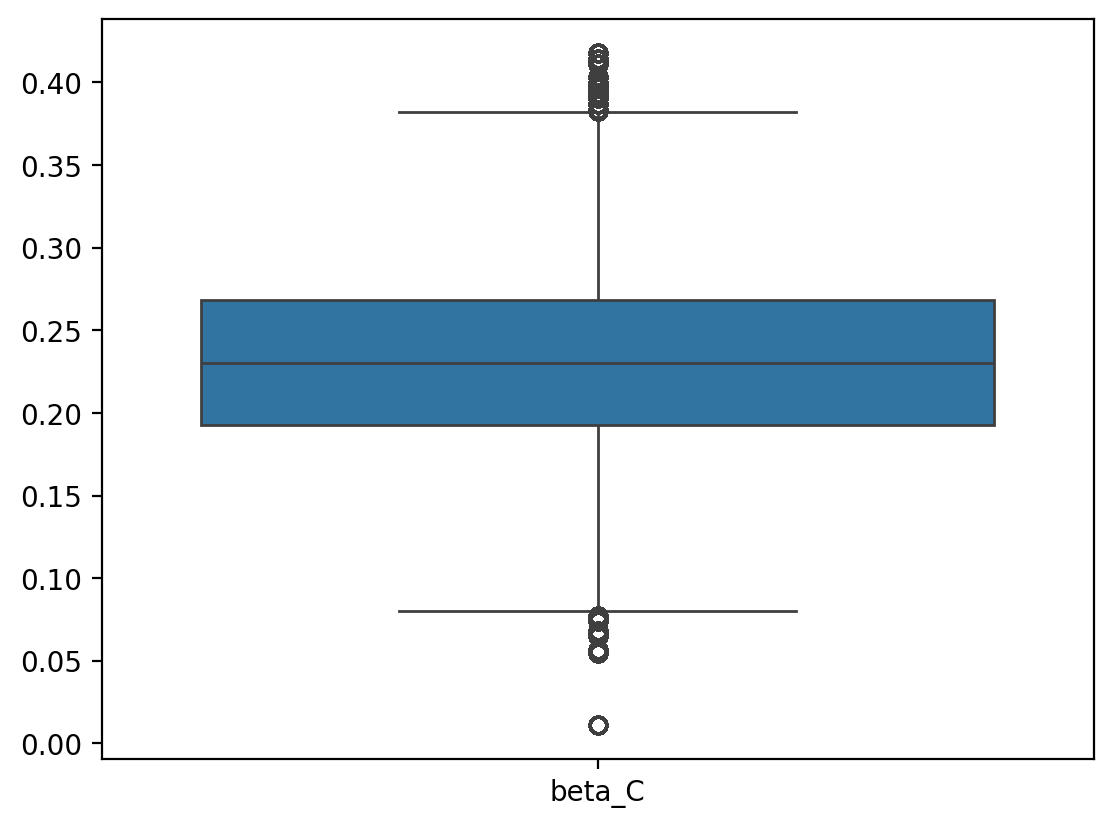

In [ ]:
sns.boxplot(data=model_gold1_mcmc_samples[['beta_C']])

<Axes: >

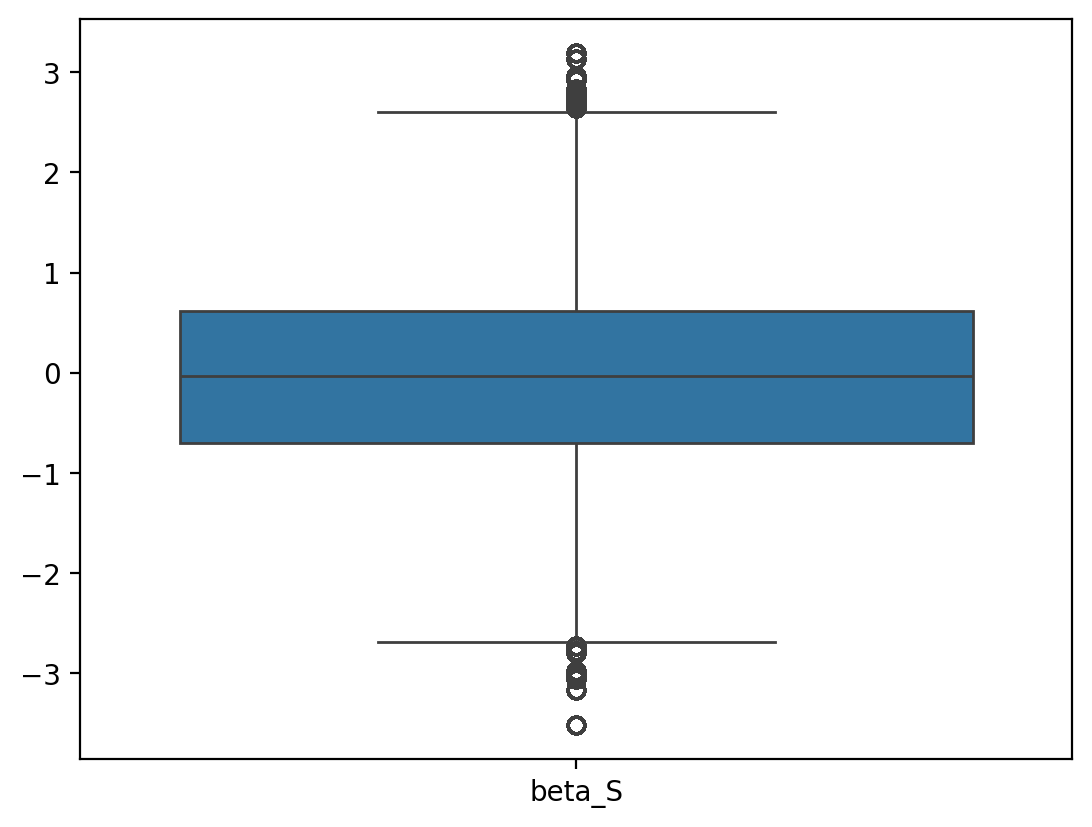

In [ ]:
sns.boxplot(data=model_gold1_mcmc_samples[['beta_S']])

As can be seen, the boxplot for $\beta_C$ is clearly above 0 with an estimated median between 0.20 and 0.25, indicating that **there is a significant positive relationship between CPI Inflation and changes in gold price**.

However, the boxplot for $\beta_S$ is very closely centered to 0, indicating that **there is no significant relationship between changes in gold price and changes in the S&P 500 stock index**.

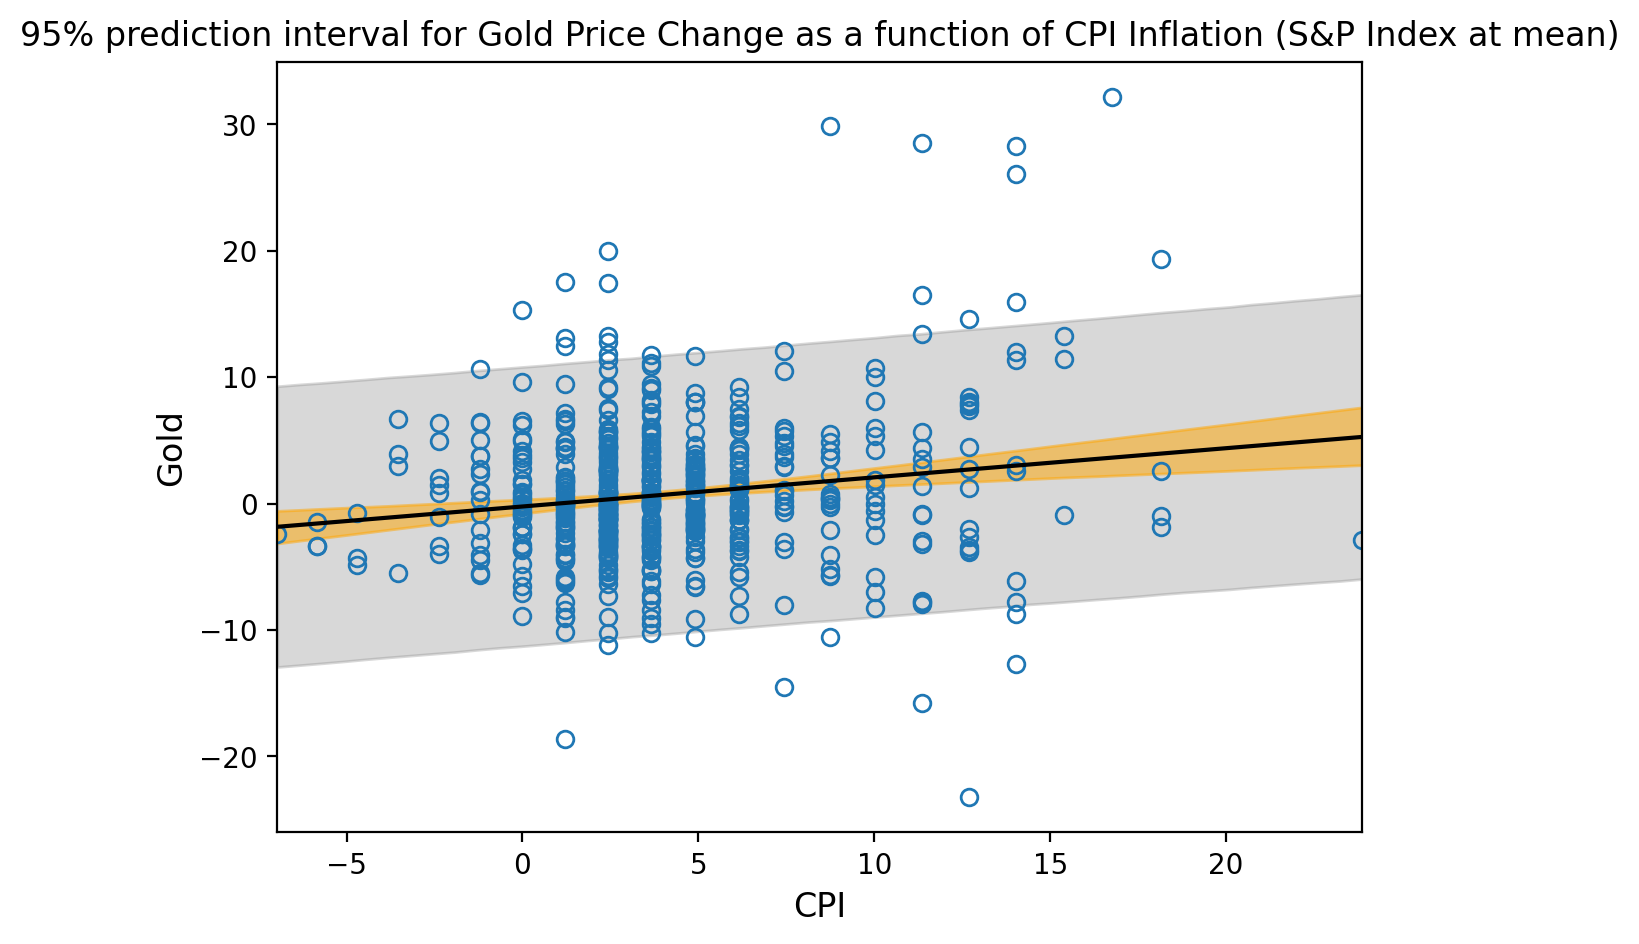

In [ ]:
## Prediction plot for Gold from CPI and S&P MCMC, holding S&P at its mean:

prob = 0.95 ## for credible intervals

xmin = data_pt2['CPI.U'].min()
xmax = data_pt2['CPI.U'].max()
xmean = data_pt2['CPI.U'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_gold1_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_gold1_mcmc_samples['beta_C'])[None, :]
sigma_samples = array(model_gold1_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_pt2['CPI.U'], data_pt2['GoldChange'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Gold Price Change as a function of CPI Inflation (S&P Index at mean)')
xlabel('CPI', fontsize=12)
ylabel('Gold', fontsize=12);

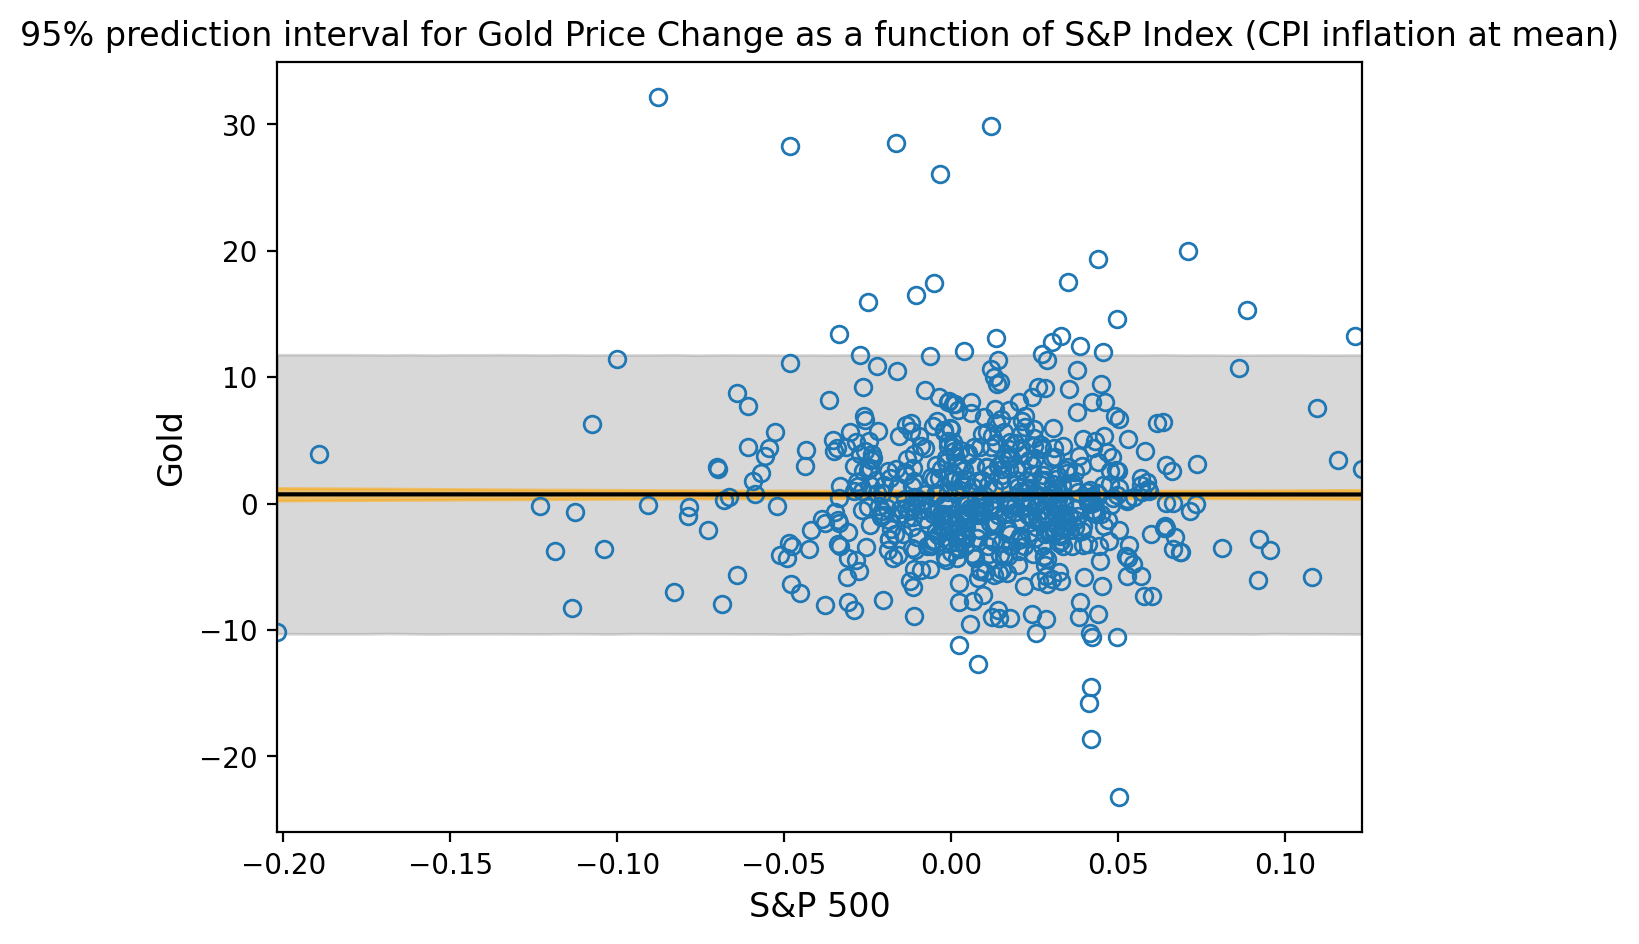

In [ ]:
## Prediction plot for Gold from CPI and S&P MCMC, holding CPI at its mean:

prob = 0.95 ## for credible intervals

xmin = data_pt2['SPIndex'].min()
xmax = data_pt2['SPIndex'].max()
xmean = data_pt2['SPIndex'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_gold1_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_gold1_mcmc_samples['beta_S'])[None, :]
sigma_samples = array(model_gold1_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_pt2['SPIndex'], data_pt2['GoldChange'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Gold Price Change as a function of S&P Index (CPI inflation at mean)')
xlabel('S&P 500', fontsize=12)
ylabel('Gold', fontsize=12);

Overall, our analysis indicates that there is a significant positive relationship between inflation and gold price change, but not between S&P 500 stock index and gold price change. This leads us to conclude that gold is a valuable asset in helping to hedge against inflation, and is particularly useful because of its observed resilience to stock market trends.

In [ ]:
mean_C_total, mean_S_total = model_gold1_mcmc_samples[['beta_C', 'beta_S']].mean()

print('TOTAL:')
print('mean_C=', mean_C_total)
print('----------')
print('mean_S=', mean_S_total)

TOTAL:
mean_C= 0.23056891805879287
----------
mean_S= -0.033110424427204764


## Analyzing Different Inflation Regimes:

In [ ]:
data_gold_low = data_pt2[data_pt2['CPI.U']<=5]
data_gold_low


Date  BOGMBASE  Money Base Change  DPRIME       GDP  SPIndex  \
132  1971-01-01     81200           0.246914    6.75  1.405461   0.0415   
133  1971-02-01     80600          -0.738916    6.00  0.616227   0.0283   
134  1971-03-01     80800           0.248139    5.75  0.616227   0.0367   
135  1971-04-01     81600           0.990099    5.25  0.616227  -0.0111   
138  1971-07-01     84200           1.568154    5.50  0.613272  -0.0152   
..          ...       ...                ...     ...       ...      ...   
750  2023-02-01   5321600          -0.138863    7.50  0.309099  -0.0259   
751  2023-03-01   5571500           4.695956    7.75  0.309099   0.0400   
752  2023-04-01   5593100           0.387687    8.00  0.309099   0.0060   
753  2023-05-01   5569600          -0.420161    8.00  0.685690   0.0480   
754  2023-06-01   5608500           0.698434    8.25  0.685690   0.0254   

          Oil     CPI.U  GoldChange   Inf_Prev  
132  0.000000  3.659998    0.000000   6.167781  
133  0.000000  0.000000    1.854305   6.167781  
134  0.000000  3.659998    1.430429   6.167781  
135  0.000000  3.659998    0.512821   6.167781  
138  0.000000  2.426577   -0.855746   3.659998  
..        ...       ...         ...        ...  
750 -1.651306  4.907021    6.949104   8.731066  
751 -4.620591  1.206622   -5.825150  12.682503  
752  8.419760  4.907021    8.019392   4.907021  
753 -9.905601  1.206622   -0.103845  11.350967  
754 -1.858061  2.426577   -0.210399  15.389462  

[459 rows x 10 columns]

In [ ]:
data_gold_high = data_pt2[data_pt2['CPI.U']>5]
data_gold_high

Date  BOGMBASE  Money Base Change  DPRIME       GDP  SPIndex  \
136  1971-05-01     82400           0.980392    5.38  0.613272  -0.0160   
137  1971-06-01     82900           0.606796    5.50  0.613272  -0.0046   
145  1972-02-01     86100          -1.261468    4.75  0.959392   0.0262   
152  1972-09-01     90200           0.110988    5.50  0.980565   0.0042   
154  1972-11-01     90500          -0.984683    5.75  1.204141   0.0231   
..          ...       ...                ...     ...       ...      ...   
739  2022-03-01   6134400           1.564595    3.25  0.681423   0.0012   
741  2022-05-01   5591500          -4.988870    3.50  0.584273  -0.0337   
742  2022-06-01   5506500          -1.520165    4.00  0.584273   0.0046   
746  2022-10-01   5340200          -1.306622    6.25  0.527788   0.0529   
749  2023-01-01   5329000          -1.424343    7.50  0.508855   0.0315   

           Oil      CPI.U  GoldChange   Inf_Prev  
136   0.000000   6.167781    1.275510   3.659998  
137   0.000000   6.167781    3.022670   6.167781  
145   0.000000   6.167781    9.255079   0.000000  
152   0.000000   6.167781   -3.376437   2.426577  
154   0.000000   6.167781   -0.232739   2.426577  
..         ...        ...         ...        ...  
739  18.398079  12.682503    7.917527   6.167781  
741   7.634113  11.350967   -3.197651   8.731066  
742   4.828845  15.389462   -0.924302  10.033869  
746   3.904581   6.167781    0.184689  11.350967  
749   2.197802   6.167781    1.153698   7.442417  

[164 rows x 10 columns]

In [ ]:
print('Gold(Low)=', data_gold_low['GoldChange'].mean())
print('Gold(High)=', data_gold_high['GoldChange'].mean())

Gold(Low)= 0.3692511150326797
Gold(High)= 1.8889587544451218


## Low Inflation:

We observe that, for the low inflation regime, the mean for the price change of gold is approximately 0.41%, so we take the prior $\alpha$ to have a mean of 0. and standard deviation of 0.1.

As such, we take the following prior:

\begin{align*}
    Gold_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{C}(C_{i}-\bar{C}) + \beta_{S}(S_{i}-\bar{S}) \\
    \alpha &\sim \text{Normal}(0.4, 0.1) \\
    \beta_{C} &\sim \text{Normal}(0, 1) \\
    \beta_{S} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $C_i$ denotes the CPI inflation rate and $S_i$ denotes the S&P 500 growth rate.

In [ ]:
with pm.Model() as model_gold_low1:
    sigma = pm.Exponential('sigma', 0.5)
    beta_C = pm.Normal('beta_C', mu=0, sigma=1)
    beta_S = pm.Normal('beta_S', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=0.4, sigma=0.1)
    _mu = alpha + beta_C*(data_gold_low['CPI.U']-data_gold_low['CPI.U'].mean()) + beta_S*(data_gold_low['SPIndex']-data_gold_low['SPIndex'].mean())
    mu = pm.Deterministic('mu', _mu)
    Gold = pm.Normal('Gold', mu=mu, sigma=sigma, observed=data_gold_low['GoldChange'])
    _model_gold_low1_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_gold_low1_mcmc_samples = _model_gold_low1_mcmc_samples.posterior.to_dataframe()
model_gold_low1_mcmc_samples

alpha    beta_C    beta_S        mu     sigma
chain draw mu_dim_0                                                  
0     0    0         0.474754 -0.082199  0.662770  0.383326  4.612595
           1         0.474754 -0.082199  0.662770  0.675424  4.612595
           2         0.474754 -0.082199  0.662770  0.380145  4.612595
           3         0.474754 -0.082199  0.662770  0.348464  4.612595
           4         0.474754 -0.082199  0.662770  0.447132  4.612595
...                       ...       ...       ...       ...       ...
3     999  454       0.452272  0.193954  0.656198  0.933371  4.607731
           455       0.452272  0.193954  0.656198  0.258907  4.607731
           456       0.452272  0.193954  0.656198  0.954304  4.607731
           457       0.452272  0.193954  0.656198  0.264156  4.607731
           458       0.452272  0.193954  0.656198  0.485942  4.607731

[1836000 rows x 5 columns]

<Axes: >

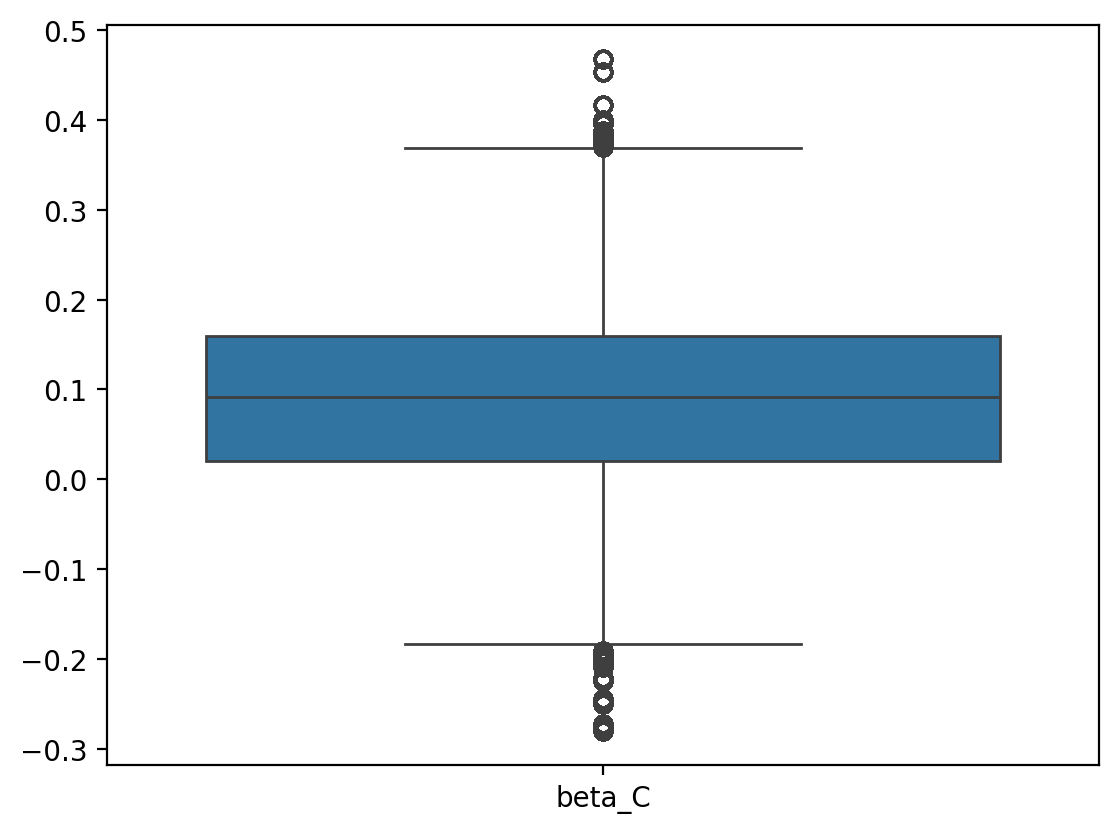

In [ ]:
sns.boxplot(data=model_gold_low1_mcmc_samples[['beta_C']])

<Axes: >

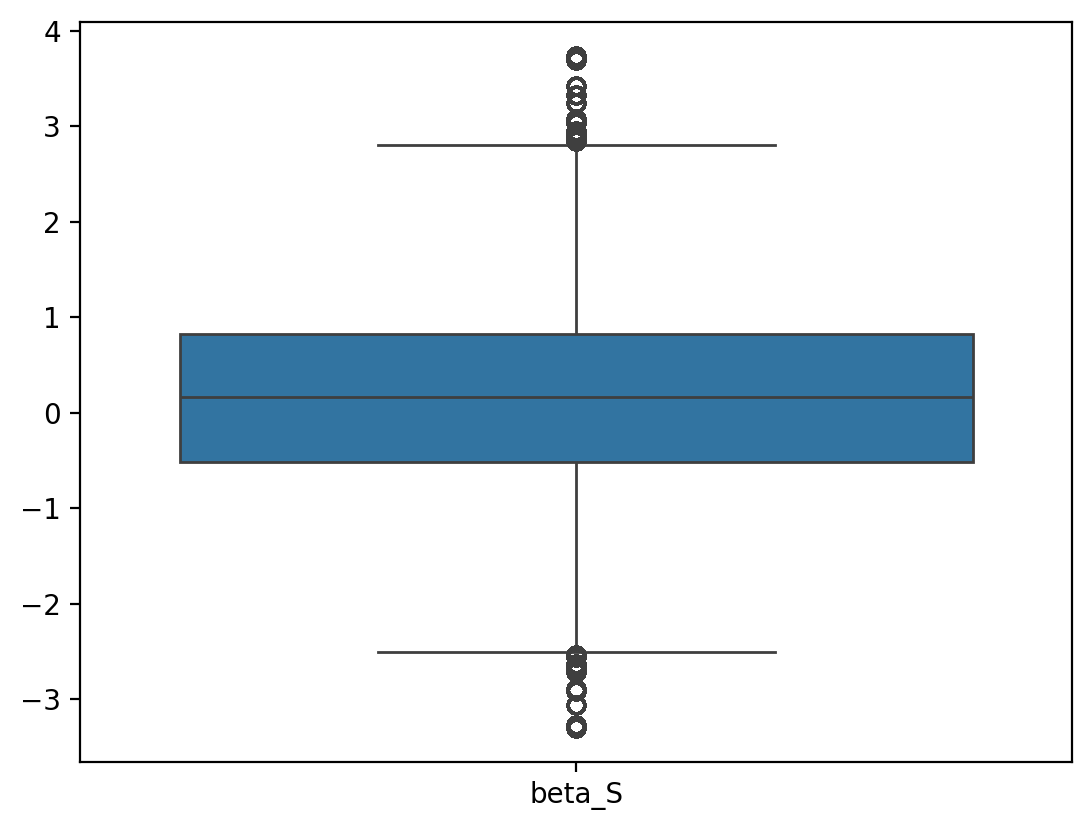

In [ ]:
sns.boxplot(data=model_gold_low1_mcmc_samples[['beta_S']])

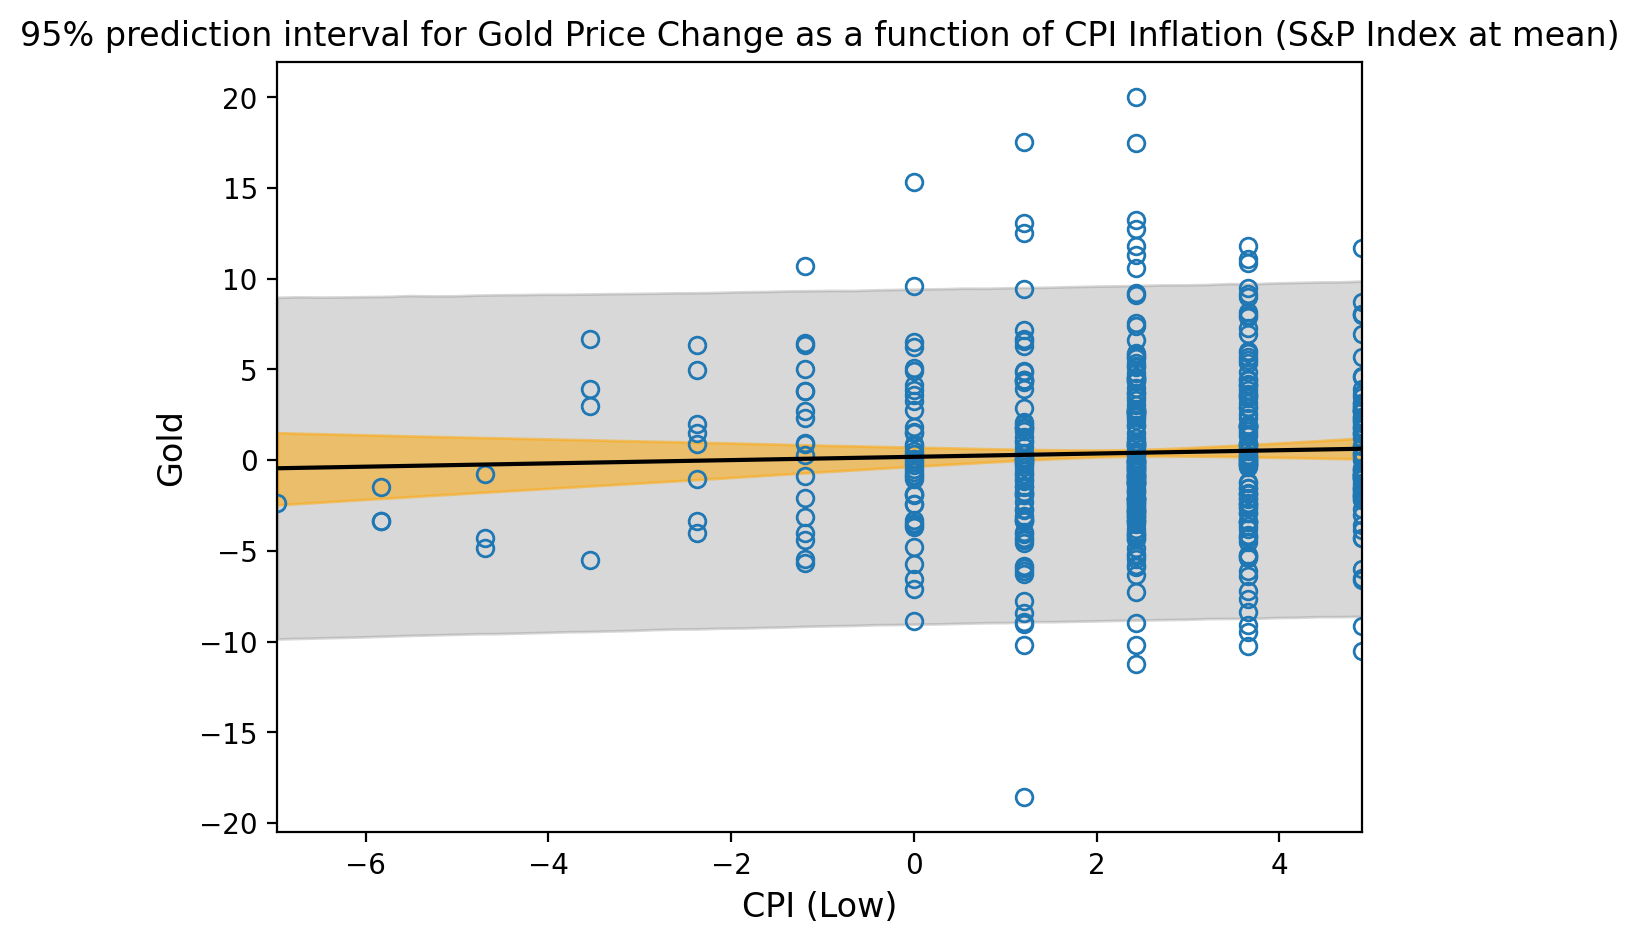

In [ ]:
## Prediction plot for Gold from CPI and S&P MCMC, holding S&P at its mean:

prob = 0.95 ## for credible intervals

xmin = data_gold_low['CPI.U'].min()
xmax = data_gold_low['CPI.U'].max()
xmean = data_gold_low['CPI.U'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_gold_low1_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_gold_low1_mcmc_samples['beta_C'])[None, :]
sigma_samples = array(model_gold_low1_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_gold_low['CPI.U'], data_gold_low['GoldChange'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Gold Price Change as a function of CPI Inflation (S&P Index at mean)')
xlabel('CPI (Low)', fontsize=12)
ylabel('Gold', fontsize=12);

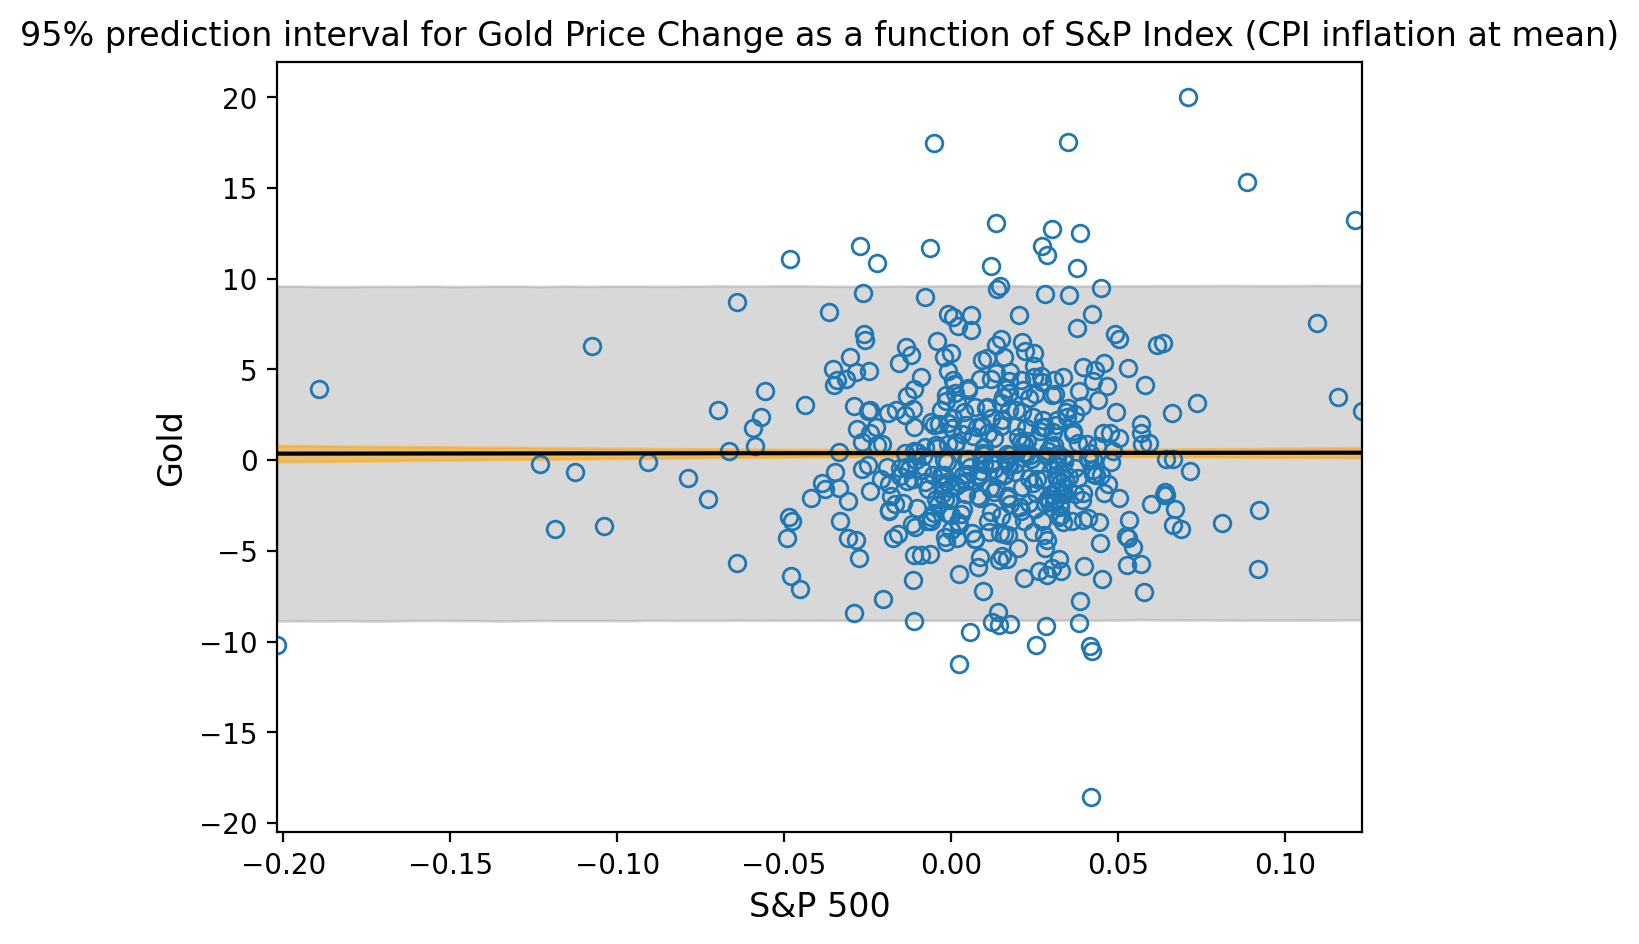

In [ ]:
## Prediction plot for Gold from CPI and S&P MCMC, holding CPI at its mean:

prob = 0.95 ## for credible intervals

xmin = data_gold_low['SPIndex'].min()
xmax = data_gold_low['SPIndex'].max()
xmean = data_gold_low['SPIndex'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_gold_low1_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_gold_low1_mcmc_samples['beta_S'])[None, :]
sigma_samples = array(model_gold_low1_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_gold_low['SPIndex'], data_gold_low['GoldChange'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Gold Price Change as a function of S&P Index (CPI inflation at mean)')
xlabel('S&P 500', fontsize=12)
ylabel('Gold', fontsize=12);

In [ ]:
mean_C_low, mean_S_low = model_gold_low1_mcmc_samples[['beta_C', 'beta_S']].mean()

print('LOW:')
print('mean_C=', mean_C_low)
print('----------')
print('mean_S=', mean_S_low)

LOW:
mean_C= 0.09059063957289967
----------
mean_S= 0.16155126653394203


## High Inflation:

We observe that, for the High inflation regime, the mean for the price change of gold is approximately 1.55%, so we take the prior $\alpha$ to have a mean of 1.55 and standard deviation of 0.2.

As such, we take the following prior:

\begin{align*}
    Gold_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{C}(C_{i}-\bar{C}) + \beta_{S}(S_{i}-\bar{S}) \\
    \alpha &\sim \text{Normal}(1.55, 0.2) \\
    \beta_{C} &\sim \text{Normal}(0, 1) \\
    \beta_{S} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $C_i$ denotes the CPI inflation rate and $S_i$ denotes the S&P 500 growth rate.

In [ ]:
with pm.Model() as model_gold_high1:
    sigma = pm.Exponential('sigma', 0.5)
    beta_C = pm.Normal('beta_C', mu=0, sigma=1)
    beta_S = pm.Normal('beta_S', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=1.55, sigma=0.2)
    _mu = alpha + beta_C*(data_gold_high['CPI.U']-data_gold_high['CPI.U'].mean()) + beta_S*(data_gold_high['SPIndex']-data_gold_high['SPIndex'].mean())
    mu = pm.Deterministic('mu', _mu)
    Gold = pm.Normal('Gold', mu=mu, sigma=sigma, observed=data_gold_high['GoldChange'])
    _model_gold_high1_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_gold_high1_mcmc_samples = _model_gold_high1_mcmc_samples.posterior.to_dataframe()
model_gold_high1_mcmc_samples

alpha    beta_C    beta_S        mu     sigma
chain draw mu_dim_0                                                  
0     0    0         1.768507  0.479466 -0.303713  0.277213  8.099320
           1         1.768507  0.479466 -0.303713  0.273751  8.099320
           2         1.768507  0.479466 -0.303713  0.264397  8.099320
           3         1.768507  0.479466 -0.303713  0.271078  8.099320
           4         1.768507  0.479466 -0.303713  0.265338  8.099320
...                       ...       ...       ...       ...       ...
3     999  159       1.482263  0.250914 -0.775569  2.335671  7.759014
           160       1.482263  0.250914 -0.775569  2.028637  7.759014
           161       1.482263  0.250914 -0.775569  3.012249  7.759014
           162       1.482263  0.250914 -0.775569  0.660937  7.759014
           163       1.482263  0.250914 -0.775569  0.677535  7.759014

[656000 rows x 5 columns]

<Axes: >

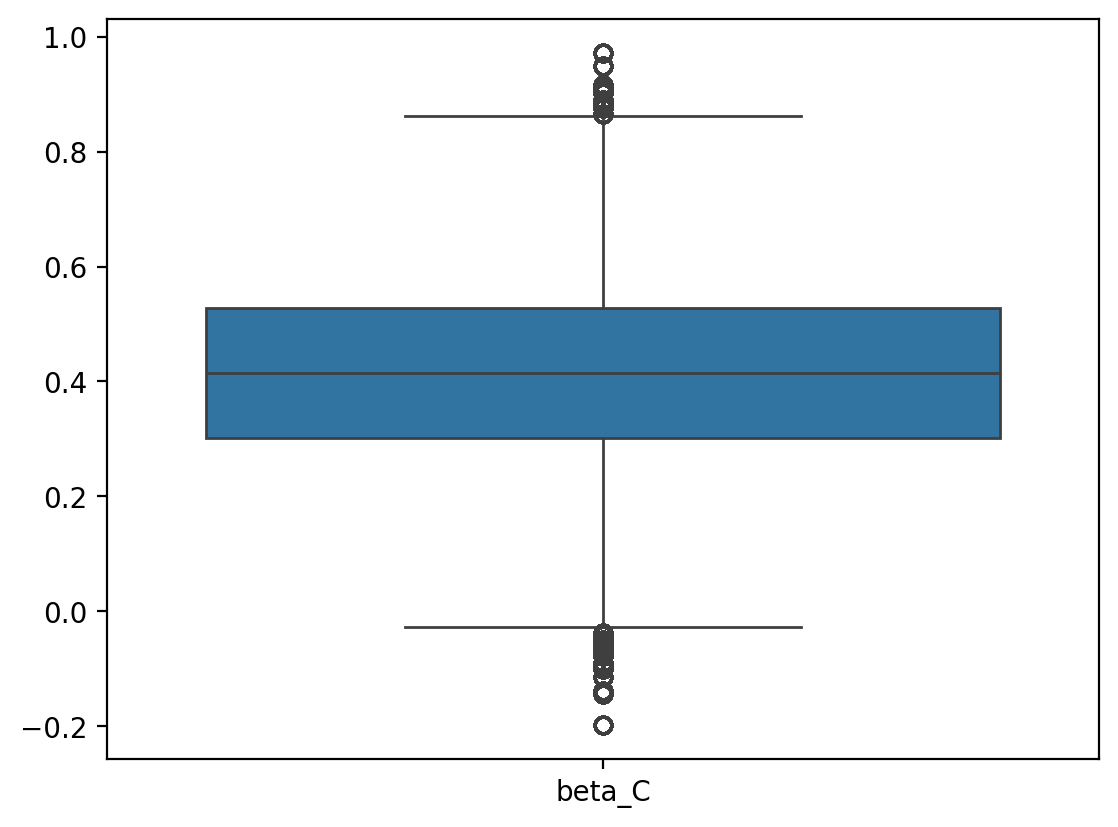

In [ ]:
sns.boxplot(data=model_gold_high1_mcmc_samples[['beta_C']])

<Axes: >

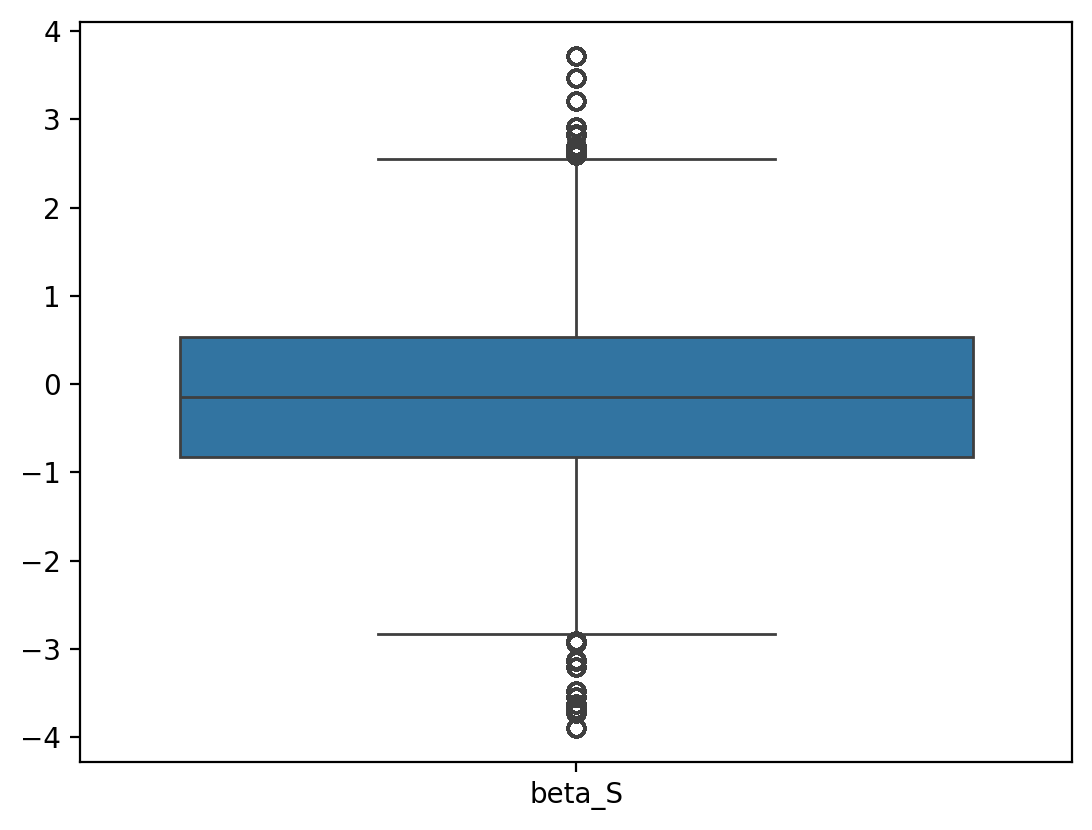

In [ ]:
sns.boxplot(data=model_gold_high1_mcmc_samples[['beta_S']])

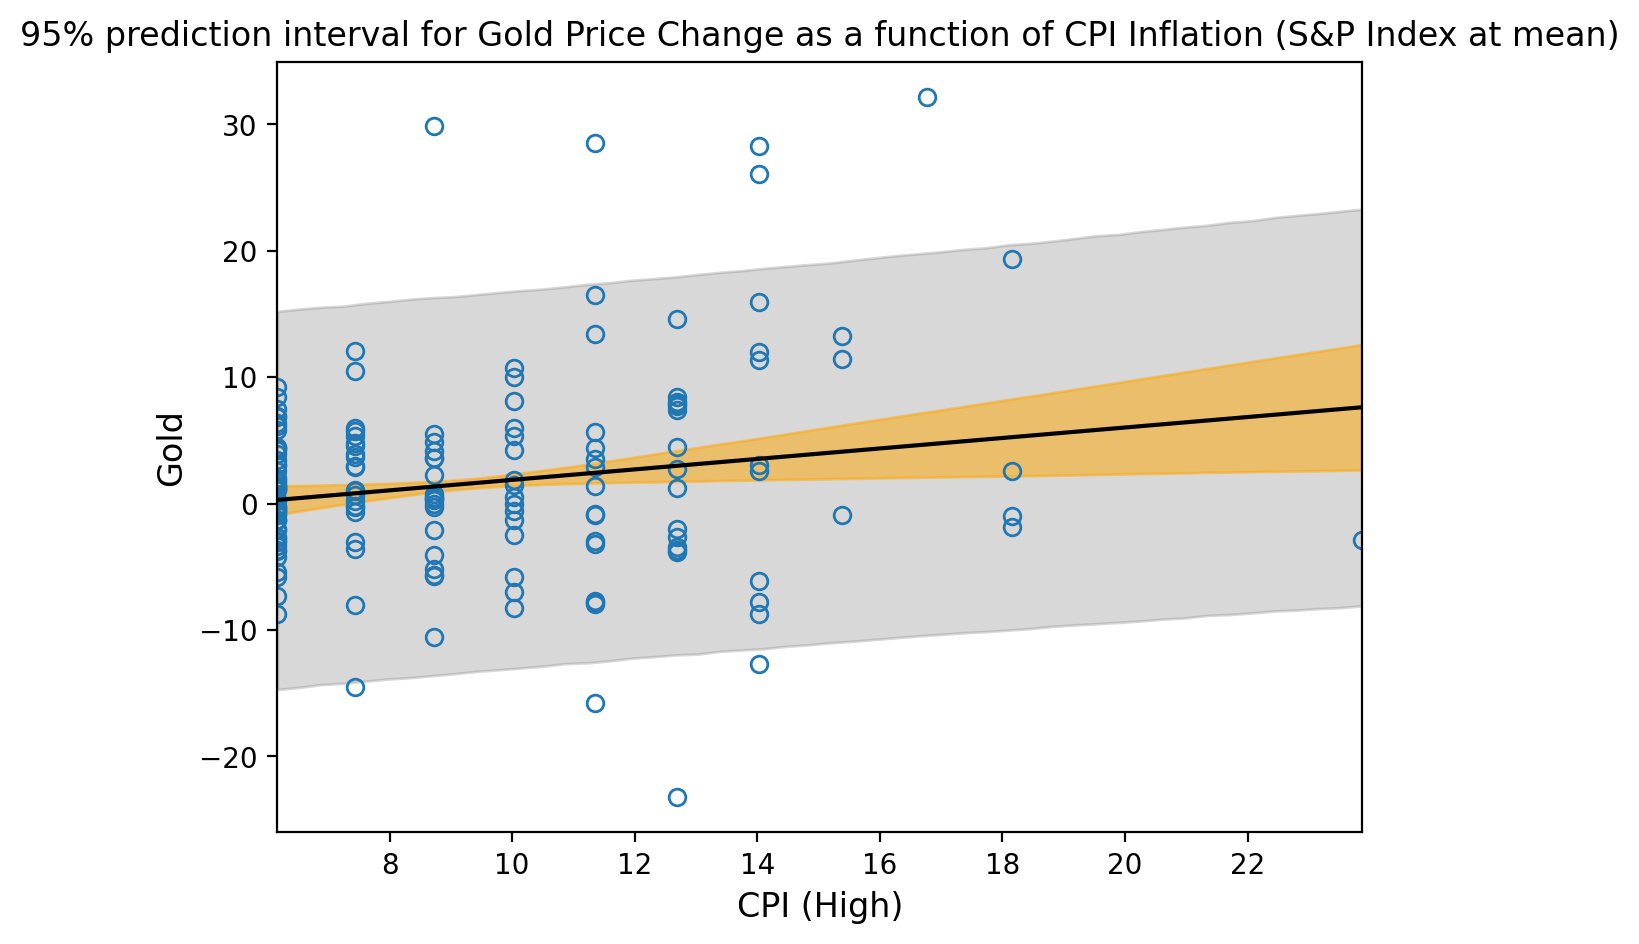

In [ ]:
## Prediction plot for Gold from CPI and S&P MCMC, holding S&P at its mean:

prob = 0.95 ## for credible intervals

xmin = data_gold_high['CPI.U'].min()
xmax = data_gold_high['CPI.U'].max()
xmean = data_gold_high['CPI.U'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_gold_high1_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_gold_high1_mcmc_samples['beta_C'])[None, :]
sigma_samples = array(model_gold_high1_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_gold_high['CPI.U'], data_gold_high['GoldChange'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Gold Price Change as a function of CPI Inflation (S&P Index at mean)')
xlabel('CPI (High)', fontsize=12)
ylabel('Gold', fontsize=12);

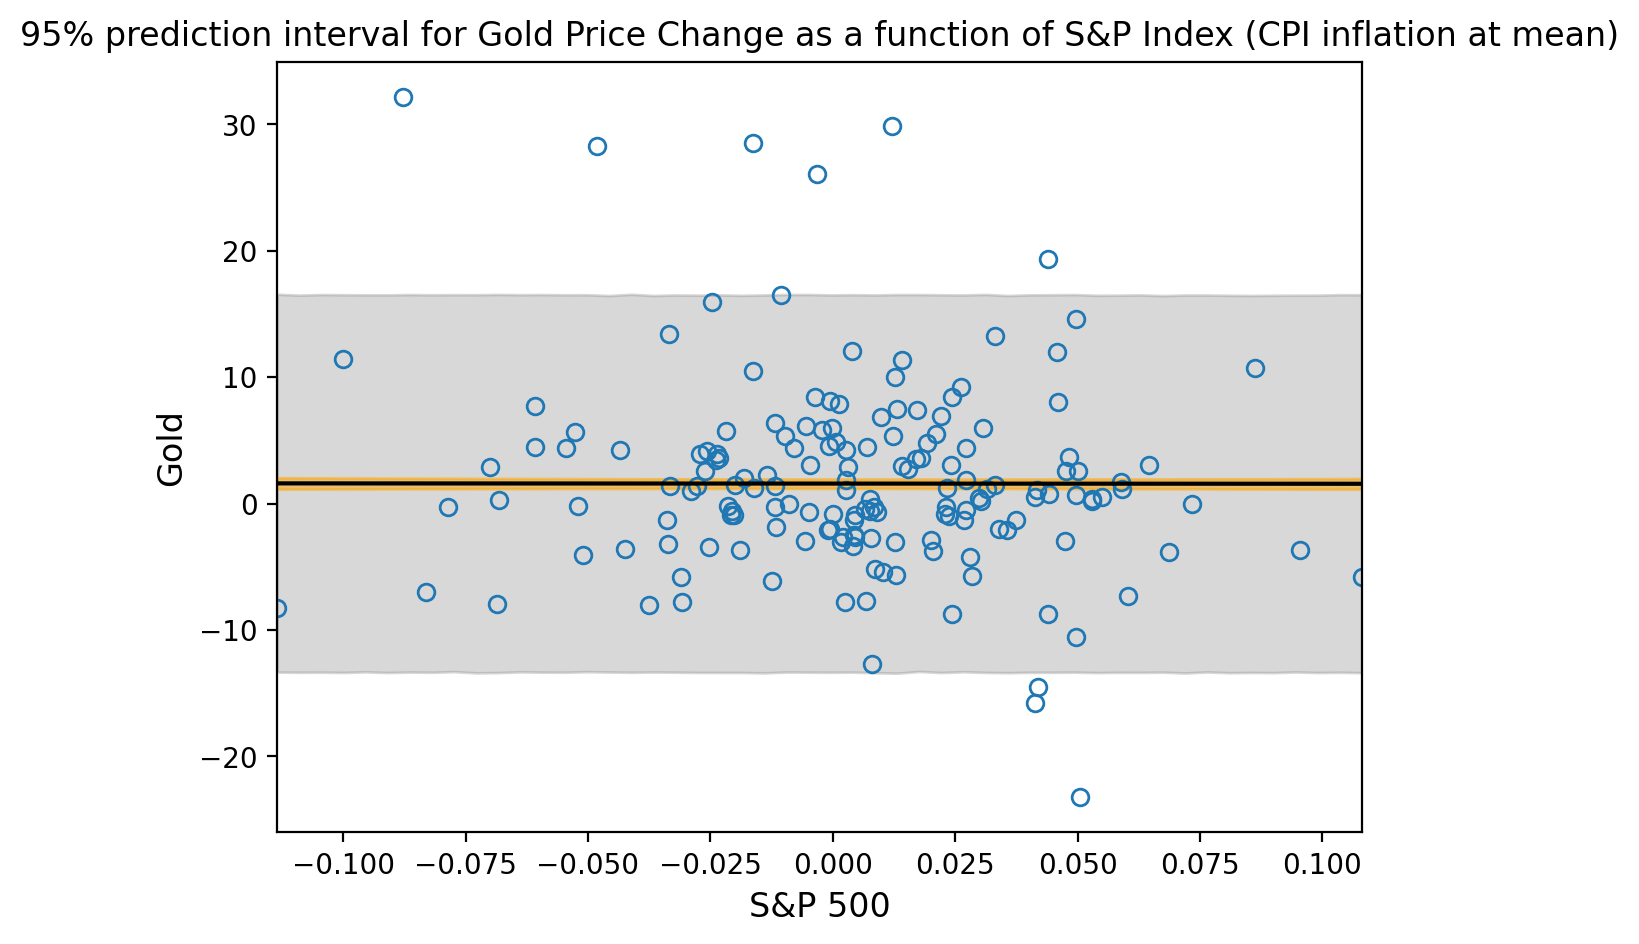

In [ ]:
## Prediction plot for Gold from CPI and S&P MCMC, holding CPI at its mean:

prob = 0.95 ## for credible intervals

xmin = data_gold_high['SPIndex'].min()
xmax = data_gold_high['SPIndex'].max()
xmean = data_gold_high['SPIndex'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_gold_high1_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_gold_high1_mcmc_samples['beta_S'])[None, :]
sigma_samples = array(model_gold_high1_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_gold_high['SPIndex'], data_gold_high['GoldChange'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Gold Price Change as a function of S&P Index (CPI inflation at mean)')
xlabel('S&P 500', fontsize=12)
ylabel('Gold', fontsize=12);

In [ ]:
mean_C_high, mean_S_high = model_gold_high1_mcmc_samples[['beta_C', 'beta_S']].mean()

print('HIGH:')
print('mean_C=', mean_C_high)
print('----------')
print('mean_S=', mean_S_high)

HIGH:
mean_C= 0.4141942469413011
----------
mean_S= -0.14263255290417706


## Gold Price & GDP:

Now, we turn our attention to analysing the effect of GDP on gold price. For this purpose, we simply condition on S&P 500 and CPI. As such, our prior takes the form:

\begin{align*}
    Gold_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{G}(G_{i}-\bar{G}) \\
    \alpha &\sim \text{Normal}(0.75, 0.2) \\
    \beta_{G} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}

In [ ]:
with pm.Model() as model_gold2:
    sigma = pm.Exponential('sigma', 0.5)
    beta_G = pm.Normal('beta_G', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=0.75, sigma=0.2)
    _mu = alpha + beta_G*(data_pt2['GDP']-data_pt2['GDP'].mean())
    mu = pm.Deterministic('mu', _mu)
    Gold = pm.Normal('Gold', mu=mu, sigma=sigma, observed=data_pt2['GoldChange'])
    _model_gold2_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_gold2_mcmc_samples = _model_gold2_mcmc_samples.posterior.to_dataframe()
model_gold2_mcmc_samples

alpha    beta_G        mu     sigma
chain draw mu_dim_0                                        
0     0    0         0.599483  0.402962  0.956005  5.704999
           1         0.599483  0.402962  0.637974  5.704999
           2         0.599483  0.402962  0.637974  5.704999
           3         0.599483  0.402962  0.637974  5.704999
           4         0.599483  0.402962  0.636784  5.704999
...                       ...       ...       ...       ...
3     999  618       0.712768  0.428704  0.622051  5.758669
           619       0.712768  0.428704  0.622051  5.758669
           620       0.712768  0.428704  0.622051  5.758669
           621       0.712768  0.428704  0.783497  5.758669
           622       0.712768  0.428704  0.783497  5.758669

[2492000 rows x 4 columns]

<Axes: >

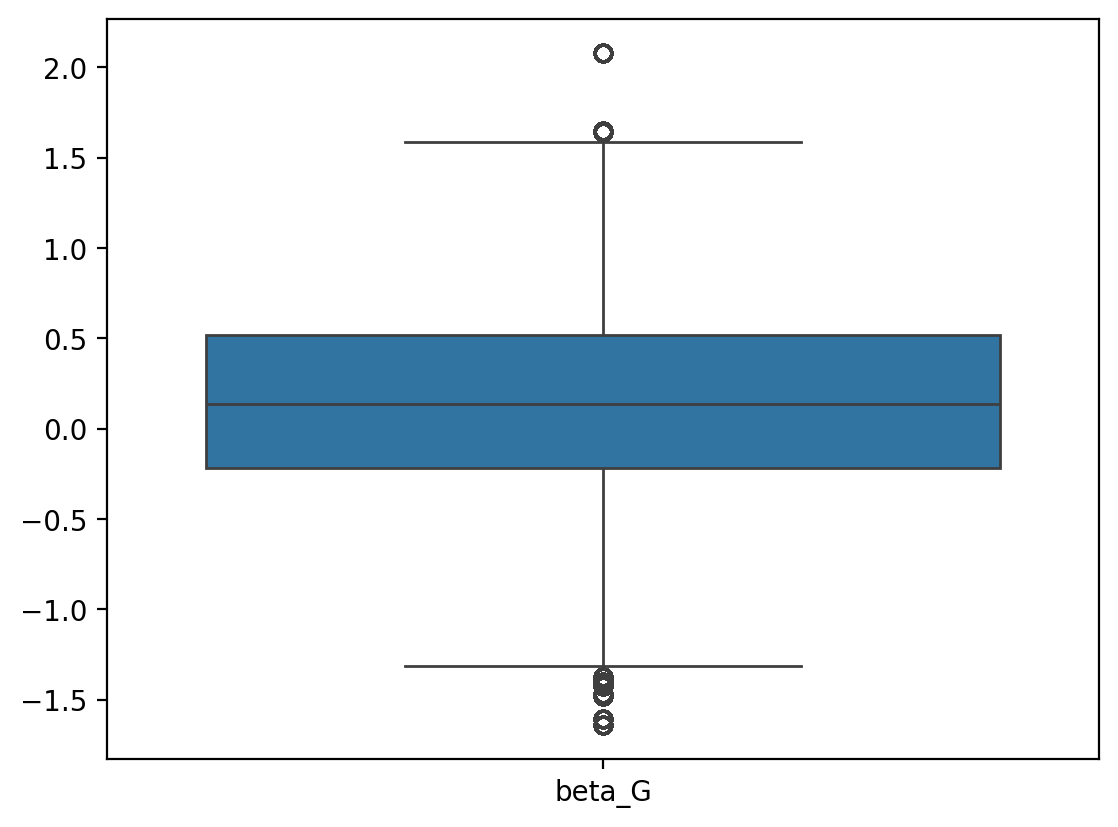

In [ ]:
sns.boxplot(data=model_gold2_mcmc_samples[['beta_G']])

As can be seen, the boxplot for $\beta_G$ is centered relatively close to 0, indicating that there is likely not a notable relationship between GDP growth and Gold price changes.

Our 95% Credibility interval plot for Gold price change vs GDP growth is:


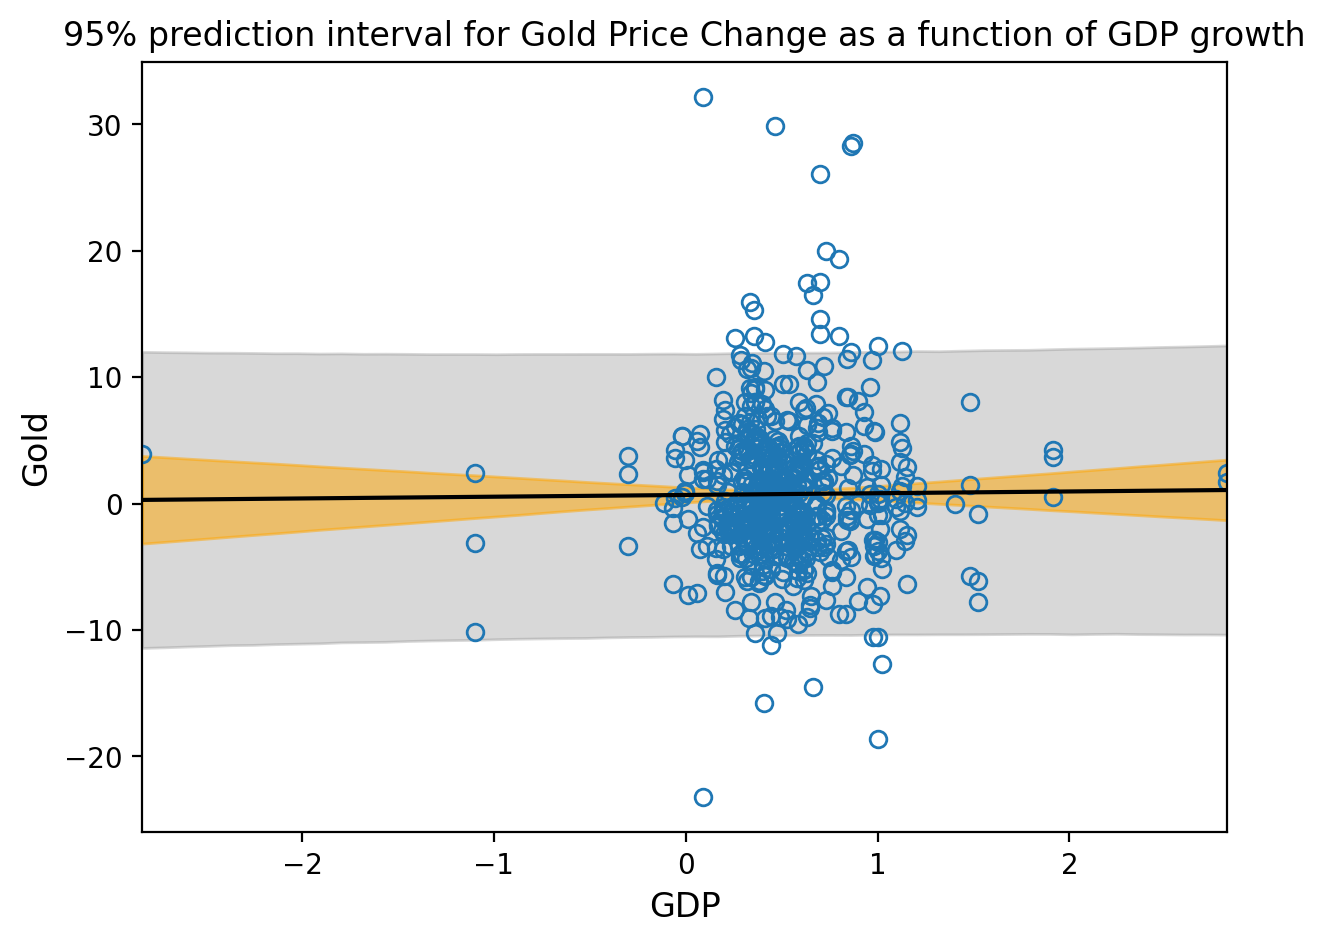

In [ ]:
## Prediction plot for Gold vs GDP growth:

prob = 0.95 ## for credible intervals

xmin = data_pt2['GDP'].min()
xmax = data_pt2['GDP'].max()
xmean = data_pt2['GDP'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_gold2_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_gold2_mcmc_samples['beta_G'])[None, :]
sigma_samples = array(model_gold2_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_pt2['GDP'], data_pt2['GoldChange'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Gold Price Change as a function of GDP growth')
xlabel('GDP', fontsize=12)
ylabel('Gold', fontsize=12);

However, from this credibility interval plot, the presence of influential datapoints makes it difficult to determine whether our linearity assumption is reasonable. As such, we drop these influential datapoints, and investigate how our MCMC model behaves in that situation.

In [ ]:
mean_G_total = model_gold2_mcmc_samples[['beta_G']].mean()

print('TOTAL:')
print('mean_G=', mean_G_total)

TOTAL:
mean_G= beta_G    0.138128
dtype: float64


In [ ]:
gdp_threshold = data_pt2['GDP'].quantile([0.01, 0.99]).values
gdp_low_threshold, gdp_high_threshold = gdp_threshold

data_filtered2 = data_pt2[(data_pt2['GDP'] > gdp_low_threshold) & (data_pt2['GDP'] < gdp_high_threshold)]

In [ ]:
with pm.Model() as model_gold3:
    sigma = pm.Exponential('sigma', 0.5)
    beta_G = pm.Normal('beta_G', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=0.75, sigma=0.2)
    _mu = alpha + beta_G*(data_filtered2['GDP']-data_filtered2['GDP'].mean())
    mu = pm.Deterministic('mu', _mu)
    Gold = pm.Normal('Gold', mu=mu, sigma=sigma, observed=data_filtered2['GoldChange'])
    _model_gold3_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_gold3_mcmc_samples = _model_gold3_mcmc_samples.posterior.to_dataframe()
model_gold3_mcmc_samples

alpha   beta_G        mu     sigma
chain draw mu_dim_0                                       
0     0    0         0.856254 -0.42024  0.483664  5.952829
           1         0.856254 -0.42024  0.815331  5.952829
           2         0.856254 -0.42024  0.815331  5.952829
           3         0.856254 -0.42024  0.815331  5.952829
           4         0.856254 -0.42024  0.816573  5.952829
...                       ...      ...       ...       ...
3     999  603       0.985858  0.36294  0.909732  5.716495
           604       0.985858  0.36294  0.909732  5.716495
           605       0.985858  0.36294  0.909732  5.716495
           606       0.985858  0.36294  1.046412  5.716495
           607       0.985858  0.36294  1.046412  5.716495

[2432000 rows x 4 columns]

<Axes: >

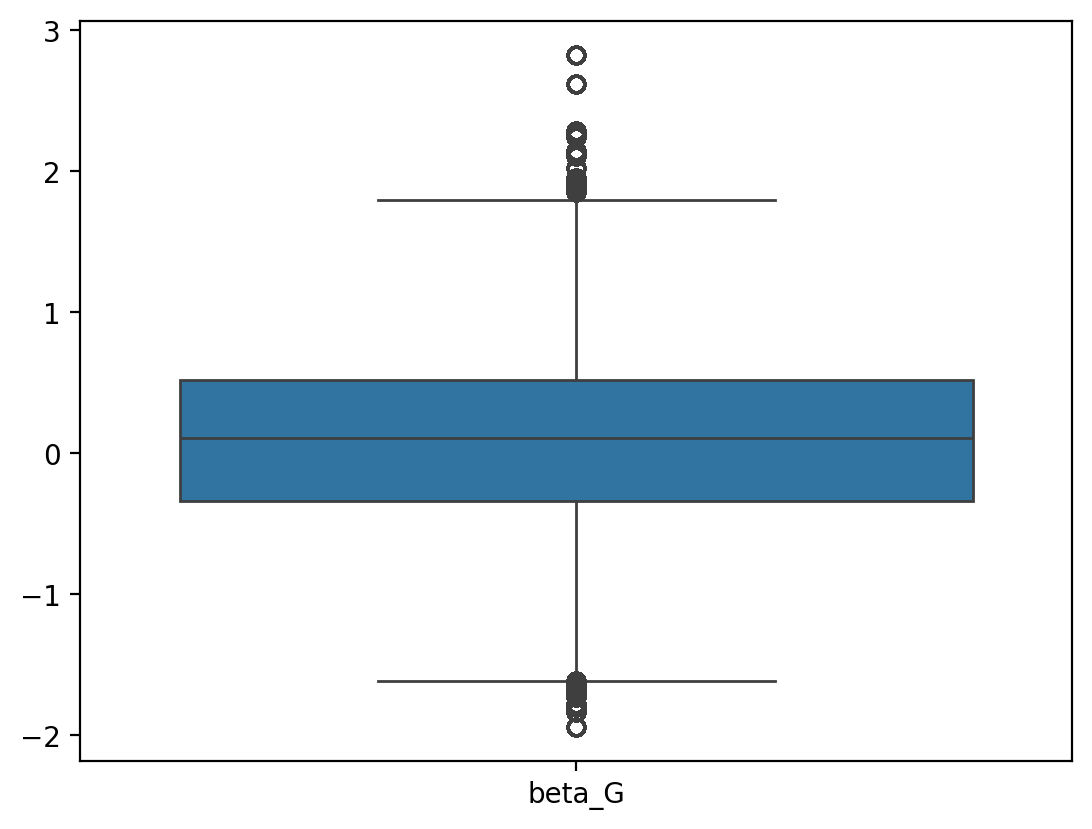

In [ ]:
sns.boxplot(data=model_gold3_mcmc_samples[['beta_G']])

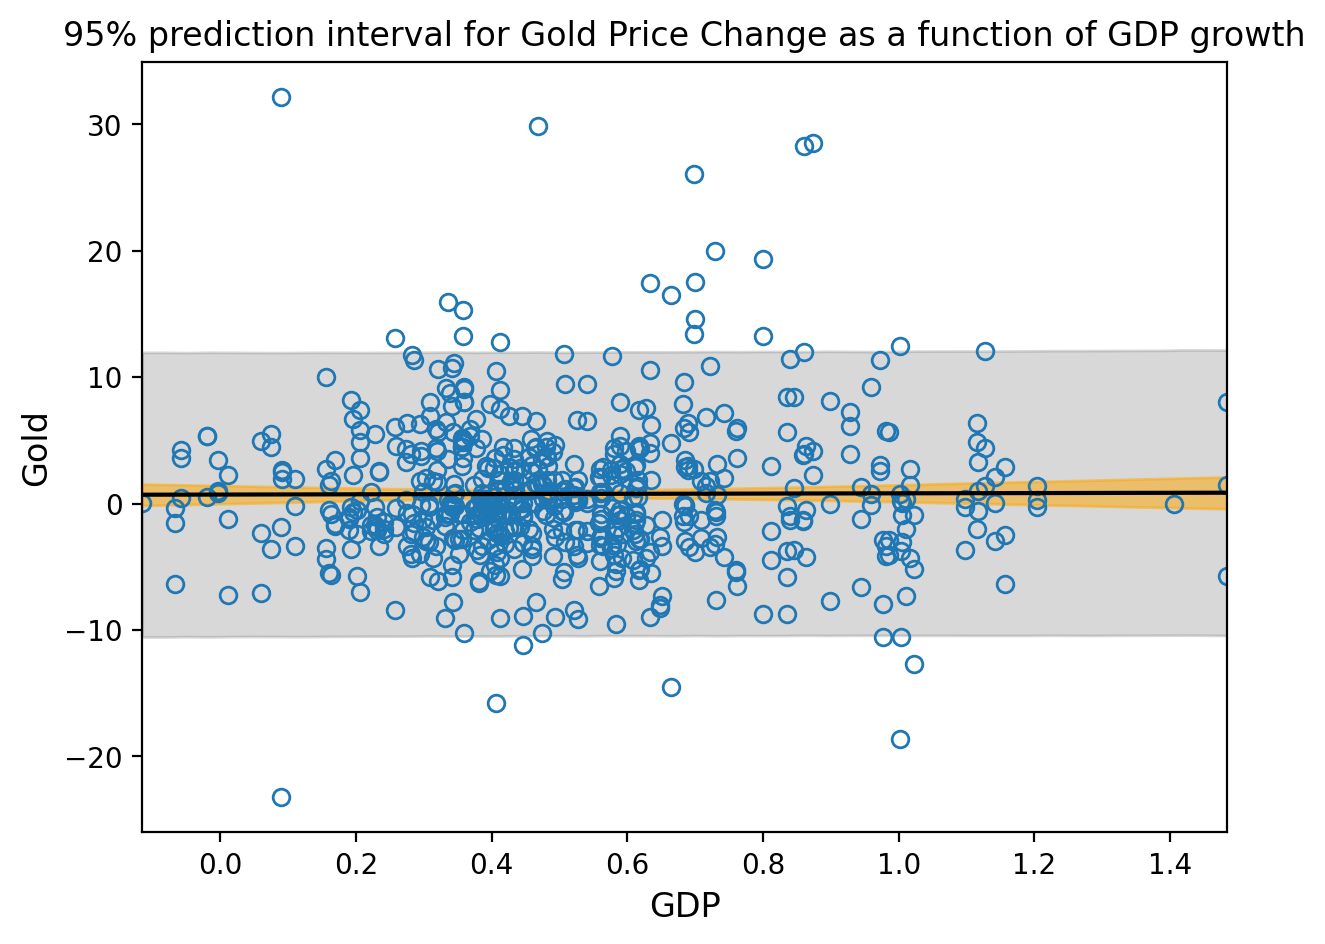

In [ ]:
## Prediction plot for Gold vs GDP growth:

prob = 0.95 ## for credible intervals

xmin = data_filtered2['GDP'].min()
xmax = data_filtered2['GDP'].max()
xmean = data_filtered2['GDP'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_gold3_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_gold3_mcmc_samples['beta_G'])[None, :]
sigma_samples = array(model_gold3_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_filtered2['GDP'], data_filtered2['GoldChange'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Gold Price Change as a function of GDP growth')
xlabel('GDP', fontsize=12)
ylabel('Gold', fontsize=12);

## Analyzing different Inflation Regimes:

In [ ]:
print('Gold(Low)=', data_gold_low['GoldChange'].mean())
print('Gold(High)=', data_gold_high['GoldChange'].mean())

Gold(Low)= 0.3692511150326797
Gold(High)= 1.8889587544451218


## Low Inflation:

Now, we turn our attention to analysing the effect of GDP on gold price in the low-inflation regime. For this purpose, we simply condition on S&P 500 and CPI. As such, our prior takes the form:

\begin{align*}
    Gold_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{G}(G_{i}-\bar{G}) \\
    \alpha &\sim \text{Normal}(0.4, 0.1) \\
    \beta_{G} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}

In [ ]:
with pm.Model() as model_gold_low2:
    sigma = pm.Exponential('sigma', 0.5)
    beta_G = pm.Normal('beta_G', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=0.4, sigma=0.1)
    _mu = alpha + beta_G*(data_gold_low['GDP']-data_gold_low['GDP'].mean())
    mu = pm.Deterministic('mu', _mu)
    Gold = pm.Normal('Gold', mu=mu, sigma=sigma, observed=data_gold_low['GoldChange'])
    _model_gold_low2_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_gold_low2_mcmc_samples = _model_gold_low2_mcmc_samples.posterior.to_dataframe()
model_gold_low2_mcmc_samples

alpha    beta_G        mu     sigma
chain draw mu_dim_0                                       
0     0    0         0.18863  0.335418  0.507442  4.868432
           1         0.18863  0.335418  0.242719  4.868432
           2         0.18863  0.335418  0.242719  4.868432
           3         0.18863  0.335418  0.242719  4.868432
           4         0.18863  0.335418  0.241728  4.868432
...                      ...       ...       ...       ...
3     999  454       0.38811 -0.179708  0.414324  4.726998
           455       0.38811 -0.179708  0.414324  4.726998
           456       0.38811 -0.179708  0.414324  4.726998
           457       0.38811 -0.179708  0.346648  4.726998
           458       0.38811 -0.179708  0.346648  4.726998

[1836000 rows x 4 columns]

<Axes: >

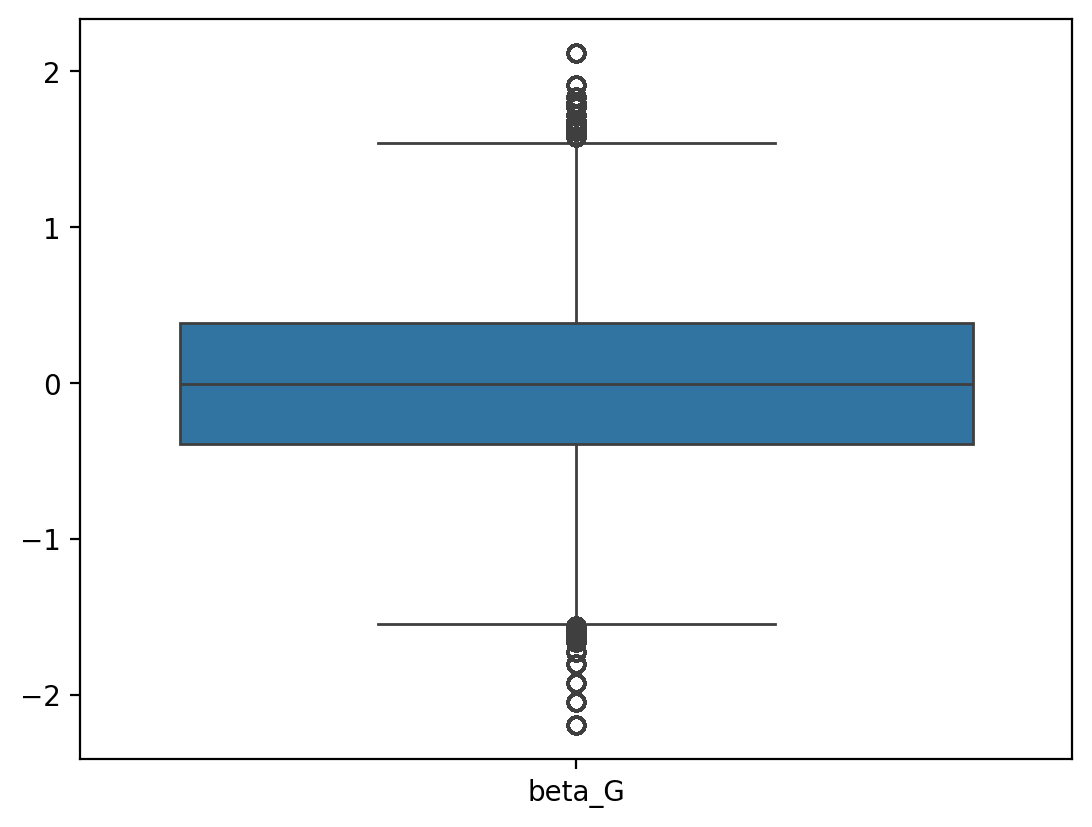

In [ ]:
sns.boxplot(data=model_gold_low2_mcmc_samples[['beta_G']])

As can be seen, the boxplot for $\beta_G$ is centered relatively close to 0, indicating that there is likely not a notable relationship between GDP growth and Gold price changes.

Our 95% Credibility interval plot for Gold price change vs GDP growth is:


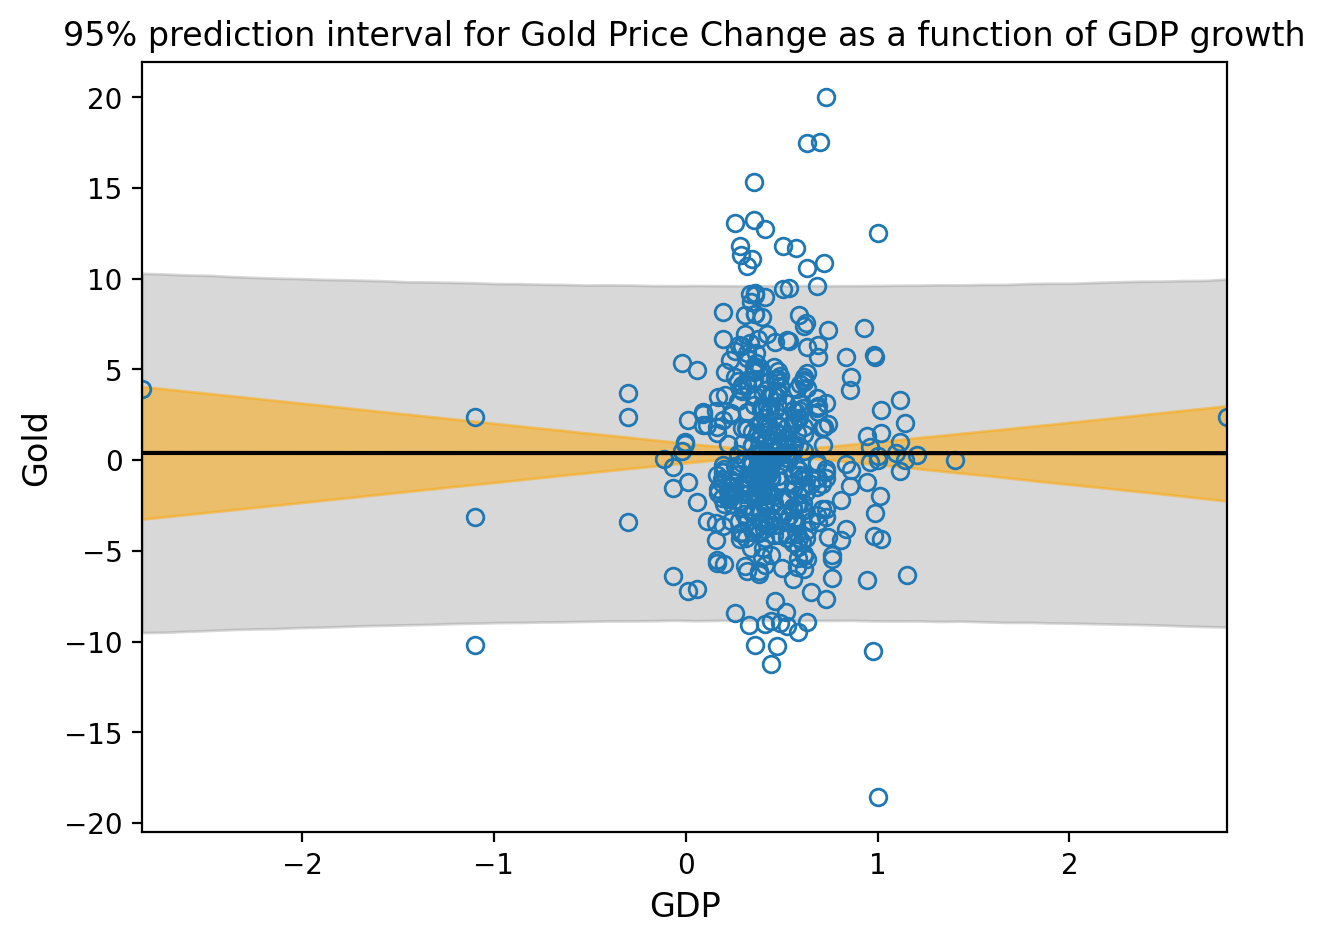

In [ ]:
## Prediction plot for Gold vs GDP growth:

prob = 0.95 ## for credible intervals

xmin = data_gold_low['GDP'].min()
xmax = data_gold_low['GDP'].max()
xmean = data_gold_low['GDP'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_gold_low2_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_gold_low2_mcmc_samples['beta_G'])[None, :]
sigma_samples = array(model_gold_low2_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_gold_low['GDP'], data_gold_low['GoldChange'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Gold Price Change as a function of GDP growth')
xlabel('GDP', fontsize=12)
ylabel('Gold', fontsize=12);

In [ ]:
mean_G_low = model_gold_low2_mcmc_samples[['beta_G']].mean()

print('LOW:')
print('mean_G=', mean_G_low)


LOW:
mean_G= beta_G   -0.001858
dtype: float64


## High Inflation:

Now, we turn our attention to analysing the effect of GDP on gold price in the high-inflation regime. For this purpose, we simply condition on S&P 500 and CPI. As such, our prior takes the form:

\begin{align*}
    Gold_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{G}(G_{i}-\bar{G}) \\
    \alpha &\sim \text{Normal}(1.55, 0.2) \\
    \beta_{G} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}

In [ ]:
with pm.Model() as model_gold_high3:
    sigma = pm.Exponential('sigma', 0.5)
    beta_G = pm.Normal('beta_G', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=1.55, sigma=0.2)
    _mu = alpha + beta_G*(data_gold_high['GDP']-data_gold_high['GDP'].mean())
    mu = pm.Deterministic('mu', _mu)
    Gold = pm.Normal('Gold', mu=mu, sigma=sigma, observed=data_gold_high['GoldChange'])
    _model_gold_high3_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_gold_high3_mcmc_samples = _model_gold_high3_mcmc_samples.posterior.to_dataframe()
model_gold_high3_mcmc_samples

alpha    beta_G        mu     sigma
chain draw mu_dim_0                                        
0     0    0         1.364261 -1.078648  1.462873  7.704997
           1         1.364261 -1.078648  1.462873  7.704997
           2         1.364261 -1.078648  1.089532  7.704997
           3         1.364261 -1.078648  1.066694  7.704997
           4         1.364261 -1.078648  0.825534  7.704997
...                       ...       ...       ...       ...
3     999  159       1.518078 -0.452113  1.528599  7.577029
           160       1.518078 -0.452113  1.572522  7.577029
           161       1.518078 -0.452113  1.572522  7.577029
           162       1.518078 -0.452113  1.598060  7.577029
           163       1.518078 -0.452113  1.606620  7.577029

[656000 rows x 4 columns]

<Axes: >

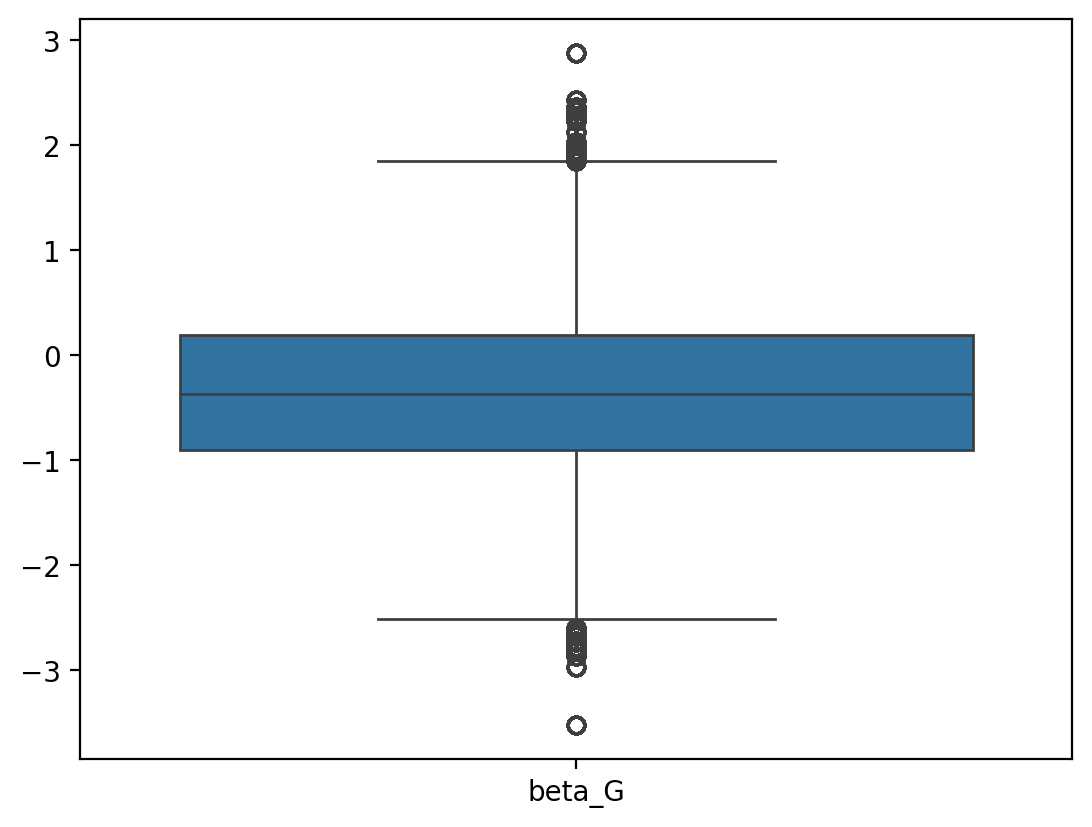

In [ ]:
sns.boxplot(data=model_gold_high3_mcmc_samples[['beta_G']])

As can be seen, the boxplot for $\beta_G$ is centered relatively close to 0, indicating that there is likely not a notable relationship between GDP growth and Gold price changes.

Our 95% Credibility interval plot for Gold price change vs GDP growth is:


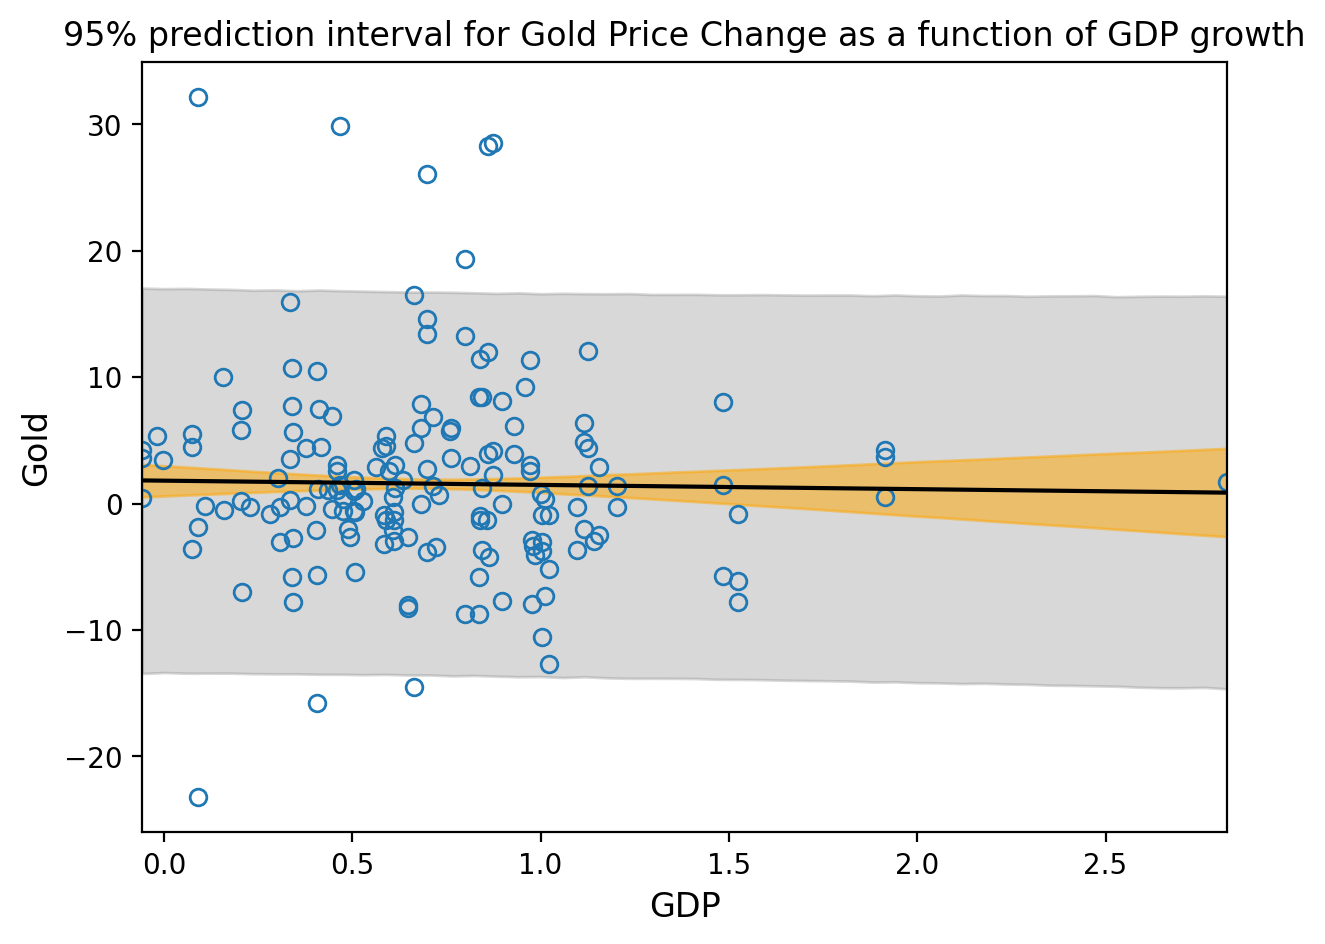

In [ ]:
## Prediction plot for Gold vs GDP growth:

prob = 0.95 ## for credible intervals

xmin = data_gold_high['GDP'].min()
xmax = data_gold_high['GDP'].max()
xmean = data_gold_high['GDP'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_gold_high3_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_gold_high3_mcmc_samples['beta_G'])[None, :]
sigma_samples = array(model_gold_high3_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_gold_high['GDP'], data_gold_high['GoldChange'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Gold Price Change as a function of GDP growth')
xlabel('GDP', fontsize=12)
ylabel('Gold', fontsize=12);

In [ ]:
mean_G_high = model_gold_high3_mcmc_samples[['beta_G']].mean()

print('HIGH:')
print('mean_G=', mean_G_high)


HIGH:
mean_G= beta_G   -0.335708
dtype: float64


## Overall:

In [ ]:
mean_C_total, mean_S_total = model_gold1_mcmc_samples[['beta_C', 'beta_S']].mean()

print('TOTAL:')
print('mean_C=', mean_C_total)
print('----------')
print('mean_S=', mean_S_total)

print('----------')
mean_G_total = model_gold2_mcmc_samples[['beta_G']].mean()

print('mean_G=', mean_G_total)

print("==============================")


mean_C_low, mean_S_low = model_gold_low1_mcmc_samples[['beta_C', 'beta_S']].mean()

print('LOW:')
print('mean_C=', mean_C_low)
print('----------')
print('mean_S=', mean_S_low)

print('----------')
mean_G_low = model_gold_low2_mcmc_samples[['beta_G']].mean()

print('mean_G=', mean_G_low)

print("==============================")


mean_C_high, mean_S_high = model_gold_high1_mcmc_samples[['beta_C', 'beta_S']].mean()

print('HIGH:')
print('mean_C=', mean_C_high)
print('----------')
print('mean_S=', mean_S_high)

print('----------')
mean_G_high = model_gold_high3_mcmc_samples[['beta_G']].mean()

print('mean_G=', mean_G_high)

TOTAL:
mean_C= 0.23056891805879287
----------
mean_S= -0.033110424427204764
----------
mean_G= beta_G    0.138128
dtype: float64
LOW:
mean_C= 0.09059063957289967
----------
mean_S= 0.16155126653394203
----------
mean_G= beta_G   -0.001858
dtype: float64
HIGH:
mean_C= 0.4141942469413011
----------
mean_S= -0.14263255290417706
----------
mean_G= beta_G   -0.335708
dtype: float64


In [ ]:
print(np.var(model_gold_low1_mcmc_samples[['beta_C']]), np.var(model_gold_high1_mcmc_samples[['beta_C']])),

print('Ratio=', np.var(model_gold_high1_mcmc_samples[['beta_C']])/np.var(model_gold_low1_mcmc_samples[['beta_C']]))

print("--------------------------------")

print("Eq. Var:")
stats.ttest_ind(a=model_gold_low1_mcmc_samples[['beta_C']], b=model_gold_high1_mcmc_samples[['beta_C']], equal_var=True)

# print("--------------------------------")

# print("Noneq. Var:")

# stats.ttest_ind(a=model_project_low1_mcmc_samples[['beta_M']], b=model_project_high1_mcmc_samples[['beta_M']], equal_var=False)

beta_C    0.011466
dtype: float64 beta_C    0.029122
dtype: float64
Ratio= beta_C    2.539914
dtype: float64
--------------------------------
Eq. Var:


TtestResult(statistic=array([-1772.2707259]), pvalue=array([0.]), df=array([2491998.]))

In [ ]:
print(np.var(model_gold_low1_mcmc_samples[['beta_S']]), np.var(model_gold_high1_mcmc_samples[['beta_S']])),

print('Ratio=', np.var(model_gold_high1_mcmc_samples[['beta_S']])/np.var(model_gold_low1_mcmc_samples[['beta_S']]))

print("--------------------------------")

print("Eq. Var:")
stats.ttest_ind(a=model_gold_low1_mcmc_samples[['beta_S']], b=model_gold_high1_mcmc_samples[['beta_S']], equal_var=True)

# print("--------------------------------")

beta_S    0.949549
dtype: float64 beta_S    0.994373
dtype: float64
Ratio= beta_S    1.047206
dtype: float64
--------------------------------
Eq. Var:


TtestResult(statistic=array([215.67995988]), pvalue=array([0.]), df=array([2491998.]))

In [ ]:
print(np.var(model_gold_low2_mcmc_samples[['beta_G']]), np.var(model_gold_high3_mcmc_samples[['beta_G']])),

print('Ratio=', np.var(model_gold_high3_mcmc_samples[['beta_G']])/np.var(model_gold_low2_mcmc_samples[['beta_G']]))

print("--------------------------------")

print("Eq. Var:")
stats.ttest_ind(a=model_gold_low2_mcmc_samples[['beta_G']], b=model_gold_high3_mcmc_samples[['beta_G']], equal_var=True)

beta_G    0.322963
dtype: float64 beta_G    0.671996
dtype: float64
Ratio= beta_G    2.080722
dtype: float64
--------------------------------
Eq. Var:


TtestResult(statistic=array([360.34933785]), pvalue=array([0.]), df=array([2491998.]))

## Summary & Interpretation of Results:

In our analysis of Part 1 (finding the relationships between CPI inflation and various important factors), we made the following observations relating to the corresponding Study Question posed in the Introduction of the report:


* We observed a significant positive linear relationship between *oil price change* and inflation.

* We observed a (nearly) consistent *12-month delay* between inflation and the central bank response in interest rate policy.

* There exists a *significant positive linear relationship* between time-delayed inflation and interest rate.

* There exists a significant *nonlinear relationship* between money supply change and interest rate, which we studied using quadratic and exponential regression.



Meanwhile, in our analysis of Part 2 (finding the significant influential factors on gold price change), we made the following observations relating to the corresponding Study Question posed in the Introduction of the report:


* In analyzing *inflation* and *S&P 500* stock index performance on gold price change, we observed a statistically significant positive correlation between inflation and gold price increase.

* However, we did not observe a significant correlation between S&P 500 stock index performance and gold price increase.

* This indicates that **gold is an even more effective inflation hedging asset than expected**, as it strongly correlates to inflation but is (generally) resilient with regard to stock market trends.  

* In analysing *GDP growth* versus gold price change, we did not observe any significant correlation between gold price growth and GDP growth.

* This further confirms that gold is resilient to market and macroeconomic trends, making it a valuable source of stability and an effective inflation hedge.
